### 데이터 로더

In [1]:
import os
import json
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

class DriverMonitoringDataset(Dataset):
    def __init__(self, img_root_dir, label_root_dir, transform=None):
        self.img_root_dir = img_root_dir
        self.label_root_dir = label_root_dir
        self.transform = transform
        self.data = self.load_data()
        self.class_to_idx = self.build_class_indices()

    def load_data(self):
        data = []
        for sga_folder in os.listdir(self.img_root_dir):
            ts_img_path = os.path.join(self.img_root_dir, sga_folder)
            ts_label_path = os.path.join(self.label_root_dir, sga_folder)
            
            if os.path.isdir(ts_img_path) and os.path.isdir(ts_label_path):
                for scenario_folder in os.listdir(ts_img_path):
                    img_scenario_path = os.path.join(ts_img_path, scenario_folder, 'img')
                    label_scenario_path = os.path.join(ts_label_path, scenario_folder, 'label')

                    if not os.path.exists(label_scenario_path) or not os.path.exists(img_scenario_path):
                        print(f"Missing label or image folder for scenario: {scenario_folder}")
                        continue

                    for label_file in os.listdir(label_scenario_path):
                        if label_file.endswith('.json'):
                            with open(os.path.join(label_scenario_path, label_file), 'r', encoding='utf-8') as f:
                                try:
                                    label_data = json.load(f)
                                except json.JSONDecodeError:
                                    print(f"Error reading JSON file: {label_file}")
                                    continue
                                
                                if 'scene' not in label_data or 'data' not in label_data['scene']:
                                    print(f"Invalid label data structure in: {label_file}")
                                    continue
                                
                                for img_data in label_data['scene']['data']:
                                    img_name = img_data['img_name']
                                    img_path = os.path.join(img_scenario_path, img_name)
                                    if os.path.exists(img_path):
                                        data.append((img_path, img_data))
                                    else:
                                        print(f"Image file not found: {img_path}")
            else:
                print(f"SGA folder not found or is not a directory: {sga_folder}")
        print(f"Total data loaded: {len(data)} samples")
        return data

    def build_class_indices(self):
        class_to_idx = {}
        for _, img_data in self.data:
            action = img_data['occupant'][0]['action']
            if action not in class_to_idx:
                class_to_idx[action] = len(class_to_idx)
        return class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, img_data = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            
            action = img_data['occupant'][0]['action']
            label = self.class_to_idx[action]
            return image, label
        except UnidentifiedImageError:
            print(f"Skipping corrupted image: {img_path}")
            return None, None

def custom_collate_fn(batch):
    # None 요소 제거
    batch = [data for data in batch if data[0] is not None]
    if not batch:
        return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
    return torch.utils.data.default_collate(batch)

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 및 데이터 로더 설정
img_root_dir = r"F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1"
label_root_dir = r"F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\라벨링데이터\TL1"
dataset = DriverMonitoringDataset(img_root_dir=img_root_dir, label_root_dir=label_root_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)

Total data loaded: 238067 samples


### 클래스 매핑 확인

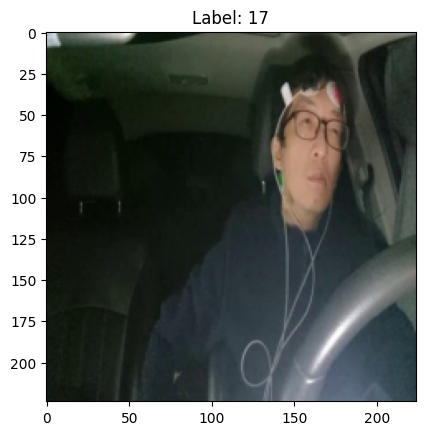

{'무언가를보다': 0, '허리굽히다': 1, '손을뻗다': 2, '몸을돌리다': 3, '핸드폰귀에대기': 4, '고개를돌리다': 5, '옆으로기대다': 6, '운전하다': 7, '힐끗거리다': 8, '중앙을쳐다보다': 9, '핸드폰쥐기': 10, '창문을열다': 11, '핸들을흔들다': 12, '꾸벅꾸벅졸다': 13, '핸들을놓치다': 14, '몸못가누기': 15, '무언가를마시다': 16, '무언가를쥐다': 17, '하품': 18, '중앙으로손을뻗다': 19, '박수치다': 20, '고개를좌우로흔들다': 21, '뺨을때리다': 22, '목을만지다': 23, '어깨를두드리다': 24, '허벅지두드리기': 25, '팔주무르기': 26, '눈비비기': 27, '눈깜빡이기': 28}
Index: 17, Action: 무언가를쥐다


In [2]:
import matplotlib.pyplot as plt

# 데이터 로더에서 하나의 배치를 가져옵니다.
images, labels = next(iter(data_loader))

# 첫 번째 이미지와 라벨 출력
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Label: {labels[0].item()}")
plt.show()

# class_to_idx 내용 확인
print(dataset.class_to_idx)

# 첫 번째 이미지와 라벨 출력
first_label = labels[0].item()
print(f"Index: {first_label}, Action: {list(dataset.class_to_idx.keys())[first_label]}")



### 데이터 로더 확인

In [3]:
# 데이터 로더에서 하나의 배치를 가져옵니다.
images, labels = next(iter(data_loader))

# 첫 번째 이미지와 라벨 출력
print(f"Batch size: {images.size()}")
print(f"First label: {labels[0]}")


Batch size: torch.Size([32, 3, 224, 224])
First label: 7


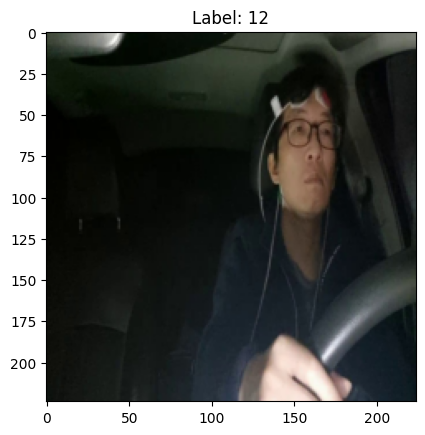

{'무언가를보다': 0, '허리굽히다': 1, '손을뻗다': 2, '몸을돌리다': 3, '핸드폰귀에대기': 4, '고개를돌리다': 5, '옆으로기대다': 6, '운전하다': 7, '힐끗거리다': 8, '중앙을쳐다보다': 9, '핸드폰쥐기': 10, '창문을열다': 11, '핸들을흔들다': 12, '꾸벅꾸벅졸다': 13, '핸들을놓치다': 14, '몸못가누기': 15, '무언가를마시다': 16, '무언가를쥐다': 17, '하품': 18, '중앙으로손을뻗다': 19, '박수치다': 20, '고개를좌우로흔들다': 21, '뺨을때리다': 22, '목을만지다': 23, '어깨를두드리다': 24, '허벅지두드리기': 25, '팔주무르기': 26, '눈비비기': 27, '눈깜빡이기': 28}
Index: 12, Action: 핸들을흔들다


In [4]:
import matplotlib.pyplot as plt

# 데이터 로더에서 하나의 배치를 가져옵니다.
images, labels = next(iter(data_loader))

# 첫 번째 이미지와 라벨 출력
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Label: {labels[0].item()}")
plt.show()

# class_to_idx 내용 확인
print(dataset.class_to_idx)

# 첫 번째 이미지와 라벨 출력
first_label = labels[0].item()
print(f"Index: {first_label}, Action: {list(dataset.class_to_idx.keys())[first_label]}")



### 각 라벨별 데이터 수 확인

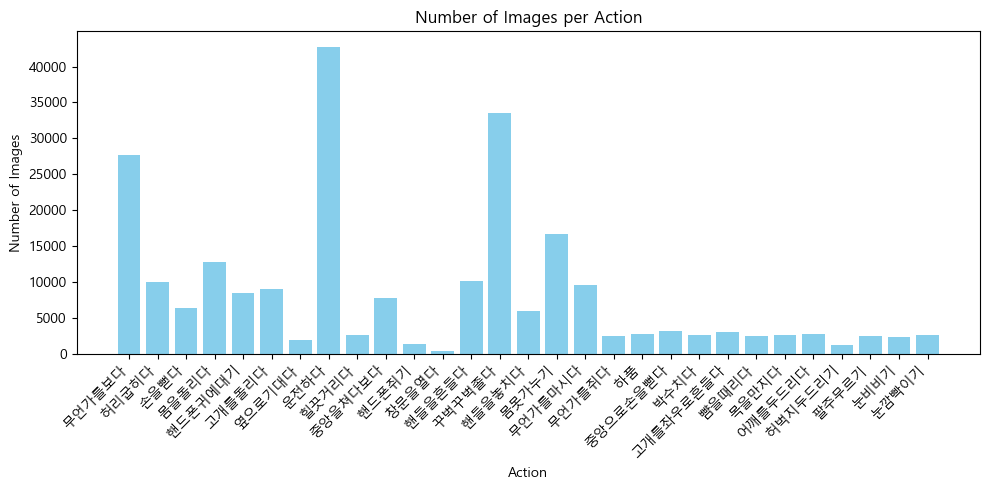

In [5]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc

# 사용할 폰트 지정 (Windows의 경우 예: 'Malgun Gothic')
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 폰트 설정
font_name = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터셋에서 각 액션별 이미지 수 집계
class_counts = {class_name: 0 for class_name in dataset.class_to_idx.keys()}
for _, img_data in dataset.data:
    action = img_data['occupant'][0]['action']
    class_counts[action] += 1

# 클래스 이름과 해당 이미지 수 리스트로 분리
actions = list(class_counts.keys())
counts = list(class_counts.values())

# 막대 그래프 생성
plt.figure(figsize=(10, 5))
plt.bar(actions, counts, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Number of Images')
plt.title('Number of Images per Action')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

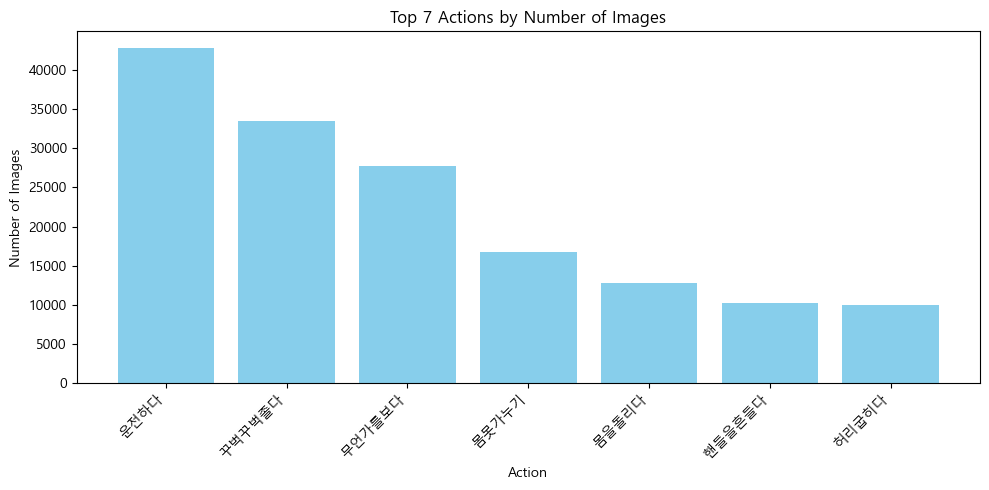

In [6]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc

# 사용할 폰트 지정 (Windows의 경우 예: 'Malgun Gothic')
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 폰트 설정
font_name = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 데이터셋에서 각 액션별 이미지 수 집계
class_counts = {class_name: 0 for class_name in dataset.class_to_idx.keys()}
for _, img_data in dataset.data:
    action = img_data['occupant'][0]['action']
    class_counts[action] += 1

# 클래스 이름과 해당 이미지 수 리스트로 분리 및 정렬
sorted_class_counts = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
top_actions, top_counts = zip(*sorted_class_counts[:7])

# 막대 그래프 생성
plt.figure(figsize=(10, 5))
plt.bar(top_actions, top_counts, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Number of Images')
plt.title('Top 7 Actions by Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Resnet-18 model로 이미지 분류 학습

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import UnidentifiedImageError

# 랜덤 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 데이터셋 및 학습 설정
total_size = len(dataset)
num_splits = 10  # 10개의 서브샘플로 나누기
num_classes = len(dataset.class_to_idx)
num_epochs = 5
batch_size = 64
learning_rate = 0.0001
print_interval = 30
checkpoint_dir = './final_no_weight_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory created.")

# GPU 사용 여부 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 초기화 및 설정 (사전 학습된 가중치 없이)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 설정: 시작할 서브셋과 에포크
start_split = 0  # 0-indexed, 예: 1은 두 번째 서브셋을 의미
start_epoch = 0  # 0-indexed, 예: 0은 첫 번째 에포크를 의미

# 체크포인트 불러오기
checkpoint_path = os.path.join(checkpoint_dir, f'subset_{start_split + 1}_epoch_{start_epoch}_checkpoint.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from {checkpoint_path}")

# 데이터셋을 10등분하여 학습
for split_index in range(start_split, num_splits):
    # 서브셈플링 인덱스 설정
    indices = list(range(total_size))
    random.shuffle(indices)
    split_size = total_size // num_splits
    subset_indices = indices[split_index * split_size:(split_index + 1) * split_size]
    subset = Subset(dataset, subset_indices)

    # custom_collate_fn 정의
    def custom_collate_fn(batch):
        batch = [item for item in batch if item[0] is not None]
        if not batch:
            return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
        return torch.utils.data.default_collate(batch)

    # 데이터 로더 설정
    data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)
    print(f"\nStarting training for subset {split_index + 1}/{num_splits}...")

    # 학습 루프
    for epoch in range(start_epoch if split_index == start_split else 0, num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs} for subset {split_index + 1}...")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch + 1} Progress")):
            try:
                images = images.to(device)
                labels = labels.to(device)
                
                # 예측 및 손실 계산
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # 역전파 및 최적화
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # 통계 업데이트
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 각 배치마다의 loss와 accuracy 출력
                if (batch_idx + 1) % print_interval == 0:
                    batch_loss = loss.item()
                    batch_acc = (predicted.eq(labels).sum().item() / labels.size(0))
                    print(f"[Batch {batch_idx + 1}/{len(data_loader)}] Batch Loss: {batch_loss:.4f}, Batch Accuracy: {batch_acc:.4f}")
            except UnidentifiedImageError as e:
                print(f"Skipping corrupted image: {e}")
                pass
            except Exception as e:
                print(f"Unexpected error: {e}")
                pass

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f'Epoch {epoch + 1} for subset {split_index + 1} complete. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # 체크포인트 저장
        checkpoint_path = os.path.join(checkpoint_dir, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        torch.save({
            'subset': split_index + 1,
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc
        }, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

    start_epoch = 0  # 다음 서브셋으로 넘어갈 때 에포크를 0으로 리셋
    print(f"Training for subset {split_index + 1}/{num_splits} completed.")
print("All subsets training completed.")


Checkpoint directory created.
Using device: cpu

Starting training for subset 1/10...

Epoch 1/5 for subset 1...


Epoch 1 Progress:   8%|▊         | 30/372 [02:14<27:40,  4.86s/it]

[Batch 30/372] Batch Loss: 2.8088, Batch Accuracy: 0.1562


Epoch 1 Progress:  16%|█▌        | 60/372 [04:36<25:00,  4.81s/it]

[Batch 60/372] Batch Loss: 2.7257, Batch Accuracy: 0.3125


Epoch 1 Progress:  24%|██▍       | 90/372 [07:01<22:29,  4.79s/it]

[Batch 90/372] Batch Loss: 2.2079, Batch Accuracy: 0.3906


Epoch 1 Progress:  32%|███▏      | 120/372 [09:27<20:08,  4.79s/it]

[Batch 120/372] Batch Loss: 2.1049, Batch Accuracy: 0.3906


Epoch 1 Progress:  40%|████      | 150/372 [11:52<17:52,  4.83s/it]

[Batch 150/372] Batch Loss: 1.9189, Batch Accuracy: 0.4688


Epoch 1 Progress:  48%|████▊     | 180/372 [14:17<15:30,  4.85s/it]

[Batch 180/372] Batch Loss: 2.0590, Batch Accuracy: 0.4062


Epoch 1 Progress:  56%|█████▋    | 210/372 [16:42<12:55,  4.78s/it]

[Batch 210/372] Batch Loss: 1.8954, Batch Accuracy: 0.4531


Epoch 1 Progress:  65%|██████▍   | 240/372 [19:06<10:40,  4.86s/it]

[Batch 240/372] Batch Loss: 2.1905, Batch Accuracy: 0.2969


Epoch 1 Progress:  73%|███████▎  | 270/372 [21:31<08:11,  4.81s/it]

[Batch 270/372] Batch Loss: 1.8959, Batch Accuracy: 0.4688


Epoch 1 Progress:  81%|████████  | 300/372 [23:55<05:45,  4.80s/it]

[Batch 300/372] Batch Loss: 1.7254, Batch Accuracy: 0.5312


Epoch 1 Progress:  89%|████████▊ | 330/372 [26:22<03:22,  4.82s/it]

[Batch 330/372] Batch Loss: 1.5638, Batch Accuracy: 0.6094


Epoch 1 Progress:  97%|█████████▋| 360/372 [28:47<00:57,  4.83s/it]

[Batch 360/372] Batch Loss: 1.5923, Batch Accuracy: 0.5156


Epoch 1 Progress: 100%|██████████| 372/372 [29:45<00:00,  4.80s/it]


Epoch 1 for subset 1 complete. Loss: 2.0599, Accuracy: 0.4200
Checkpoint saved at ./final_no_weight_checkpoint\subset_1_epoch_1_checkpoint.pth

Epoch 2/5 for subset 1...


Epoch 2 Progress:   8%|▊         | 30/372 [02:14<25:40,  4.50s/it]

[Batch 30/372] Batch Loss: 1.5092, Batch Accuracy: 0.5469


Epoch 2 Progress:  16%|█▌        | 60/372 [04:30<23:26,  4.51s/it]

[Batch 60/372] Batch Loss: 1.6891, Batch Accuracy: 0.5000


Epoch 2 Progress:  24%|██▍       | 90/372 [06:45<21:18,  4.54s/it]

[Batch 90/372] Batch Loss: 1.2687, Batch Accuracy: 0.6406


Epoch 2 Progress:  32%|███▏      | 120/372 [09:06<19:46,  4.71s/it]

[Batch 120/372] Batch Loss: 1.2967, Batch Accuracy: 0.6719


Epoch 2 Progress:  40%|████      | 150/372 [11:26<17:40,  4.78s/it]

[Batch 150/372] Batch Loss: 1.0832, Batch Accuracy: 0.7188


Epoch 2 Progress:  48%|████▊     | 180/372 [13:40<13:32,  4.23s/it]

[Batch 180/372] Batch Loss: 1.2658, Batch Accuracy: 0.6094


Epoch 2 Progress:  56%|█████▋    | 210/372 [15:50<11:37,  4.31s/it]

[Batch 210/372] Batch Loss: 1.2045, Batch Accuracy: 0.6719


Epoch 2 Progress:  65%|██████▍   | 240/372 [18:04<09:42,  4.41s/it]

[Batch 240/372] Batch Loss: 1.0890, Batch Accuracy: 0.6406


Epoch 2 Progress:  73%|███████▎  | 270/372 [20:18<07:59,  4.70s/it]

[Batch 270/372] Batch Loss: 1.4715, Batch Accuracy: 0.5938


Epoch 2 Progress:  81%|████████  | 300/372 [22:32<05:33,  4.64s/it]

[Batch 300/372] Batch Loss: 1.2614, Batch Accuracy: 0.6250


Epoch 2 Progress:  89%|████████▊ | 330/372 [24:44<03:09,  4.50s/it]

[Batch 330/372] Batch Loss: 1.2871, Batch Accuracy: 0.5625


Epoch 2 Progress:  97%|█████████▋| 360/372 [26:59<00:52,  4.38s/it]

[Batch 360/372] Batch Loss: 1.1375, Batch Accuracy: 0.6250


Epoch 2 Progress: 100%|██████████| 372/372 [27:56<00:00,  4.51s/it]


Epoch 2 for subset 1 complete. Loss: 1.2949, Accuracy: 0.6113
Checkpoint saved at ./final_no_weight_checkpoint\subset_1_epoch_2_checkpoint.pth

Epoch 3/5 for subset 1...


Epoch 3 Progress:   8%|▊         | 30/372 [02:15<26:38,  4.67s/it]

[Batch 30/372] Batch Loss: 1.0494, Batch Accuracy: 0.6875


Epoch 3 Progress:  16%|█▌        | 60/372 [04:32<23:11,  4.46s/it]

[Batch 60/372] Batch Loss: 1.2307, Batch Accuracy: 0.6250


Epoch 3 Progress:  24%|██▍       | 90/372 [06:48<21:17,  4.53s/it]

[Batch 90/372] Batch Loss: 1.0970, Batch Accuracy: 0.6875


Epoch 3 Progress:  32%|███▏      | 120/372 [09:04<19:19,  4.60s/it]

[Batch 120/372] Batch Loss: 0.7887, Batch Accuracy: 0.7812


Epoch 3 Progress:  40%|████      | 150/372 [11:25<17:28,  4.73s/it]

[Batch 150/372] Batch Loss: 0.8921, Batch Accuracy: 0.6875


Epoch 3 Progress:  48%|████▊     | 180/372 [13:46<14:58,  4.68s/it]

[Batch 180/372] Batch Loss: 0.7107, Batch Accuracy: 0.8281


Epoch 3 Progress:  56%|█████▋    | 210/372 [16:09<12:47,  4.74s/it]

[Batch 210/372] Batch Loss: 1.0353, Batch Accuracy: 0.7031


Epoch 3 Progress:  65%|██████▍   | 240/372 [18:41<11:31,  5.24s/it]

[Batch 240/372] Batch Loss: 1.1448, Batch Accuracy: 0.7031


Epoch 3 Progress:  73%|███████▎  | 270/372 [21:05<07:57,  4.68s/it]

[Batch 270/372] Batch Loss: 0.9556, Batch Accuracy: 0.7031


Epoch 3 Progress:  81%|████████  | 300/372 [23:25<05:25,  4.52s/it]

[Batch 300/372] Batch Loss: 0.9006, Batch Accuracy: 0.7031


Epoch 3 Progress:  89%|████████▊ | 330/372 [25:38<02:59,  4.28s/it]

[Batch 330/372] Batch Loss: 0.9846, Batch Accuracy: 0.6719


Epoch 3 Progress:  97%|█████████▋| 360/372 [27:54<00:55,  4.61s/it]

[Batch 360/372] Batch Loss: 0.9420, Batch Accuracy: 0.6562


Epoch 3 Progress: 100%|██████████| 372/372 [28:53<00:00,  4.66s/it]


Epoch 3 for subset 1 complete. Loss: 0.9546, Accuracy: 0.7074
Checkpoint saved at ./final_no_weight_checkpoint\subset_1_epoch_3_checkpoint.pth

Epoch 4/5 for subset 1...


Epoch 4 Progress:   8%|▊         | 30/372 [02:00<22:59,  4.03s/it]

[Batch 30/372] Batch Loss: 0.7157, Batch Accuracy: 0.7344


Epoch 4 Progress:  16%|█▌        | 60/372 [04:03<21:49,  4.20s/it]

[Batch 60/372] Batch Loss: 0.7994, Batch Accuracy: 0.7344


Epoch 4 Progress:  24%|██▍       | 90/372 [06:05<19:00,  4.04s/it]

[Batch 90/372] Batch Loss: 0.5579, Batch Accuracy: 0.8438


Epoch 4 Progress:  32%|███▏      | 120/372 [08:13<18:30,  4.41s/it]

[Batch 120/372] Batch Loss: 0.6705, Batch Accuracy: 0.7969


Epoch 4 Progress:  40%|████      | 150/372 [10:18<16:08,  4.36s/it]

[Batch 150/372] Batch Loss: 0.7964, Batch Accuracy: 0.7031


Epoch 4 Progress:  48%|████▊     | 180/372 [12:27<13:37,  4.26s/it]

[Batch 180/372] Batch Loss: 0.7393, Batch Accuracy: 0.7656


Epoch 4 Progress:  56%|█████▋    | 210/372 [14:34<11:14,  4.16s/it]

[Batch 210/372] Batch Loss: 0.6919, Batch Accuracy: 0.7656


Epoch 4 Progress:  65%|██████▍   | 240/372 [16:42<09:27,  4.30s/it]

[Batch 240/372] Batch Loss: 0.6180, Batch Accuracy: 0.8125


Epoch 4 Progress:  73%|███████▎  | 270/372 [18:55<07:48,  4.59s/it]

[Batch 270/372] Batch Loss: 0.6836, Batch Accuracy: 0.7500


Epoch 4 Progress:  81%|████████  | 300/372 [21:17<05:46,  4.82s/it]

[Batch 300/372] Batch Loss: 0.7606, Batch Accuracy: 0.7812


Epoch 4 Progress:  89%|████████▊ | 330/372 [23:42<03:19,  4.76s/it]

[Batch 330/372] Batch Loss: 0.6986, Batch Accuracy: 0.8125


Epoch 4 Progress:  97%|█████████▋| 360/372 [26:06<00:57,  4.78s/it]

[Batch 360/372] Batch Loss: 0.8028, Batch Accuracy: 0.7188


Epoch 4 Progress: 100%|██████████| 372/372 [27:03<00:00,  4.36s/it]


Epoch 4 for subset 1 complete. Loss: 0.7181, Accuracy: 0.7765
Checkpoint saved at ./final_no_weight_checkpoint\subset_1_epoch_4_checkpoint.pth

Epoch 5/5 for subset 1...


Epoch 5 Progress:   8%|▊         | 30/372 [02:14<25:43,  4.51s/it]

[Batch 30/372] Batch Loss: 0.5499, Batch Accuracy: 0.7812


Epoch 5 Progress:  16%|█▌        | 60/372 [04:27<23:01,  4.43s/it]

[Batch 60/372] Batch Loss: 0.4755, Batch Accuracy: 0.8594


Epoch 5 Progress:  24%|██▍       | 90/372 [06:40<21:02,  4.48s/it]

[Batch 90/372] Batch Loss: 0.3921, Batch Accuracy: 0.8750


Epoch 5 Progress:  32%|███▏      | 120/372 [08:54<18:43,  4.46s/it]

[Batch 120/372] Batch Loss: 0.3633, Batch Accuracy: 0.9062


Epoch 5 Progress:  40%|████      | 150/372 [11:08<16:35,  4.48s/it]

[Batch 150/372] Batch Loss: 0.6454, Batch Accuracy: 0.7812


Epoch 5 Progress:  48%|████▊     | 180/372 [13:23<14:26,  4.51s/it]

[Batch 180/372] Batch Loss: 0.5881, Batch Accuracy: 0.7812


Epoch 5 Progress:  56%|█████▋    | 210/372 [15:38<12:11,  4.51s/it]

[Batch 210/372] Batch Loss: 0.5206, Batch Accuracy: 0.8281


Epoch 5 Progress:  65%|██████▍   | 240/372 [17:55<10:05,  4.59s/it]

[Batch 240/372] Batch Loss: 0.5264, Batch Accuracy: 0.8125


Epoch 5 Progress:  73%|███████▎  | 270/372 [20:12<07:47,  4.59s/it]

[Batch 270/372] Batch Loss: 0.6900, Batch Accuracy: 0.7812


Epoch 5 Progress:  81%|████████  | 300/372 [22:29<05:27,  4.55s/it]

[Batch 300/372] Batch Loss: 0.5076, Batch Accuracy: 0.8281


Epoch 5 Progress:  89%|████████▊ | 330/372 [24:45<03:10,  4.53s/it]

[Batch 330/372] Batch Loss: 0.3920, Batch Accuracy: 0.8594


Epoch 5 Progress:  97%|█████████▋| 360/372 [27:02<00:54,  4.58s/it]

[Batch 360/372] Batch Loss: 0.4846, Batch Accuracy: 0.8125


Epoch 5 Progress: 100%|██████████| 372/372 [27:57<00:00,  4.51s/it]


Epoch 5 for subset 1 complete. Loss: 0.5212, Accuracy: 0.8388
Checkpoint saved at ./final_no_weight_checkpoint\subset_1_epoch_5_checkpoint.pth
Training for subset 1/10 completed.

Starting training for subset 2/10...

Epoch 1/5 for subset 2...


Epoch 1 Progress:   8%|▊         | 30/372 [02:22<26:57,  4.73s/it]

[Batch 30/372] Batch Loss: 0.9383, Batch Accuracy: 0.7031


Epoch 1 Progress:  16%|█▌        | 60/372 [04:45<24:39,  4.74s/it]

[Batch 60/372] Batch Loss: 0.8353, Batch Accuracy: 0.7656


Epoch 1 Progress:  24%|██▍       | 90/372 [07:08<22:28,  4.78s/it]

[Batch 90/372] Batch Loss: 1.0295, Batch Accuracy: 0.6406


Epoch 1 Progress:  32%|███▏      | 120/372 [09:31<19:51,  4.73s/it]

[Batch 120/372] Batch Loss: 1.0072, Batch Accuracy: 0.7188


Epoch 1 Progress:  40%|████      | 150/372 [11:55<17:37,  4.76s/it]

[Batch 150/372] Batch Loss: 1.0999, Batch Accuracy: 0.6875


Epoch 1 Progress:  48%|████▊     | 180/372 [14:18<15:06,  4.72s/it]

[Batch 180/372] Batch Loss: 0.9504, Batch Accuracy: 0.7188


Epoch 1 Progress:  56%|█████▋    | 210/372 [16:44<13:07,  4.86s/it]

[Batch 210/372] Batch Loss: 1.1416, Batch Accuracy: 0.6250


Epoch 1 Progress:  65%|██████▍   | 240/372 [19:09<10:33,  4.80s/it]

[Batch 240/372] Batch Loss: 0.8242, Batch Accuracy: 0.7656


Epoch 1 Progress:  73%|███████▎  | 270/372 [21:34<08:20,  4.90s/it]

[Batch 270/372] Batch Loss: 0.8986, Batch Accuracy: 0.7344


Epoch 1 Progress:  81%|████████  | 300/372 [23:59<05:51,  4.88s/it]

[Batch 300/372] Batch Loss: 0.7468, Batch Accuracy: 0.7656


Epoch 1 Progress:  89%|████████▊ | 330/372 [26:29<03:36,  5.14s/it]

[Batch 330/372] Batch Loss: 0.6753, Batch Accuracy: 0.7969


Epoch 1 Progress:  97%|█████████▋| 360/372 [29:01<01:00,  5.00s/it]

[Batch 360/372] Batch Loss: 1.1566, Batch Accuracy: 0.6094


Epoch 1 Progress: 100%|██████████| 372/372 [30:02<00:00,  4.85s/it]


Epoch 1 for subset 2 complete. Loss: 0.9201, Accuracy: 0.7112
Checkpoint saved at ./final_no_weight_checkpoint\subset_2_epoch_1_checkpoint.pth

Epoch 2/5 for subset 2...


Epoch 2 Progress:   8%|▊         | 30/372 [02:17<26:02,  4.57s/it]

[Batch 30/372] Batch Loss: 0.4150, Batch Accuracy: 0.8594


Epoch 2 Progress:  16%|█▌        | 60/372 [04:36<23:53,  4.59s/it]

[Batch 60/372] Batch Loss: 0.5369, Batch Accuracy: 0.8281


Epoch 2 Progress:  24%|██▍       | 90/372 [06:55<21:42,  4.62s/it]

[Batch 90/372] Batch Loss: 0.4965, Batch Accuracy: 0.8438


Epoch 2 Progress:  32%|███▏      | 120/372 [09:15<19:32,  4.65s/it]

[Batch 120/372] Batch Loss: 0.6653, Batch Accuracy: 0.7969


Epoch 2 Progress:  40%|████      | 150/372 [11:34<17:09,  4.64s/it]

[Batch 150/372] Batch Loss: 0.4959, Batch Accuracy: 0.8281


Epoch 2 Progress:  48%|████▊     | 180/372 [13:55<14:58,  4.68s/it]

[Batch 180/372] Batch Loss: 0.5437, Batch Accuracy: 0.8438


Epoch 2 Progress:  56%|█████▋    | 210/372 [16:20<13:06,  4.85s/it]

[Batch 210/372] Batch Loss: 0.5537, Batch Accuracy: 0.7969


Epoch 2 Progress:  65%|██████▍   | 240/372 [18:51<10:51,  4.94s/it]

[Batch 240/372] Batch Loss: 0.4693, Batch Accuracy: 0.8906


Epoch 2 Progress:  73%|███████▎  | 270/372 [21:21<08:26,  4.97s/it]

[Batch 270/372] Batch Loss: 0.5748, Batch Accuracy: 0.7969


Epoch 2 Progress:  81%|████████  | 300/372 [23:33<05:17,  4.40s/it]

[Batch 300/372] Batch Loss: 0.6406, Batch Accuracy: 0.8281


Epoch 2 Progress:  89%|████████▊ | 330/372 [25:44<03:04,  4.40s/it]

[Batch 330/372] Batch Loss: 0.6294, Batch Accuracy: 0.7969


Epoch 2 Progress:  97%|█████████▋| 360/372 [27:56<00:55,  4.64s/it]

[Batch 360/372] Batch Loss: 0.5917, Batch Accuracy: 0.8438


Epoch 2 Progress: 100%|██████████| 372/372 [28:53<00:00,  4.66s/it]


Epoch 2 for subset 2 complete. Loss: 0.6227, Accuracy: 0.8003
Checkpoint saved at ./final_no_weight_checkpoint\subset_2_epoch_2_checkpoint.pth

Epoch 3/5 for subset 2...


Epoch 3 Progress:   8%|▊         | 30/372 [02:03<25:00,  4.39s/it]

[Batch 30/372] Batch Loss: 0.4046, Batch Accuracy: 0.8281


Epoch 3 Progress:  16%|█▌        | 60/372 [04:11<21:45,  4.18s/it]

[Batch 60/372] Batch Loss: 0.5286, Batch Accuracy: 0.8125


Epoch 3 Progress:  24%|██▍       | 90/372 [06:28<20:51,  4.44s/it]

[Batch 90/372] Batch Loss: 0.3473, Batch Accuracy: 0.8906


Epoch 3 Progress:  32%|███▏      | 120/372 [08:44<18:47,  4.47s/it]

[Batch 120/372] Batch Loss: 0.4656, Batch Accuracy: 0.8281


Epoch 3 Progress:  40%|████      | 150/372 [10:58<16:31,  4.47s/it]

[Batch 150/372] Batch Loss: 0.4998, Batch Accuracy: 0.8594


Epoch 3 Progress:  48%|████▊     | 180/372 [13:15<14:50,  4.64s/it]

[Batch 180/372] Batch Loss: 0.3565, Batch Accuracy: 0.9219


Epoch 3 Progress:  56%|█████▋    | 210/372 [15:31<12:38,  4.69s/it]

[Batch 210/372] Batch Loss: 0.3447, Batch Accuracy: 0.9219


Epoch 3 Progress:  65%|██████▍   | 240/372 [17:49<09:48,  4.46s/it]

[Batch 240/372] Batch Loss: 0.6196, Batch Accuracy: 0.8125


Epoch 3 Progress:  73%|███████▎  | 270/372 [20:03<07:33,  4.45s/it]

[Batch 270/372] Batch Loss: 0.4926, Batch Accuracy: 0.8438


Epoch 3 Progress:  81%|████████  | 300/372 [22:15<05:23,  4.49s/it]

[Batch 300/372] Batch Loss: 0.6008, Batch Accuracy: 0.8281


Epoch 3 Progress:  89%|████████▊ | 330/372 [24:37<03:12,  4.58s/it]

[Batch 330/372] Batch Loss: 0.2992, Batch Accuracy: 0.9062


Epoch 3 Progress:  97%|█████████▋| 360/372 [26:56<00:53,  4.42s/it]

[Batch 360/372] Batch Loss: 0.4696, Batch Accuracy: 0.8906


Epoch 3 Progress: 100%|██████████| 372/372 [27:49<00:00,  4.49s/it]


Epoch 3 for subset 2 complete. Loss: 0.4349, Accuracy: 0.8625
Checkpoint saved at ./final_no_weight_checkpoint\subset_2_epoch_3_checkpoint.pth

Epoch 4/5 for subset 2...


Epoch 4 Progress:   8%|▊         | 30/372 [02:05<23:26,  4.11s/it]

[Batch 30/372] Batch Loss: 0.2675, Batch Accuracy: 0.9062


Epoch 4 Progress:  16%|█▌        | 60/372 [04:10<22:07,  4.25s/it]

[Batch 60/372] Batch Loss: 0.3179, Batch Accuracy: 0.9375


Epoch 4 Progress:  24%|██▍       | 90/372 [06:22<25:17,  5.38s/it]

[Batch 90/372] Batch Loss: 0.4146, Batch Accuracy: 0.8438


Epoch 4 Progress:  26%|██▌       | 96/372 [06:55<19:53,  4.33s/it]


KeyboardInterrupt: 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import UnidentifiedImageError

# 랜덤 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 데이터셋 및 학습 설정
total_size = len(dataset)
num_splits = 10  # 10개의 서브샘플로 나누기
num_classes = len(dataset.class_to_idx)
num_epochs = 5
batch_size = 32
learning_rate = 0.00005
print_interval = 30
checkpoint_dir = './final_no_weight_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory created.")

# GPU 사용 여부 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 초기화 및 설정 (사전 학습된 가중치 없이)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 설정: 시작할 서브셋과 에포크
start_split = 1  # 0-indexed, 예: 1은 두 번째 서브셋을 의미
start_epoch = 3  # 0-indexed, 예: 0은 첫 번째 에포크를 의미

# 체크포인트 불러오기
checkpoint_path = os.path.join(checkpoint_dir, f'subset_{start_split + 1}_epoch_{start_epoch}_checkpoint.pth')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from {checkpoint_path}")

# 데이터셋을 10등분하여 학습
for split_index in range(start_split, num_splits):
    # 서브셈플링 인덱스 설정
    indices = list(range(total_size))
    random.shuffle(indices)
    split_size = total_size // num_splits
    subset_indices = indices[split_index * split_size:(split_index + 1) * split_size]
    subset = Subset(dataset, subset_indices)

    # custom_collate_fn 정의
    def custom_collate_fn(batch):
        batch = [item for item in batch if item[0] is not None]
        if not batch:
            return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
        return torch.utils.data.default_collate(batch)

    # 데이터 로더 설정
    data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)
    print(f"\nStarting training for subset {split_index + 1}/{num_splits}...")

    # 학습 루프
    for epoch in range(start_epoch if split_index == start_split else 0, num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs} for subset {split_index + 1}...")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch + 1} Progress")):
            try:
                images = images.to(device)
                labels = labels.to(device)
                
                # 예측 및 손실 계산
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # 역전파 및 최적화
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # 통계 업데이트
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 각 배치마다의 loss와 accuracy 출력
                if (batch_idx + 1) % print_interval == 0:
                    batch_loss = loss.item()
                    batch_acc = (predicted.eq(labels).sum().item() / labels.size(0))
                    print(f"[Batch {batch_idx + 1}/{len(data_loader)}] Batch Loss: {batch_loss:.4f}, Batch Accuracy: {batch_acc:.4f}")
            except UnidentifiedImageError as e:
                print(f"Skipping corrupted image: {e}")
                pass
            except Exception as e:
                print(f"Unexpected error: {e}")
                pass

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f'Epoch {epoch + 1} for subset {split_index + 1} complete. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        # 체크포인트 저장
        checkpoint_path = os.path.join(checkpoint_dir, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        torch.save({
            'subset': split_index + 1,
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc
        }, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

    start_epoch = 0  # 다음 서브셋으로 넘어갈 때 에포크를 0으로 리셋
    print(f"Training for subset {split_index + 1}/{num_splits} completed.")
print("All subsets training completed.")


Checkpoint directory created.
Using device: cpu
Loaded checkpoint from ./final_no_weight_checkpoint\subset_2_epoch_3_checkpoint.pth

Starting training for subset 2/10...

Epoch 4/5 for subset 2...


Epoch 4 Progress:   4%|▍         | 30/744 [01:08<27:14,  2.29s/it]

[Batch 30/744] Batch Loss: 1.0721, Batch Accuracy: 0.6250


Epoch 4 Progress:   8%|▊         | 60/744 [02:17<25:48,  2.26s/it]

[Batch 60/744] Batch Loss: 1.1071, Batch Accuracy: 0.5938


Epoch 4 Progress:  12%|█▏        | 90/744 [03:26<24:58,  2.29s/it]

[Batch 90/744] Batch Loss: 1.2449, Batch Accuracy: 0.6562


Epoch 4 Progress:  16%|█▌        | 120/744 [04:36<25:32,  2.46s/it]

[Batch 120/744] Batch Loss: 1.0503, Batch Accuracy: 0.6875


Epoch 4 Progress:  20%|██        | 150/744 [05:45<22:25,  2.27s/it]

[Batch 150/744] Batch Loss: 1.3200, Batch Accuracy: 0.5625


Epoch 4 Progress:  24%|██▍       | 180/744 [06:53<21:33,  2.29s/it]

[Batch 180/744] Batch Loss: 1.5310, Batch Accuracy: 0.5938


Epoch 4 Progress:  28%|██▊       | 210/744 [08:04<20:43,  2.33s/it]

[Batch 210/744] Batch Loss: 1.2319, Batch Accuracy: 0.5938


Epoch 4 Progress:  32%|███▏      | 240/744 [09:15<19:28,  2.32s/it]

[Batch 240/744] Batch Loss: 0.9004, Batch Accuracy: 0.7188


Epoch 4 Progress:  36%|███▋      | 270/744 [10:26<19:15,  2.44s/it]

[Batch 270/744] Batch Loss: 0.9833, Batch Accuracy: 0.6250


Epoch 4 Progress:  40%|████      | 300/744 [11:35<16:52,  2.28s/it]

[Batch 300/744] Batch Loss: 1.0586, Batch Accuracy: 0.6250


Epoch 4 Progress:  44%|████▍     | 330/744 [12:44<15:47,  2.29s/it]

[Batch 330/744] Batch Loss: 1.1241, Batch Accuracy: 0.6875


Epoch 4 Progress:  48%|████▊     | 360/744 [13:53<14:33,  2.28s/it]

[Batch 360/744] Batch Loss: 1.0073, Batch Accuracy: 0.7500


Epoch 4 Progress:  52%|█████▏    | 390/744 [15:03<13:39,  2.31s/it]

[Batch 390/744] Batch Loss: 1.0685, Batch Accuracy: 0.7188


Epoch 4 Progress:  56%|█████▋    | 420/744 [16:13<12:21,  2.29s/it]

[Batch 420/744] Batch Loss: 1.0681, Batch Accuracy: 0.6250


Epoch 4 Progress:  60%|██████    | 450/744 [17:23<11:20,  2.31s/it]

[Batch 450/744] Batch Loss: 1.1051, Batch Accuracy: 0.5625


Epoch 4 Progress:  65%|██████▍   | 480/744 [18:32<10:03,  2.29s/it]

[Batch 480/744] Batch Loss: 0.7206, Batch Accuracy: 0.7500


Epoch 4 Progress:  69%|██████▊   | 510/744 [19:41<09:13,  2.36s/it]

[Batch 510/744] Batch Loss: 0.9565, Batch Accuracy: 0.6875


Epoch 4 Progress:  73%|███████▎  | 540/744 [20:49<07:43,  2.27s/it]

[Batch 540/744] Batch Loss: 1.1505, Batch Accuracy: 0.7188


Epoch 4 Progress:  77%|███████▋  | 570/744 [21:58<06:37,  2.28s/it]

[Batch 570/744] Batch Loss: 0.5941, Batch Accuracy: 0.8125


Epoch 4 Progress:  81%|████████  | 600/744 [23:07<05:28,  2.28s/it]

[Batch 600/744] Batch Loss: 0.7968, Batch Accuracy: 0.7188


Epoch 4 Progress:  85%|████████▍ | 630/744 [24:15<04:19,  2.27s/it]

[Batch 630/744] Batch Loss: 0.7764, Batch Accuracy: 0.7500


Epoch 4 Progress:  89%|████████▊ | 660/744 [25:24<03:11,  2.28s/it]

[Batch 660/744] Batch Loss: 0.9501, Batch Accuracy: 0.6250


Epoch 4 Progress:  93%|█████████▎| 690/744 [26:32<02:03,  2.28s/it]

[Batch 690/744] Batch Loss: 0.7085, Batch Accuracy: 0.8125


Epoch 4 Progress:  97%|█████████▋| 720/744 [27:41<00:54,  2.29s/it]

[Batch 720/744] Batch Loss: 1.0717, Batch Accuracy: 0.6250


Epoch 4 Progress: 100%|██████████| 744/744 [28:37<00:00,  2.31s/it]


Epoch 4 for subset 2 complete. Loss: 0.9661, Accuracy: 0.6975
Checkpoint saved at ./final_no_weight_checkpoint\subset_2_epoch_4_checkpoint.pth

Epoch 5/5 for subset 2...


Epoch 5 Progress:   4%|▍         | 30/744 [01:01<25:51,  2.17s/it]

[Batch 30/744] Batch Loss: 0.7397, Batch Accuracy: 0.7188


Epoch 5 Progress:   8%|▊         | 60/744 [02:01<23:25,  2.05s/it]

[Batch 60/744] Batch Loss: 0.6271, Batch Accuracy: 0.8125


Epoch 5 Progress:  12%|█▏        | 90/744 [03:01<21:41,  1.99s/it]

[Batch 90/744] Batch Loss: 0.5709, Batch Accuracy: 0.8125


Epoch 5 Progress:  16%|█▌        | 120/744 [04:01<20:30,  1.97s/it]

[Batch 120/744] Batch Loss: 0.3763, Batch Accuracy: 0.8750


Epoch 5 Progress:  20%|██        | 150/744 [05:00<19:26,  1.96s/it]

[Batch 150/744] Batch Loss: 0.9235, Batch Accuracy: 0.7812


Epoch 5 Progress:  24%|██▍       | 180/744 [06:00<18:29,  1.97s/it]

[Batch 180/744] Batch Loss: 0.6918, Batch Accuracy: 0.8125


Epoch 5 Progress:  28%|██▊       | 210/744 [07:00<17:43,  1.99s/it]

[Batch 210/744] Batch Loss: 0.6493, Batch Accuracy: 0.8125


Epoch 5 Progress:  32%|███▏      | 240/744 [07:59<16:40,  1.99s/it]

[Batch 240/744] Batch Loss: 0.9773, Batch Accuracy: 0.6875


Epoch 5 Progress:  36%|███▋      | 270/744 [08:59<15:38,  1.98s/it]

[Batch 270/744] Batch Loss: 1.0969, Batch Accuracy: 0.6875


Epoch 5 Progress:  40%|████      | 300/744 [09:59<14:34,  1.97s/it]

[Batch 300/744] Batch Loss: 0.7438, Batch Accuracy: 0.7500


Epoch 5 Progress:  44%|████▍     | 330/744 [10:58<13:43,  1.99s/it]

[Batch 330/744] Batch Loss: 0.7637, Batch Accuracy: 0.8125


Epoch 5 Progress:  48%|████▊     | 360/744 [11:58<12:46,  2.00s/it]

[Batch 360/744] Batch Loss: 0.6572, Batch Accuracy: 0.7812


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:57<11:35,  1.96s/it]

[Batch 390/744] Batch Loss: 0.8989, Batch Accuracy: 0.7500


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:57<10:51,  2.01s/it]

[Batch 420/744] Batch Loss: 0.7072, Batch Accuracy: 0.7812


Epoch 5 Progress:  60%|██████    | 450/744 [14:57<09:51,  2.01s/it]

[Batch 450/744] Batch Loss: 0.8939, Batch Accuracy: 0.7812


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:56<08:39,  1.97s/it]

[Batch 480/744] Batch Loss: 0.7563, Batch Accuracy: 0.7812


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:56<07:48,  2.00s/it]

[Batch 510/744] Batch Loss: 0.9747, Batch Accuracy: 0.6562


Epoch 5 Progress:  73%|███████▎  | 540/744 [17:56<06:47,  2.00s/it]

[Batch 540/744] Batch Loss: 0.7845, Batch Accuracy: 0.7188


Epoch 5 Progress:  77%|███████▋  | 570/744 [18:55<05:42,  1.97s/it]

[Batch 570/744] Batch Loss: 0.5093, Batch Accuracy: 0.8438


Epoch 5 Progress:  81%|████████  | 600/744 [19:55<04:48,  2.00s/it]

[Batch 600/744] Batch Loss: 0.7435, Batch Accuracy: 0.8125


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:55<03:45,  1.97s/it]

[Batch 630/744] Batch Loss: 0.9860, Batch Accuracy: 0.6875


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:56<02:46,  1.99s/it]

[Batch 660/744] Batch Loss: 0.7550, Batch Accuracy: 0.6875


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:56<01:47,  1.99s/it]

[Batch 690/744] Batch Loss: 0.3740, Batch Accuracy: 0.8750


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:56<00:48,  2.01s/it]

[Batch 720/744] Batch Loss: 0.8252, Batch Accuracy: 0.7188


Epoch 5 Progress: 100%|██████████| 744/744 [24:44<00:00,  1.99s/it]


Epoch 5 for subset 2 complete. Loss: 0.6682, Accuracy: 0.7820
Checkpoint saved at ./final_no_weight_checkpoint\subset_2_epoch_5_checkpoint.pth
Training for subset 2/10 completed.

Starting training for subset 3/10...

Epoch 1/5 for subset 3...


Epoch 1 Progress:   4%|▍         | 30/744 [01:07<26:38,  2.24s/it]

[Batch 30/744] Batch Loss: 0.8048, Batch Accuracy: 0.6875


Epoch 1 Progress:   8%|▊         | 60/744 [02:15<25:38,  2.25s/it]

[Batch 60/744] Batch Loss: 0.9166, Batch Accuracy: 0.6875


Epoch 1 Progress:  12%|█▏        | 90/744 [03:23<24:29,  2.25s/it]

[Batch 90/744] Batch Loss: 0.8763, Batch Accuracy: 0.7812


Epoch 1 Progress:  16%|█▌        | 120/744 [04:30<23:19,  2.24s/it]

[Batch 120/744] Batch Loss: 0.7230, Batch Accuracy: 0.7500


Epoch 1 Progress:  20%|██        | 150/744 [05:40<23:06,  2.33s/it]

[Batch 150/744] Batch Loss: 0.8289, Batch Accuracy: 0.8125


Epoch 1 Progress:  24%|██▍       | 180/744 [06:49<21:13,  2.26s/it]

[Batch 180/744] Batch Loss: 0.5582, Batch Accuracy: 0.8438


Epoch 1 Progress:  28%|██▊       | 210/744 [07:57<20:06,  2.26s/it]

[Batch 210/744] Batch Loss: 0.8409, Batch Accuracy: 0.8125


Epoch 1 Progress:  32%|███▏      | 240/744 [09:05<19:22,  2.31s/it]

[Batch 240/744] Batch Loss: 0.9048, Batch Accuracy: 0.6562


Epoch 1 Progress:  36%|███▋      | 270/744 [10:13<17:57,  2.27s/it]

[Batch 270/744] Batch Loss: 0.6316, Batch Accuracy: 0.7500


Epoch 1 Progress:  40%|████      | 300/744 [11:21<16:45,  2.27s/it]

[Batch 300/744] Batch Loss: 1.0265, Batch Accuracy: 0.6562


Epoch 1 Progress:  44%|████▍     | 330/744 [12:29<15:28,  2.24s/it]

[Batch 330/744] Batch Loss: 0.5859, Batch Accuracy: 0.8438


Epoch 1 Progress:  48%|████▊     | 360/744 [13:37<14:33,  2.28s/it]

[Batch 360/744] Batch Loss: 0.7372, Batch Accuracy: 0.6875


Epoch 1 Progress:  52%|█████▏    | 390/744 [14:45<13:15,  2.25s/it]

[Batch 390/744] Batch Loss: 1.2334, Batch Accuracy: 0.6562


Epoch 1 Progress:  56%|█████▋    | 420/744 [15:53<12:02,  2.23s/it]

[Batch 420/744] Batch Loss: 0.7829, Batch Accuracy: 0.6562


Epoch 1 Progress:  60%|██████    | 450/744 [17:00<11:05,  2.26s/it]

[Batch 450/744] Batch Loss: 0.4211, Batch Accuracy: 0.8438


Epoch 1 Progress:  65%|██████▍   | 480/744 [18:08<09:54,  2.25s/it]

[Batch 480/744] Batch Loss: 0.9786, Batch Accuracy: 0.6562


Epoch 1 Progress:  69%|██████▊   | 510/744 [19:16<08:53,  2.28s/it]

[Batch 510/744] Batch Loss: 0.7777, Batch Accuracy: 0.6875


Epoch 1 Progress:  73%|███████▎  | 540/744 [20:24<07:45,  2.28s/it]

[Batch 540/744] Batch Loss: 0.8294, Batch Accuracy: 0.6562


Epoch 1 Progress:  77%|███████▋  | 570/744 [21:33<06:37,  2.29s/it]

[Batch 570/744] Batch Loss: 0.9885, Batch Accuracy: 0.6875


Epoch 1 Progress:  81%|████████  | 600/744 [22:41<05:24,  2.25s/it]

[Batch 600/744] Batch Loss: 1.1646, Batch Accuracy: 0.6875


Epoch 1 Progress:  85%|████████▍ | 630/744 [23:49<04:19,  2.28s/it]

[Batch 630/744] Batch Loss: 0.7169, Batch Accuracy: 0.6562


Epoch 1 Progress:  89%|████████▊ | 660/744 [24:58<03:14,  2.32s/it]

[Batch 660/744] Batch Loss: 0.7342, Batch Accuracy: 0.7188


Epoch 1 Progress:  93%|█████████▎| 690/744 [26:06<02:01,  2.26s/it]

[Batch 690/744] Batch Loss: 0.6229, Batch Accuracy: 0.8750


Epoch 1 Progress:  97%|█████████▋| 720/744 [27:15<00:55,  2.30s/it]

[Batch 720/744] Batch Loss: 0.6260, Batch Accuracy: 0.8125


Epoch 1 Progress: 100%|██████████| 744/744 [28:10<00:00,  2.27s/it]


Epoch 1 for subset 3 complete. Loss: 0.7921, Accuracy: 0.7490
Checkpoint saved at ./final_no_weight_checkpoint\subset_3_epoch_1_checkpoint.pth

Epoch 2/5 for subset 3...


Epoch 2 Progress:   4%|▍         | 30/744 [00:59<23:33,  1.98s/it]

[Batch 30/744] Batch Loss: 0.4730, Batch Accuracy: 0.8438


Epoch 2 Progress:   8%|▊         | 60/744 [01:59<22:43,  1.99s/it]

[Batch 60/744] Batch Loss: 0.3477, Batch Accuracy: 0.9375


Epoch 2 Progress:  12%|█▏        | 90/744 [02:59<21:49,  2.00s/it]

[Batch 90/744] Batch Loss: 0.4013, Batch Accuracy: 0.9375


Epoch 2 Progress:  16%|█▌        | 120/744 [03:59<20:27,  1.97s/it]

[Batch 120/744] Batch Loss: 0.3361, Batch Accuracy: 0.9062


Epoch 2 Progress:  20%|██        | 150/744 [04:58<19:25,  1.96s/it]

[Batch 150/744] Batch Loss: 0.5254, Batch Accuracy: 0.8438


Epoch 2 Progress:  24%|██▍       | 180/744 [05:57<18:31,  1.97s/it]

[Batch 180/744] Batch Loss: 0.4043, Batch Accuracy: 0.8438


Epoch 2 Progress:  28%|██▊       | 210/744 [06:58<19:21,  2.18s/it]

[Batch 210/744] Batch Loss: 0.6215, Batch Accuracy: 0.7500


Epoch 2 Progress:  32%|███▏      | 240/744 [07:58<16:41,  1.99s/it]

[Batch 240/744] Batch Loss: 0.6855, Batch Accuracy: 0.6875


Epoch 2 Progress:  36%|███▋      | 270/744 [08:57<15:30,  1.96s/it]

[Batch 270/744] Batch Loss: 0.5981, Batch Accuracy: 0.8438


Epoch 2 Progress:  40%|████      | 300/744 [09:57<14:41,  1.99s/it]

[Batch 300/744] Batch Loss: 1.0271, Batch Accuracy: 0.6562


Epoch 2 Progress:  44%|████▍     | 330/744 [10:57<13:59,  2.03s/it]

[Batch 330/744] Batch Loss: 0.9227, Batch Accuracy: 0.6562


Epoch 2 Progress:  48%|████▊     | 360/744 [11:56<12:48,  2.00s/it]

[Batch 360/744] Batch Loss: 0.4830, Batch Accuracy: 0.7812


Epoch 2 Progress:  52%|█████▏    | 390/744 [12:56<11:44,  1.99s/it]

[Batch 390/744] Batch Loss: 0.8056, Batch Accuracy: 0.7188


Epoch 2 Progress:  56%|█████▋    | 420/744 [13:56<10:37,  1.97s/it]

[Batch 420/744] Batch Loss: 0.4872, Batch Accuracy: 0.8125


Epoch 2 Progress:  60%|██████    | 450/744 [14:55<09:33,  1.95s/it]

[Batch 450/744] Batch Loss: 0.4976, Batch Accuracy: 0.8438


Epoch 2 Progress:  65%|██████▍   | 480/744 [15:55<08:53,  2.02s/it]

[Batch 480/744] Batch Loss: 0.7417, Batch Accuracy: 0.7500


Epoch 2 Progress:  69%|██████▊   | 510/744 [16:55<07:41,  1.97s/it]

[Batch 510/744] Batch Loss: 0.4400, Batch Accuracy: 0.8438


Epoch 2 Progress:  73%|███████▎  | 540/744 [17:54<06:45,  1.99s/it]

[Batch 540/744] Batch Loss: 0.6484, Batch Accuracy: 0.7500


Epoch 2 Progress:  77%|███████▋  | 570/744 [18:54<05:48,  2.00s/it]

[Batch 570/744] Batch Loss: 0.3075, Batch Accuracy: 0.8750


Epoch 2 Progress:  81%|████████  | 600/744 [19:53<04:43,  1.97s/it]

[Batch 600/744] Batch Loss: 0.8922, Batch Accuracy: 0.6250


Epoch 2 Progress:  85%|████████▍ | 630/744 [20:53<03:47,  1.99s/it]

[Batch 630/744] Batch Loss: 0.7823, Batch Accuracy: 0.7812


Epoch 2 Progress:  89%|████████▊ | 660/744 [21:53<02:49,  2.02s/it]

[Batch 660/744] Batch Loss: 0.4863, Batch Accuracy: 0.8750


Epoch 2 Progress:  93%|█████████▎| 690/744 [22:53<01:47,  1.99s/it]

[Batch 690/744] Batch Loss: 0.8311, Batch Accuracy: 0.7500


Epoch 2 Progress:  97%|█████████▋| 720/744 [23:53<00:47,  1.98s/it]

[Batch 720/744] Batch Loss: 0.8748, Batch Accuracy: 0.7500


Epoch 2 Progress: 100%|██████████| 744/744 [24:41<00:00,  1.99s/it]


Epoch 2 for subset 3 complete. Loss: 0.5744, Accuracy: 0.8111
Checkpoint saved at ./final_no_weight_checkpoint\subset_3_epoch_2_checkpoint.pth

Epoch 3/5 for subset 3...


Epoch 3 Progress:   4%|▍         | 30/744 [00:59<23:47,  2.00s/it]

[Batch 30/744] Batch Loss: 0.3719, Batch Accuracy: 0.9062


Epoch 3 Progress:   8%|▊         | 60/744 [01:59<22:32,  1.98s/it]

[Batch 60/744] Batch Loss: 0.3147, Batch Accuracy: 0.8750


Epoch 3 Progress:  12%|█▏        | 90/744 [02:59<21:32,  1.98s/it]

[Batch 90/744] Batch Loss: 0.5699, Batch Accuracy: 0.8750


Epoch 3 Progress:  16%|█▌        | 120/744 [03:59<20:58,  2.02s/it]

[Batch 120/744] Batch Loss: 0.6788, Batch Accuracy: 0.7500


Epoch 3 Progress:  20%|██        | 150/744 [04:58<19:49,  2.00s/it]

[Batch 150/744] Batch Loss: 0.2893, Batch Accuracy: 0.9062


Epoch 3 Progress:  24%|██▍       | 180/744 [05:58<18:49,  2.00s/it]

[Batch 180/744] Batch Loss: 0.3040, Batch Accuracy: 0.9062


Epoch 3 Progress:  28%|██▊       | 210/744 [06:57<17:27,  1.96s/it]

[Batch 210/744] Batch Loss: 0.3110, Batch Accuracy: 0.9375


Epoch 3 Progress:  32%|███▏      | 240/744 [07:56<16:42,  1.99s/it]

[Batch 240/744] Batch Loss: 0.4042, Batch Accuracy: 0.8750


Epoch 3 Progress:  36%|███▋      | 270/744 [08:57<15:45,  2.00s/it]

[Batch 270/744] Batch Loss: 0.6279, Batch Accuracy: 0.7812


Epoch 3 Progress:  40%|████      | 300/744 [09:56<14:32,  1.96s/it]

[Batch 300/744] Batch Loss: 0.3346, Batch Accuracy: 0.8750


Epoch 3 Progress:  44%|████▍     | 330/744 [10:56<13:38,  1.98s/it]

[Batch 330/744] Batch Loss: 0.4984, Batch Accuracy: 0.8750


Epoch 3 Progress:  48%|████▊     | 360/744 [11:55<12:30,  1.95s/it]

[Batch 360/744] Batch Loss: 0.2792, Batch Accuracy: 0.9688


Epoch 3 Progress:  52%|█████▏    | 390/744 [12:55<11:47,  2.00s/it]

[Batch 390/744] Batch Loss: 0.7038, Batch Accuracy: 0.7500


Epoch 3 Progress:  56%|█████▋    | 420/744 [13:57<10:41,  1.98s/it]

[Batch 420/744] Batch Loss: 0.4063, Batch Accuracy: 0.8750


Epoch 3 Progress:  60%|██████    | 450/744 [14:57<09:45,  1.99s/it]

[Batch 450/744] Batch Loss: 0.2598, Batch Accuracy: 0.9375


Epoch 3 Progress:  65%|██████▍   | 480/744 [15:56<08:52,  2.02s/it]

[Batch 480/744] Batch Loss: 0.4449, Batch Accuracy: 0.8125


Epoch 3 Progress:  69%|██████▊   | 510/744 [16:56<07:42,  1.98s/it]

[Batch 510/744] Batch Loss: 0.3082, Batch Accuracy: 0.8750


Epoch 3 Progress:  73%|███████▎  | 540/744 [17:56<06:43,  1.98s/it]

[Batch 540/744] Batch Loss: 0.5187, Batch Accuracy: 0.8438


Epoch 3 Progress:  77%|███████▋  | 570/744 [18:56<05:50,  2.01s/it]

[Batch 570/744] Batch Loss: 0.7442, Batch Accuracy: 0.7188


Epoch 3 Progress:  81%|████████  | 600/744 [19:55<04:42,  1.96s/it]

[Batch 600/744] Batch Loss: 0.2851, Batch Accuracy: 0.9062


Epoch 3 Progress:  85%|████████▍ | 630/744 [20:55<03:43,  1.96s/it]

[Batch 630/744] Batch Loss: 0.5015, Batch Accuracy: 0.8438


Epoch 3 Progress:  89%|████████▊ | 660/744 [21:55<02:45,  1.97s/it]

[Batch 660/744] Batch Loss: 0.2380, Batch Accuracy: 0.9375


Epoch 3 Progress:  93%|█████████▎| 690/744 [22:54<01:47,  1.98s/it]

[Batch 690/744] Batch Loss: 0.5306, Batch Accuracy: 0.7812


Epoch 3 Progress:  97%|█████████▋| 720/744 [23:54<00:46,  1.96s/it]

[Batch 720/744] Batch Loss: 0.3894, Batch Accuracy: 0.8438


Epoch 3 Progress: 100%|██████████| 744/744 [24:42<00:00,  1.99s/it]


Epoch 3 for subset 3 complete. Loss: 0.4430, Accuracy: 0.8524
Checkpoint saved at ./final_no_weight_checkpoint\subset_3_epoch_3_checkpoint.pth

Epoch 4/5 for subset 3...


Epoch 4 Progress:   4%|▍         | 30/744 [00:59<23:19,  1.96s/it]

[Batch 30/744] Batch Loss: 0.2927, Batch Accuracy: 0.9062


Epoch 4 Progress:   8%|▊         | 60/744 [01:58<22:17,  1.96s/it]

[Batch 60/744] Batch Loss: 0.3480, Batch Accuracy: 0.9062


Epoch 4 Progress:  12%|█▏        | 90/744 [02:58<21:43,  1.99s/it]

[Batch 90/744] Batch Loss: 0.2943, Batch Accuracy: 0.8438


Epoch 4 Progress:  16%|█▌        | 120/744 [03:58<20:40,  1.99s/it]

[Batch 120/744] Batch Loss: 0.3107, Batch Accuracy: 0.9062


Epoch 4 Progress:  20%|██        | 150/744 [04:57<19:25,  1.96s/it]

[Batch 150/744] Batch Loss: 0.3256, Batch Accuracy: 0.8750


Epoch 4 Progress:  24%|██▍       | 180/744 [05:57<18:31,  1.97s/it]

[Batch 180/744] Batch Loss: 0.2340, Batch Accuracy: 0.9062


Epoch 4 Progress:  28%|██▊       | 210/744 [06:56<17:41,  1.99s/it]

[Batch 210/744] Batch Loss: 0.3490, Batch Accuracy: 0.9062


Epoch 4 Progress:  32%|███▏      | 240/744 [07:55<16:25,  1.96s/it]

[Batch 240/744] Batch Loss: 0.4272, Batch Accuracy: 0.8750


Epoch 4 Progress:  36%|███▋      | 270/744 [08:54<15:37,  1.98s/it]

[Batch 270/744] Batch Loss: 0.4045, Batch Accuracy: 0.8750


Epoch 4 Progress:  40%|████      | 300/744 [09:54<14:34,  1.97s/it]

[Batch 300/744] Batch Loss: 0.4352, Batch Accuracy: 0.8438


Epoch 4 Progress:  44%|████▍     | 330/744 [10:53<13:39,  1.98s/it]

[Batch 330/744] Batch Loss: 0.1911, Batch Accuracy: 0.9688


Epoch 4 Progress:  48%|████▊     | 360/744 [11:52<12:46,  2.00s/it]

[Batch 360/744] Batch Loss: 0.3187, Batch Accuracy: 0.8750


Epoch 4 Progress:  52%|█████▏    | 390/744 [12:52<11:37,  1.97s/it]

[Batch 390/744] Batch Loss: 0.4722, Batch Accuracy: 0.7500


Epoch 4 Progress:  56%|█████▋    | 420/744 [13:51<10:35,  1.96s/it]

[Batch 420/744] Batch Loss: 0.3972, Batch Accuracy: 0.8750


Epoch 4 Progress:  60%|██████    | 450/744 [14:50<09:39,  1.97s/it]

[Batch 450/744] Batch Loss: 0.4284, Batch Accuracy: 0.8750


Epoch 4 Progress:  65%|██████▍   | 480/744 [15:49<08:37,  1.96s/it]

[Batch 480/744] Batch Loss: 0.2778, Batch Accuracy: 0.8438


Epoch 4 Progress:  69%|██████▊   | 510/744 [16:48<07:40,  1.97s/it]

[Batch 510/744] Batch Loss: 0.3983, Batch Accuracy: 0.8750


Epoch 4 Progress:  73%|███████▎  | 540/744 [17:48<06:46,  1.99s/it]

[Batch 540/744] Batch Loss: 0.3264, Batch Accuracy: 0.9062


Epoch 4 Progress:  77%|███████▋  | 570/744 [18:48<05:48,  2.00s/it]

[Batch 570/744] Batch Loss: 0.5234, Batch Accuracy: 0.8125


Epoch 4 Progress:  81%|████████  | 600/744 [19:48<04:45,  1.98s/it]

[Batch 600/744] Batch Loss: 0.6604, Batch Accuracy: 0.7500


Epoch 4 Progress:  85%|████████▍ | 630/744 [20:47<03:43,  1.96s/it]

[Batch 630/744] Batch Loss: 0.3815, Batch Accuracy: 0.9062


Epoch 4 Progress:  89%|████████▊ | 660/744 [21:46<02:44,  1.96s/it]

[Batch 660/744] Batch Loss: 0.5277, Batch Accuracy: 0.7812


Epoch 4 Progress:  93%|█████████▎| 690/744 [22:45<01:46,  1.97s/it]

[Batch 690/744] Batch Loss: 0.2287, Batch Accuracy: 0.9062


Epoch 4 Progress:  97%|█████████▋| 720/744 [23:44<00:46,  1.96s/it]

[Batch 720/744] Batch Loss: 0.4354, Batch Accuracy: 0.8125


Epoch 4 Progress: 100%|██████████| 744/744 [24:32<00:00,  1.98s/it]


Epoch 4 for subset 3 complete. Loss: 0.3526, Accuracy: 0.8831
Checkpoint saved at ./final_no_weight_checkpoint\subset_3_epoch_4_checkpoint.pth

Epoch 5/5 for subset 3...


Epoch 5 Progress:   4%|▍         | 30/744 [00:59<23:25,  1.97s/it]

[Batch 30/744] Batch Loss: 0.1657, Batch Accuracy: 0.9375


Epoch 5 Progress:   8%|▊         | 60/744 [02:00<22:58,  2.02s/it]

[Batch 60/744] Batch Loss: 0.1160, Batch Accuracy: 0.9688


Epoch 5 Progress:  12%|█▏        | 90/744 [02:59<21:34,  1.98s/it]

[Batch 90/744] Batch Loss: 0.2028, Batch Accuracy: 0.9375


Epoch 5 Progress:  16%|█▌        | 120/744 [03:59<20:54,  2.01s/it]

[Batch 120/744] Batch Loss: 0.1200, Batch Accuracy: 0.9688


Epoch 5 Progress:  20%|██        | 150/744 [04:58<19:25,  1.96s/it]

[Batch 150/744] Batch Loss: 0.1607, Batch Accuracy: 0.9375


Epoch 5 Progress:  24%|██▍       | 180/744 [05:59<18:34,  1.98s/it]

[Batch 180/744] Batch Loss: 0.2123, Batch Accuracy: 0.9688


Epoch 5 Progress:  28%|██▊       | 210/744 [06:58<17:31,  1.97s/it]

[Batch 210/744] Batch Loss: 0.2065, Batch Accuracy: 0.9688


Epoch 5 Progress:  32%|███▏      | 240/744 [07:58<17:02,  2.03s/it]

[Batch 240/744] Batch Loss: 0.2191, Batch Accuracy: 0.8750


Epoch 5 Progress:  36%|███▋      | 270/744 [08:59<16:00,  2.03s/it]

[Batch 270/744] Batch Loss: 0.4170, Batch Accuracy: 0.8750


Epoch 5 Progress:  40%|████      | 300/744 [09:59<14:50,  2.01s/it]

[Batch 300/744] Batch Loss: 0.4692, Batch Accuracy: 0.8438


Epoch 5 Progress:  44%|████▍     | 330/744 [10:58<13:29,  1.96s/it]

[Batch 330/744] Batch Loss: 0.4824, Batch Accuracy: 0.8750


Epoch 5 Progress:  48%|████▊     | 360/744 [11:58<12:55,  2.02s/it]

[Batch 360/744] Batch Loss: 0.4030, Batch Accuracy: 0.9062


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:58<11:42,  1.98s/it]

[Batch 390/744] Batch Loss: 0.1144, Batch Accuracy: 0.9688


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:58<10:43,  1.99s/it]

[Batch 420/744] Batch Loss: 0.3561, Batch Accuracy: 0.9062


Epoch 5 Progress:  60%|██████    | 450/744 [14:58<09:51,  2.01s/it]

[Batch 450/744] Batch Loss: 0.2372, Batch Accuracy: 0.9062


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:58<08:48,  2.00s/it]

[Batch 480/744] Batch Loss: 0.2054, Batch Accuracy: 0.9062


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:59<07:57,  2.04s/it]

[Batch 510/744] Batch Loss: 0.2850, Batch Accuracy: 0.9375


Epoch 5 Progress:  73%|███████▎  | 540/744 [17:58<06:46,  2.00s/it]

[Batch 540/744] Batch Loss: 0.2853, Batch Accuracy: 0.9375


Epoch 5 Progress:  77%|███████▋  | 570/744 [18:58<05:47,  2.00s/it]

[Batch 570/744] Batch Loss: 0.1069, Batch Accuracy: 0.9375


Epoch 5 Progress:  81%|████████  | 600/744 [19:58<04:50,  2.02s/it]

[Batch 600/744] Batch Loss: 0.3026, Batch Accuracy: 0.9375


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:57<03:43,  1.96s/it]

[Batch 630/744] Batch Loss: 0.3977, Batch Accuracy: 0.9062


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:57<02:47,  1.99s/it]

[Batch 660/744] Batch Loss: 0.2818, Batch Accuracy: 0.9062


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:56<01:47,  2.00s/it]

[Batch 690/744] Batch Loss: 0.3065, Batch Accuracy: 0.9375


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:56<00:48,  2.01s/it]

[Batch 720/744] Batch Loss: 0.2896, Batch Accuracy: 0.9062


Epoch 5 Progress: 100%|██████████| 744/744 [24:43<00:00,  1.99s/it]


Epoch 5 for subset 3 complete. Loss: 0.2799, Accuracy: 0.9103
Checkpoint saved at ./final_no_weight_checkpoint\subset_3_epoch_5_checkpoint.pth
Training for subset 3/10 completed.

Starting training for subset 4/10...

Epoch 1/5 for subset 4...


Epoch 1 Progress:   4%|▍         | 30/744 [01:07<26:53,  2.26s/it]

[Batch 30/744] Batch Loss: 0.6868, Batch Accuracy: 0.8125


Epoch 1 Progress:   8%|▊         | 60/744 [02:15<25:53,  2.27s/it]

[Batch 60/744] Batch Loss: 0.5097, Batch Accuracy: 0.7812


Epoch 1 Progress:  11%|█         | 80/744 [03:00<24:57,  2.26s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 1 Progress:  12%|█▏        | 90/744 [03:23<24:50,  2.28s/it]

[Batch 90/744] Batch Loss: 0.9679, Batch Accuracy: 0.6562


Epoch 1 Progress:  16%|█▌        | 120/744 [04:31<23:39,  2.28s/it]

[Batch 120/744] Batch Loss: 0.8614, Batch Accuracy: 0.7812


Epoch 1 Progress:  20%|██        | 150/744 [05:38<22:21,  2.26s/it]

[Batch 150/744] Batch Loss: 0.8225, Batch Accuracy: 0.6875


Epoch 1 Progress:  24%|██▍       | 180/744 [06:46<21:03,  2.24s/it]

[Batch 180/744] Batch Loss: 0.8527, Batch Accuracy: 0.7188


Epoch 1 Progress:  28%|██▊       | 210/744 [07:54<19:53,  2.23s/it]

[Batch 210/744] Batch Loss: 0.4576, Batch Accuracy: 0.8438


Epoch 1 Progress:  32%|███▏      | 240/744 [09:01<18:55,  2.25s/it]

[Batch 240/744] Batch Loss: 0.6673, Batch Accuracy: 0.8438


Epoch 1 Progress:  36%|███▋      | 270/744 [10:08<17:34,  2.22s/it]

[Batch 270/744] Batch Loss: 0.4448, Batch Accuracy: 0.8125


Epoch 1 Progress:  40%|████      | 300/744 [11:16<16:33,  2.24s/it]

[Batch 300/744] Batch Loss: 0.5782, Batch Accuracy: 0.8125


Epoch 1 Progress:  44%|████▍     | 330/744 [12:24<15:43,  2.28s/it]

[Batch 330/744] Batch Loss: 1.0155, Batch Accuracy: 0.6250


Epoch 1 Progress:  48%|████▊     | 360/744 [13:31<14:30,  2.27s/it]

[Batch 360/744] Batch Loss: 0.9490, Batch Accuracy: 0.6875


Epoch 1 Progress:  52%|█████▏    | 390/744 [14:39<13:07,  2.22s/it]

[Batch 390/744] Batch Loss: 0.2966, Batch Accuracy: 0.8750


Epoch 1 Progress:  56%|█████▋    | 420/744 [15:47<12:02,  2.23s/it]

[Batch 420/744] Batch Loss: 0.3679, Batch Accuracy: 0.8750


Epoch 1 Progress:  60%|██████    | 450/744 [16:55<11:04,  2.26s/it]

[Batch 450/744] Batch Loss: 1.0963, Batch Accuracy: 0.6875


Epoch 1 Progress:  65%|██████▍   | 480/744 [18:03<09:51,  2.24s/it]

[Batch 480/744] Batch Loss: 0.6178, Batch Accuracy: 0.8750


Epoch 1 Progress:  69%|██████▊   | 510/744 [19:11<08:50,  2.26s/it]

[Batch 510/744] Batch Loss: 0.9497, Batch Accuracy: 0.6562


Epoch 1 Progress:  73%|███████▎  | 540/744 [20:19<07:52,  2.31s/it]

[Batch 540/744] Batch Loss: 0.5112, Batch Accuracy: 0.8438


Epoch 1 Progress:  77%|███████▋  | 570/744 [21:27<06:32,  2.26s/it]

[Batch 570/744] Batch Loss: 0.7899, Batch Accuracy: 0.7188


Epoch 1 Progress:  81%|████████  | 600/744 [22:36<05:26,  2.27s/it]

[Batch 600/744] Batch Loss: 0.4718, Batch Accuracy: 0.8750


Epoch 1 Progress:  85%|████████▍ | 630/744 [23:44<04:15,  2.24s/it]

[Batch 630/744] Batch Loss: 0.7513, Batch Accuracy: 0.7812


Epoch 1 Progress:  89%|████████▊ | 660/744 [24:52<03:11,  2.28s/it]

[Batch 660/744] Batch Loss: 0.4973, Batch Accuracy: 0.8125


Epoch 1 Progress:  93%|█████████▎| 690/744 [26:00<02:03,  2.28s/it]

[Batch 690/744] Batch Loss: 0.6933, Batch Accuracy: 0.6875


Epoch 1 Progress:  97%|█████████▋| 720/744 [27:08<00:54,  2.28s/it]

[Batch 720/744] Batch Loss: 0.3638, Batch Accuracy: 0.8750


Epoch 1 Progress: 100%|██████████| 744/744 [28:03<00:00,  2.26s/it]


Epoch 1 for subset 4 complete. Loss: 0.7447, Accuracy: 0.7657
Checkpoint saved at ./final_no_weight_checkpoint\subset_4_epoch_1_checkpoint.pth

Epoch 2/5 for subset 4...


Epoch 2 Progress:   3%|▎         | 25/744 [00:51<24:04,  2.01s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 2 Progress:   4%|▍         | 30/744 [01:01<23:46,  2.00s/it]

[Batch 30/744] Batch Loss: 0.4971, Batch Accuracy: 0.8125


Epoch 2 Progress:   8%|▊         | 60/744 [02:01<22:28,  1.97s/it]

[Batch 60/744] Batch Loss: 0.3060, Batch Accuracy: 0.9062


Epoch 2 Progress:  12%|█▏        | 90/744 [03:01<22:06,  2.03s/it]

[Batch 90/744] Batch Loss: 0.4711, Batch Accuracy: 0.8750


Epoch 2 Progress:  16%|█▌        | 120/744 [04:01<20:51,  2.00s/it]

[Batch 120/744] Batch Loss: 0.3298, Batch Accuracy: 0.8750


Epoch 2 Progress:  20%|██        | 150/744 [05:01<19:41,  1.99s/it]

[Batch 150/744] Batch Loss: 0.2777, Batch Accuracy: 0.9062


Epoch 2 Progress:  24%|██▍       | 180/744 [06:00<18:41,  1.99s/it]

[Batch 180/744] Batch Loss: 0.5330, Batch Accuracy: 0.8125


Epoch 2 Progress:  28%|██▊       | 210/744 [07:00<17:37,  1.98s/it]

[Batch 210/744] Batch Loss: 0.4413, Batch Accuracy: 0.8750


Epoch 2 Progress:  32%|███▏      | 240/744 [08:00<16:44,  1.99s/it]

[Batch 240/744] Batch Loss: 0.3761, Batch Accuracy: 0.9062


Epoch 2 Progress:  36%|███▋      | 270/744 [09:00<15:40,  1.98s/it]

[Batch 270/744] Batch Loss: 0.2868, Batch Accuracy: 0.7812


Epoch 2 Progress:  40%|████      | 300/744 [10:00<14:43,  1.99s/it]

[Batch 300/744] Batch Loss: 0.2447, Batch Accuracy: 0.9062


Epoch 2 Progress:  44%|████▍     | 330/744 [11:00<13:35,  1.97s/it]

[Batch 330/744] Batch Loss: 0.4688, Batch Accuracy: 0.8438


Epoch 2 Progress:  48%|████▊     | 360/744 [11:59<12:40,  1.98s/it]

[Batch 360/744] Batch Loss: 0.4174, Batch Accuracy: 0.8438


Epoch 2 Progress:  52%|█████▏    | 390/744 [12:59<11:47,  2.00s/it]

[Batch 390/744] Batch Loss: 0.3094, Batch Accuracy: 0.9375


Epoch 2 Progress:  56%|█████▋    | 420/744 [13:59<10:41,  1.98s/it]

[Batch 420/744] Batch Loss: 0.3101, Batch Accuracy: 0.9062


Epoch 2 Progress:  60%|██████    | 450/744 [14:59<09:45,  1.99s/it]

[Batch 450/744] Batch Loss: 0.3232, Batch Accuracy: 0.9062


Epoch 2 Progress:  65%|██████▍   | 480/744 [15:59<08:52,  2.02s/it]

[Batch 480/744] Batch Loss: 0.3371, Batch Accuracy: 0.8750


Epoch 2 Progress:  69%|██████▊   | 510/744 [16:59<07:40,  1.97s/it]

[Batch 510/744] Batch Loss: 0.5911, Batch Accuracy: 0.8438


Epoch 2 Progress:  73%|███████▎  | 540/744 [17:59<06:42,  1.97s/it]

[Batch 540/744] Batch Loss: 0.6998, Batch Accuracy: 0.7188


Epoch 2 Progress:  77%|███████▋  | 570/744 [18:59<05:46,  1.99s/it]

[Batch 570/744] Batch Loss: 0.5693, Batch Accuracy: 0.8750


Epoch 2 Progress:  81%|████████  | 600/744 [19:59<04:55,  2.05s/it]

[Batch 600/744] Batch Loss: 0.2921, Batch Accuracy: 0.8750


Epoch 2 Progress:  85%|████████▍ | 630/744 [20:59<03:47,  2.00s/it]

[Batch 630/744] Batch Loss: 0.5462, Batch Accuracy: 0.8125


Epoch 2 Progress:  89%|████████▊ | 660/744 [21:59<02:45,  1.97s/it]

[Batch 660/744] Batch Loss: 0.4916, Batch Accuracy: 0.8750


Epoch 2 Progress:  93%|█████████▎| 690/744 [22:59<01:46,  1.98s/it]

[Batch 690/744] Batch Loss: 0.4325, Batch Accuracy: 0.8438


Epoch 2 Progress:  97%|█████████▋| 720/744 [23:59<00:47,  1.97s/it]

[Batch 720/744] Batch Loss: 0.5407, Batch Accuracy: 0.7812


Epoch 2 Progress: 100%|██████████| 744/744 [24:46<00:00,  2.00s/it]


Epoch 2 for subset 4 complete. Loss: 0.4787, Accuracy: 0.8419
Checkpoint saved at ./final_no_weight_checkpoint\subset_4_epoch_2_checkpoint.pth

Epoch 3/5 for subset 4...


Epoch 3 Progress:   4%|▍         | 30/744 [01:00<23:29,  1.97s/it]

[Batch 30/744] Batch Loss: 0.1025, Batch Accuracy: 1.0000


Epoch 3 Progress:   8%|▊         | 60/744 [02:00<22:27,  1.97s/it]

[Batch 60/744] Batch Loss: 0.3098, Batch Accuracy: 0.8750


Epoch 3 Progress:  12%|█▏        | 90/744 [03:01<22:01,  2.02s/it]

[Batch 90/744] Batch Loss: 0.1998, Batch Accuracy: 0.9375


Epoch 3 Progress:  16%|█▌        | 120/744 [04:01<20:42,  1.99s/it]

[Batch 120/744] Batch Loss: 0.3907, Batch Accuracy: 0.8125


Epoch 3 Progress:  20%|██        | 150/744 [05:01<19:46,  2.00s/it]

[Batch 150/744] Batch Loss: 0.4028, Batch Accuracy: 0.8750


Epoch 3 Progress:  24%|██▍       | 180/744 [06:02<18:54,  2.01s/it]

[Batch 180/744] Batch Loss: 0.2526, Batch Accuracy: 0.9375


Epoch 3 Progress:  28%|██▊       | 210/744 [07:01<17:36,  1.98s/it]

[Batch 210/744] Batch Loss: 0.1816, Batch Accuracy: 0.9688


Epoch 3 Progress:  32%|███▏      | 240/744 [08:01<16:41,  1.99s/it]

[Batch 240/744] Batch Loss: 0.4205, Batch Accuracy: 0.8125


Epoch 3 Progress:  35%|███▌      | 264/744 [08:49<16:03,  2.01s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 3 Progress:  36%|███▋      | 270/744 [09:01<15:49,  2.00s/it]

[Batch 270/744] Batch Loss: 0.5090, Batch Accuracy: 0.7500


Epoch 3 Progress:  40%|████      | 300/744 [10:01<14:49,  2.00s/it]

[Batch 300/744] Batch Loss: 0.3395, Batch Accuracy: 0.8750


Epoch 3 Progress:  44%|████▍     | 330/744 [11:01<13:42,  1.99s/it]

[Batch 330/744] Batch Loss: 0.2849, Batch Accuracy: 0.9062


Epoch 3 Progress:  48%|████▊     | 360/744 [12:01<12:47,  2.00s/it]

[Batch 360/744] Batch Loss: 0.1713, Batch Accuracy: 1.0000


Epoch 3 Progress:  52%|█████▏    | 390/744 [13:02<11:44,  1.99s/it]

[Batch 390/744] Batch Loss: 0.3088, Batch Accuracy: 0.8750


Epoch 3 Progress:  56%|█████▋    | 420/744 [14:01<10:43,  1.99s/it]

[Batch 420/744] Batch Loss: 0.2782, Batch Accuracy: 0.9062


Epoch 3 Progress:  60%|██████    | 450/744 [15:01<09:45,  1.99s/it]

[Batch 450/744] Batch Loss: 0.4941, Batch Accuracy: 0.8125


Epoch 3 Progress:  65%|██████▍   | 480/744 [16:01<08:42,  1.98s/it]

[Batch 480/744] Batch Loss: 0.6583, Batch Accuracy: 0.7500


Epoch 3 Progress:  69%|██████▊   | 510/744 [17:00<07:37,  1.96s/it]

[Batch 510/744] Batch Loss: 0.4167, Batch Accuracy: 0.9062


Epoch 3 Progress:  73%|███████▎  | 540/744 [18:00<06:43,  1.98s/it]

[Batch 540/744] Batch Loss: 0.2765, Batch Accuracy: 0.9062


Epoch 3 Progress:  77%|███████▋  | 570/744 [19:00<05:51,  2.02s/it]

[Batch 570/744] Batch Loss: 0.5437, Batch Accuracy: 0.8438


Epoch 3 Progress:  81%|████████  | 600/744 [20:01<04:51,  2.02s/it]

[Batch 600/744] Batch Loss: 0.2406, Batch Accuracy: 0.9688


Epoch 3 Progress:  85%|████████▍ | 630/744 [21:00<03:44,  1.97s/it]

[Batch 630/744] Batch Loss: 0.4554, Batch Accuracy: 0.8125


Epoch 3 Progress:  89%|████████▊ | 660/744 [22:00<02:46,  1.98s/it]

[Batch 660/744] Batch Loss: 0.1652, Batch Accuracy: 0.9688


Epoch 3 Progress:  93%|█████████▎| 690/744 [22:59<01:47,  1.98s/it]

[Batch 690/744] Batch Loss: 0.1884, Batch Accuracy: 0.9375


Epoch 3 Progress:  97%|█████████▋| 720/744 [23:59<00:47,  1.97s/it]

[Batch 720/744] Batch Loss: 0.7041, Batch Accuracy: 0.8438


Epoch 3 Progress: 100%|██████████| 744/744 [24:46<00:00,  2.00s/it]


Epoch 3 for subset 4 complete. Loss: 0.3535, Accuracy: 0.8800
Checkpoint saved at ./final_no_weight_checkpoint\subset_4_epoch_3_checkpoint.pth

Epoch 4/5 for subset 4...


Epoch 4 Progress:   4%|▍         | 30/744 [00:59<23:31,  1.98s/it]

[Batch 30/744] Batch Loss: 0.2049, Batch Accuracy: 0.9062


Epoch 4 Progress:   8%|▊         | 60/744 [01:59<22:27,  1.97s/it]

[Batch 60/744] Batch Loss: 0.2219, Batch Accuracy: 0.8750


Epoch 4 Progress:  12%|█▏        | 90/744 [02:58<21:58,  2.02s/it]

[Batch 90/744] Batch Loss: 0.2913, Batch Accuracy: 0.9062


Epoch 4 Progress:  16%|█▌        | 120/744 [03:57<20:29,  1.97s/it]

[Batch 120/744] Batch Loss: 0.2207, Batch Accuracy: 0.8750


Epoch 4 Progress:  20%|██        | 150/744 [04:57<19:25,  1.96s/it]

[Batch 150/744] Batch Loss: 0.1203, Batch Accuracy: 0.9688


Epoch 4 Progress:  24%|██▍       | 180/744 [05:56<18:28,  1.96s/it]

[Batch 180/744] Batch Loss: 0.1938, Batch Accuracy: 0.9062


Epoch 4 Progress:  28%|██▊       | 210/744 [06:55<17:32,  1.97s/it]

[Batch 210/744] Batch Loss: 0.2226, Batch Accuracy: 0.9062


Epoch 4 Progress:  32%|███▏      | 240/744 [07:55<16:36,  1.98s/it]

[Batch 240/744] Batch Loss: 0.2391, Batch Accuracy: 0.9375


Epoch 4 Progress:  36%|███▋      | 270/744 [08:54<15:37,  1.98s/it]

[Batch 270/744] Batch Loss: 0.3565, Batch Accuracy: 0.8750


Epoch 4 Progress:  40%|████      | 300/744 [09:54<14:47,  2.00s/it]

[Batch 300/744] Batch Loss: 0.2487, Batch Accuracy: 0.9062


Epoch 4 Progress:  44%|████▍     | 330/744 [10:55<14:06,  2.04s/it]

[Batch 330/744] Batch Loss: 0.3007, Batch Accuracy: 0.8750


Epoch 4 Progress:  48%|████▊     | 360/744 [11:57<13:23,  2.09s/it]

[Batch 360/744] Batch Loss: 0.3624, Batch Accuracy: 0.8438


Epoch 4 Progress:  52%|█████▏    | 390/744 [12:58<11:55,  2.02s/it]

[Batch 390/744] Batch Loss: 0.1785, Batch Accuracy: 0.9375


Epoch 4 Progress:  56%|█████▋    | 420/744 [13:58<10:44,  1.99s/it]

[Batch 420/744] Batch Loss: 0.1348, Batch Accuracy: 0.9688


Epoch 4 Progress:  60%|██████    | 450/744 [14:58<09:38,  1.97s/it]

[Batch 450/744] Batch Loss: 0.1430, Batch Accuracy: 0.9688


Epoch 4 Progress:  65%|██████▍   | 480/744 [15:58<08:48,  2.00s/it]

[Batch 480/744] Batch Loss: 0.1305, Batch Accuracy: 0.9375


Epoch 4 Progress:  69%|██████▊   | 510/744 [16:59<07:49,  2.01s/it]

[Batch 510/744] Batch Loss: 0.1895, Batch Accuracy: 0.9062


Epoch 4 Progress:  73%|███████▎  | 540/744 [17:59<07:07,  2.10s/it]

[Batch 540/744] Batch Loss: 0.3572, Batch Accuracy: 0.9062


Epoch 4 Progress:  77%|███████▋  | 570/744 [18:59<05:47,  1.99s/it]

[Batch 570/744] Batch Loss: 0.1697, Batch Accuracy: 0.9375


Epoch 4 Progress:  78%|███████▊  | 583/744 [19:25<05:16,  1.96s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 4 Progress:  81%|████████  | 600/744 [19:58<04:42,  1.96s/it]

[Batch 600/744] Batch Loss: 0.2946, Batch Accuracy: 0.8750


Epoch 4 Progress:  85%|████████▍ | 630/744 [20:57<03:44,  1.97s/it]

[Batch 630/744] Batch Loss: 0.2890, Batch Accuracy: 0.8438


Epoch 4 Progress:  89%|████████▊ | 660/744 [21:57<02:46,  1.98s/it]

[Batch 660/744] Batch Loss: 0.3071, Batch Accuracy: 0.8750


Epoch 4 Progress:  93%|█████████▎| 690/744 [22:56<01:47,  1.99s/it]

[Batch 690/744] Batch Loss: 0.3756, Batch Accuracy: 0.8750


Epoch 4 Progress:  97%|█████████▋| 720/744 [23:56<00:47,  1.98s/it]

[Batch 720/744] Batch Loss: 0.3551, Batch Accuracy: 0.8750


Epoch 4 Progress: 100%|██████████| 744/744 [24:44<00:00,  1.99s/it]


Epoch 4 for subset 4 complete. Loss: 0.2694, Accuracy: 0.9092
Checkpoint saved at ./final_no_weight_checkpoint\subset_4_epoch_4_checkpoint.pth

Epoch 5/5 for subset 4...


Epoch 5 Progress:   4%|▍         | 30/744 [01:00<24:07,  2.03s/it]

[Batch 30/744] Batch Loss: 0.2242, Batch Accuracy: 0.9375


Epoch 5 Progress:   8%|▊         | 60/744 [02:00<22:31,  1.98s/it]

[Batch 60/744] Batch Loss: 0.2513, Batch Accuracy: 0.9062


Epoch 5 Progress:  12%|█▏        | 90/744 [02:59<21:53,  2.01s/it]

[Batch 90/744] Batch Loss: 0.0965, Batch Accuracy: 1.0000


Epoch 5 Progress:  16%|█▌        | 120/744 [03:59<20:48,  2.00s/it]

[Batch 120/744] Batch Loss: 0.1606, Batch Accuracy: 0.9375


Epoch 5 Progress:  18%|█▊        | 134/744 [04:27<20:06,  1.98s/it]

Skipping corrupted image: F:\089.차량 내 탑승자 상황 인식 영상 데이터\1.Training\원천데이터\TS1\SGA2100065\SGA2100065S0119\img\SGA2100065S0119IMG0005.jpg


Epoch 5 Progress:  20%|██        | 150/744 [04:59<19:43,  1.99s/it]

[Batch 150/744] Batch Loss: 0.0740, Batch Accuracy: 0.9688


Epoch 5 Progress:  24%|██▍       | 180/744 [05:59<19:04,  2.03s/it]

[Batch 180/744] Batch Loss: 0.0722, Batch Accuracy: 0.9688


Epoch 5 Progress:  28%|██▊       | 210/744 [06:59<17:47,  2.00s/it]

[Batch 210/744] Batch Loss: 0.2392, Batch Accuracy: 0.9062


Epoch 5 Progress:  32%|███▏      | 240/744 [07:58<16:37,  1.98s/it]

[Batch 240/744] Batch Loss: 0.1549, Batch Accuracy: 0.9375


Epoch 5 Progress:  36%|███▋      | 270/744 [08:58<15:43,  1.99s/it]

[Batch 270/744] Batch Loss: 0.1181, Batch Accuracy: 1.0000


Epoch 5 Progress:  40%|████      | 300/744 [09:58<14:45,  2.00s/it]

[Batch 300/744] Batch Loss: 0.1320, Batch Accuracy: 0.9375


Epoch 5 Progress:  44%|████▍     | 330/744 [10:58<13:38,  1.98s/it]

[Batch 330/744] Batch Loss: 0.1496, Batch Accuracy: 0.9688


Epoch 5 Progress:  48%|████▊     | 360/744 [11:57<12:37,  1.97s/it]

[Batch 360/744] Batch Loss: 0.2083, Batch Accuracy: 0.9062


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:57<11:43,  1.99s/it]

[Batch 390/744] Batch Loss: 0.1962, Batch Accuracy: 0.9688


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:57<10:52,  2.02s/it]

[Batch 420/744] Batch Loss: 0.1375, Batch Accuracy: 0.9688


Epoch 5 Progress:  60%|██████    | 450/744 [14:57<09:39,  1.97s/it]

[Batch 450/744] Batch Loss: 0.2910, Batch Accuracy: 0.9375


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:56<08:49,  2.01s/it]

[Batch 480/744] Batch Loss: 0.3076, Batch Accuracy: 0.8438


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:58<08:14,  2.11s/it]

[Batch 510/744] Batch Loss: 0.3064, Batch Accuracy: 0.8750


Epoch 5 Progress:  73%|███████▎  | 540/744 [18:02<06:50,  2.01s/it]

[Batch 540/744] Batch Loss: 0.4292, Batch Accuracy: 0.8438


Epoch 5 Progress:  77%|███████▋  | 570/744 [19:01<05:41,  1.96s/it]

[Batch 570/744] Batch Loss: 0.3500, Batch Accuracy: 0.9062


Epoch 5 Progress:  81%|████████  | 600/744 [20:00<04:38,  1.93s/it]

[Batch 600/744] Batch Loss: 0.2333, Batch Accuracy: 0.9375


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:59<03:45,  1.98s/it]

[Batch 630/744] Batch Loss: 0.3808, Batch Accuracy: 0.8438


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:59<02:49,  2.01s/it]

[Batch 660/744] Batch Loss: 0.2604, Batch Accuracy: 0.9062


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:58<01:47,  1.99s/it]

[Batch 690/744] Batch Loss: 0.2847, Batch Accuracy: 0.8750


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:58<00:47,  1.98s/it]

[Batch 720/744] Batch Loss: 0.5710, Batch Accuracy: 0.8125


Epoch 5 Progress: 100%|██████████| 744/744 [24:45<00:00,  2.00s/it]


Epoch 5 for subset 4 complete. Loss: 0.2162, Accuracy: 0.9279
Checkpoint saved at ./final_no_weight_checkpoint\subset_4_epoch_5_checkpoint.pth
Training for subset 4/10 completed.

Starting training for subset 5/10...

Epoch 1/5 for subset 5...


Epoch 1 Progress:   4%|▍         | 30/744 [01:07<26:37,  2.24s/it]

[Batch 30/744] Batch Loss: 0.5336, Batch Accuracy: 0.8438


Epoch 1 Progress:   8%|▊         | 60/744 [02:14<25:31,  2.24s/it]

[Batch 60/744] Batch Loss: 1.0465, Batch Accuracy: 0.7188


Epoch 1 Progress:  12%|█▏        | 90/744 [03:22<24:05,  2.21s/it]

[Batch 90/744] Batch Loss: 0.6671, Batch Accuracy: 0.8438


Epoch 1 Progress:  16%|█▌        | 120/744 [04:30<23:43,  2.28s/it]

[Batch 120/744] Batch Loss: 0.7829, Batch Accuracy: 0.8125


Epoch 1 Progress:  20%|██        | 150/744 [05:37<21:56,  2.22s/it]

[Batch 150/744] Batch Loss: 0.6787, Batch Accuracy: 0.7500


Epoch 1 Progress:  24%|██▍       | 180/744 [06:45<21:14,  2.26s/it]

[Batch 180/744] Batch Loss: 0.7993, Batch Accuracy: 0.6562


Epoch 1 Progress:  28%|██▊       | 210/744 [07:52<20:16,  2.28s/it]

[Batch 210/744] Batch Loss: 0.6640, Batch Accuracy: 0.7500


Epoch 1 Progress:  32%|███▏      | 240/744 [09:00<18:53,  2.25s/it]

[Batch 240/744] Batch Loss: 1.1212, Batch Accuracy: 0.6250


Epoch 1 Progress:  36%|███▋      | 270/744 [10:08<17:51,  2.26s/it]

[Batch 270/744] Batch Loss: 0.6240, Batch Accuracy: 0.8125


Epoch 1 Progress:  40%|████      | 300/744 [11:15<16:42,  2.26s/it]

[Batch 300/744] Batch Loss: 1.0897, Batch Accuracy: 0.6250


Epoch 1 Progress:  44%|████▍     | 330/744 [12:23<15:29,  2.24s/it]

[Batch 330/744] Batch Loss: 0.6414, Batch Accuracy: 0.7500


Epoch 1 Progress:  48%|████▊     | 360/744 [13:30<14:32,  2.27s/it]

[Batch 360/744] Batch Loss: 0.4912, Batch Accuracy: 0.8438


Epoch 1 Progress:  52%|█████▏    | 390/744 [14:38<13:04,  2.22s/it]

[Batch 390/744] Batch Loss: 0.1995, Batch Accuracy: 0.9375


Epoch 1 Progress:  56%|█████▋    | 420/744 [15:45<12:21,  2.29s/it]

[Batch 420/744] Batch Loss: 0.3911, Batch Accuracy: 0.8125


Epoch 1 Progress:  60%|██████    | 450/744 [16:53<11:03,  2.26s/it]

[Batch 450/744] Batch Loss: 0.7129, Batch Accuracy: 0.8125


Epoch 1 Progress:  65%|██████▍   | 480/744 [18:01<09:58,  2.27s/it]

[Batch 480/744] Batch Loss: 0.7582, Batch Accuracy: 0.8125


Epoch 1 Progress:  69%|██████▊   | 510/744 [19:09<08:50,  2.27s/it]

[Batch 510/744] Batch Loss: 0.9839, Batch Accuracy: 0.6562


Epoch 1 Progress:  73%|███████▎  | 540/744 [20:17<07:40,  2.26s/it]

[Batch 540/744] Batch Loss: 0.3368, Batch Accuracy: 0.8750


Epoch 1 Progress:  77%|███████▋  | 570/744 [21:26<06:42,  2.31s/it]

[Batch 570/744] Batch Loss: 0.5867, Batch Accuracy: 0.8438


Epoch 1 Progress:  81%|████████  | 600/744 [22:34<05:25,  2.26s/it]

[Batch 600/744] Batch Loss: 1.0524, Batch Accuracy: 0.5938


Epoch 1 Progress:  85%|████████▍ | 630/744 [23:43<04:20,  2.28s/it]

[Batch 630/744] Batch Loss: 1.0390, Batch Accuracy: 0.7500


Epoch 1 Progress:  89%|████████▊ | 660/744 [24:50<03:08,  2.25s/it]

[Batch 660/744] Batch Loss: 0.9058, Batch Accuracy: 0.7188


Epoch 1 Progress:  93%|█████████▎| 690/744 [25:58<02:01,  2.25s/it]

[Batch 690/744] Batch Loss: 0.6568, Batch Accuracy: 0.7500


Epoch 1 Progress:  97%|█████████▋| 720/744 [27:06<00:54,  2.27s/it]

[Batch 720/744] Batch Loss: 0.3054, Batch Accuracy: 0.9062


Epoch 1 Progress: 100%|██████████| 744/744 [28:01<00:00,  2.26s/it]


Epoch 1 for subset 5 complete. Loss: 0.6946, Accuracy: 0.7816
Checkpoint saved at ./final_no_weight_checkpoint\subset_5_epoch_1_checkpoint.pth

Epoch 2/5 for subset 5...


Epoch 2 Progress:   4%|▍         | 30/744 [00:59<23:34,  1.98s/it]

[Batch 30/744] Batch Loss: 0.5481, Batch Accuracy: 0.8438


Epoch 2 Progress:   8%|▊         | 60/744 [01:59<22:32,  1.98s/it]

[Batch 60/744] Batch Loss: 0.3105, Batch Accuracy: 0.9062


Epoch 2 Progress:  12%|█▏        | 90/744 [02:58<21:39,  1.99s/it]

[Batch 90/744] Batch Loss: 0.3917, Batch Accuracy: 0.9062


Epoch 2 Progress:  16%|█▌        | 120/744 [03:58<20:26,  1.97s/it]

[Batch 120/744] Batch Loss: 0.5037, Batch Accuracy: 0.8125


Epoch 2 Progress:  20%|██        | 150/744 [04:57<20:06,  2.03s/it]

[Batch 150/744] Batch Loss: 0.5395, Batch Accuracy: 0.8125


Epoch 2 Progress:  24%|██▍       | 180/744 [05:56<18:30,  1.97s/it]

[Batch 180/744] Batch Loss: 0.2962, Batch Accuracy: 0.9062


Epoch 2 Progress:  28%|██▊       | 210/744 [06:55<17:20,  1.95s/it]

[Batch 210/744] Batch Loss: 0.2659, Batch Accuracy: 0.9062


Epoch 2 Progress:  32%|███▏      | 240/744 [07:54<16:45,  1.99s/it]

[Batch 240/744] Batch Loss: 0.2613, Batch Accuracy: 0.9375


Epoch 2 Progress:  36%|███▋      | 270/744 [08:53<15:33,  1.97s/it]

[Batch 270/744] Batch Loss: 0.2248, Batch Accuracy: 0.9688


Epoch 2 Progress:  40%|████      | 300/744 [09:53<14:24,  1.95s/it]

[Batch 300/744] Batch Loss: 0.5501, Batch Accuracy: 0.8125


Epoch 2 Progress:  44%|████▍     | 330/744 [10:52<13:53,  2.01s/it]

[Batch 330/744] Batch Loss: 0.3521, Batch Accuracy: 0.8750


Epoch 2 Progress:  48%|████▊     | 360/744 [11:52<12:48,  2.00s/it]

[Batch 360/744] Batch Loss: 0.2804, Batch Accuracy: 0.8750


Epoch 2 Progress:  52%|█████▏    | 390/744 [12:51<11:38,  1.97s/it]

[Batch 390/744] Batch Loss: 0.4822, Batch Accuracy: 0.8750


Epoch 2 Progress:  56%|█████▋    | 420/744 [13:51<10:37,  1.97s/it]

[Batch 420/744] Batch Loss: 0.3005, Batch Accuracy: 0.8750


Epoch 2 Progress:  60%|██████    | 450/744 [14:50<09:41,  1.98s/it]

[Batch 450/744] Batch Loss: 0.4354, Batch Accuracy: 0.8438


Epoch 2 Progress:  65%|██████▍   | 480/744 [15:50<08:48,  2.00s/it]

[Batch 480/744] Batch Loss: 0.3801, Batch Accuracy: 0.8750


Epoch 2 Progress:  69%|██████▊   | 510/744 [16:49<07:39,  1.96s/it]

[Batch 510/744] Batch Loss: 0.3374, Batch Accuracy: 0.9375


Epoch 2 Progress:  73%|███████▎  | 540/744 [17:48<06:44,  1.98s/it]

[Batch 540/744] Batch Loss: 0.4017, Batch Accuracy: 0.8750


Epoch 2 Progress:  77%|███████▋  | 570/744 [18:48<05:43,  1.98s/it]

[Batch 570/744] Batch Loss: 0.3650, Batch Accuracy: 0.8438


Epoch 2 Progress:  81%|████████  | 600/744 [19:47<04:41,  1.96s/it]

[Batch 600/744] Batch Loss: 0.2657, Batch Accuracy: 0.8750


Epoch 2 Progress:  85%|████████▍ | 630/744 [20:47<03:47,  2.00s/it]

[Batch 630/744] Batch Loss: 0.7080, Batch Accuracy: 0.8438


Epoch 2 Progress:  89%|████████▊ | 660/744 [21:47<02:46,  1.98s/it]

[Batch 660/744] Batch Loss: 0.6145, Batch Accuracy: 0.8438


Epoch 2 Progress:  93%|█████████▎| 690/744 [22:47<01:48,  2.01s/it]

[Batch 690/744] Batch Loss: 0.5293, Batch Accuracy: 0.7500


Epoch 2 Progress:  97%|█████████▋| 720/744 [23:47<00:47,  1.98s/it]

[Batch 720/744] Batch Loss: 0.5069, Batch Accuracy: 0.8438


Epoch 2 Progress: 100%|██████████| 744/744 [24:35<00:00,  1.98s/it]


Epoch 2 for subset 5 complete. Loss: 0.4229, Accuracy: 0.8617
Checkpoint saved at ./final_no_weight_checkpoint\subset_5_epoch_2_checkpoint.pth

Epoch 3/5 for subset 5...


Epoch 3 Progress:   4%|▍         | 30/744 [00:59<23:24,  1.97s/it]

[Batch 30/744] Batch Loss: 0.2198, Batch Accuracy: 0.9062


Epoch 3 Progress:   8%|▊         | 60/744 [01:58<22:27,  1.97s/it]

[Batch 60/744] Batch Loss: 0.2177, Batch Accuracy: 0.9375


Epoch 3 Progress:  12%|█▏        | 90/744 [02:57<21:34,  1.98s/it]

[Batch 90/744] Batch Loss: 0.1931, Batch Accuracy: 0.9375


Epoch 3 Progress:  16%|█▌        | 120/744 [03:57<20:31,  1.97s/it]

[Batch 120/744] Batch Loss: 0.5416, Batch Accuracy: 0.7812


Epoch 3 Progress:  20%|██        | 150/744 [04:56<19:53,  2.01s/it]

[Batch 150/744] Batch Loss: 0.2983, Batch Accuracy: 0.8750


Epoch 3 Progress:  24%|██▍       | 180/744 [05:56<18:54,  2.01s/it]

[Batch 180/744] Batch Loss: 0.3159, Batch Accuracy: 0.8438


Epoch 3 Progress:  28%|██▊       | 210/744 [06:56<17:38,  1.98s/it]

[Batch 210/744] Batch Loss: 0.2338, Batch Accuracy: 0.9375


Epoch 3 Progress:  32%|███▏      | 240/744 [07:55<16:34,  1.97s/it]

[Batch 240/744] Batch Loss: 0.3062, Batch Accuracy: 0.9062


Epoch 3 Progress:  36%|███▋      | 270/744 [08:54<15:38,  1.98s/it]

[Batch 270/744] Batch Loss: 0.1870, Batch Accuracy: 0.9062


Epoch 3 Progress:  40%|████      | 300/744 [09:54<14:52,  2.01s/it]

[Batch 300/744] Batch Loss: 0.3243, Batch Accuracy: 0.8750


Epoch 3 Progress:  44%|████▍     | 330/744 [10:53<13:48,  2.00s/it]

[Batch 330/744] Batch Loss: 0.1315, Batch Accuracy: 0.9375


Epoch 3 Progress:  48%|████▊     | 360/744 [11:53<12:37,  1.97s/it]

[Batch 360/744] Batch Loss: 0.1720, Batch Accuracy: 0.9688


Epoch 3 Progress:  52%|█████▏    | 390/744 [12:52<11:36,  1.97s/it]

[Batch 390/744] Batch Loss: 0.1455, Batch Accuracy: 0.9688


Epoch 3 Progress:  56%|█████▋    | 420/744 [13:51<10:38,  1.97s/it]

[Batch 420/744] Batch Loss: 0.2507, Batch Accuracy: 0.9062


Epoch 3 Progress:  60%|██████    | 450/744 [14:51<09:40,  1.97s/it]

[Batch 450/744] Batch Loss: 0.2352, Batch Accuracy: 0.9062


Epoch 3 Progress:  65%|██████▍   | 480/744 [15:50<08:50,  2.01s/it]

[Batch 480/744] Batch Loss: 0.3805, Batch Accuracy: 0.9375


Epoch 3 Progress:  69%|██████▊   | 510/744 [16:50<07:45,  1.99s/it]

[Batch 510/744] Batch Loss: 0.1191, Batch Accuracy: 0.9688


Epoch 3 Progress:  73%|███████▎  | 540/744 [17:50<06:54,  2.03s/it]

[Batch 540/744] Batch Loss: 0.1909, Batch Accuracy: 0.9062


Epoch 3 Progress:  77%|███████▋  | 570/744 [18:50<05:47,  2.00s/it]

[Batch 570/744] Batch Loss: 0.1003, Batch Accuracy: 0.9375


Epoch 3 Progress:  81%|████████  | 600/744 [19:50<04:50,  2.02s/it]

[Batch 600/744] Batch Loss: 0.5816, Batch Accuracy: 0.9062


Epoch 3 Progress:  85%|████████▍ | 630/744 [20:50<03:49,  2.01s/it]

[Batch 630/744] Batch Loss: 0.2101, Batch Accuracy: 0.9375


Epoch 3 Progress:  89%|████████▊ | 660/744 [21:50<02:46,  1.98s/it]

[Batch 660/744] Batch Loss: 0.3834, Batch Accuracy: 0.9375


Epoch 3 Progress:  93%|█████████▎| 690/744 [22:49<01:46,  1.98s/it]

[Batch 690/744] Batch Loss: 0.3031, Batch Accuracy: 0.9062


Epoch 3 Progress:  97%|█████████▋| 720/744 [23:48<00:47,  1.99s/it]

[Batch 720/744] Batch Loss: 0.3169, Batch Accuracy: 0.9375


Epoch 3 Progress: 100%|██████████| 744/744 [24:35<00:00,  1.98s/it]


Epoch 3 for subset 5 complete. Loss: 0.2992, Accuracy: 0.8980
Checkpoint saved at ./final_no_weight_checkpoint\subset_5_epoch_3_checkpoint.pth

Epoch 4/5 for subset 5...


Epoch 4 Progress:   4%|▍         | 30/744 [00:59<23:25,  1.97s/it]

[Batch 30/744] Batch Loss: 0.1990, Batch Accuracy: 0.9062


Epoch 4 Progress:   8%|▊         | 60/744 [01:58<22:24,  1.97s/it]

[Batch 60/744] Batch Loss: 0.1690, Batch Accuracy: 0.9375


Epoch 4 Progress:  12%|█▏        | 90/744 [02:57<21:33,  1.98s/it]

[Batch 90/744] Batch Loss: 0.2618, Batch Accuracy: 0.9062


Epoch 4 Progress:  16%|█▌        | 120/744 [03:57<20:39,  1.99s/it]

[Batch 120/744] Batch Loss: 0.1739, Batch Accuracy: 0.9375


Epoch 4 Progress:  20%|██        | 150/744 [04:57<19:50,  2.00s/it]

[Batch 150/744] Batch Loss: 0.1102, Batch Accuracy: 0.9688


Epoch 4 Progress:  24%|██▍       | 180/744 [05:57<18:43,  1.99s/it]

[Batch 180/744] Batch Loss: 0.3720, Batch Accuracy: 0.8750


Epoch 4 Progress:  28%|██▊       | 210/744 [06:57<17:41,  1.99s/it]

[Batch 210/744] Batch Loss: 0.1639, Batch Accuracy: 0.9375


Epoch 4 Progress:  32%|███▏      | 240/744 [07:56<16:32,  1.97s/it]

[Batch 240/744] Batch Loss: 0.1982, Batch Accuracy: 0.9375


Epoch 4 Progress:  36%|███▋      | 270/744 [08:56<15:38,  1.98s/it]

[Batch 270/744] Batch Loss: 0.1140, Batch Accuracy: 0.9375


Epoch 4 Progress:  40%|████      | 300/744 [09:56<14:49,  2.00s/it]

[Batch 300/744] Batch Loss: 0.1293, Batch Accuracy: 0.9688


Epoch 4 Progress:  44%|████▍     | 330/744 [10:55<13:39,  1.98s/it]

[Batch 330/744] Batch Loss: 0.2910, Batch Accuracy: 0.8750


Epoch 4 Progress:  48%|████▊     | 360/744 [11:55<12:42,  1.99s/it]

[Batch 360/744] Batch Loss: 0.0737, Batch Accuracy: 1.0000


Epoch 4 Progress:  52%|█████▏    | 390/744 [12:55<11:41,  1.98s/it]

[Batch 390/744] Batch Loss: 0.2172, Batch Accuracy: 0.9375


Epoch 4 Progress:  56%|█████▋    | 420/744 [13:54<10:42,  1.98s/it]

[Batch 420/744] Batch Loss: 0.0296, Batch Accuracy: 1.0000


Epoch 4 Progress:  60%|██████    | 450/744 [14:53<09:50,  2.01s/it]

[Batch 450/744] Batch Loss: 0.1349, Batch Accuracy: 0.9688


Epoch 4 Progress:  65%|██████▍   | 480/744 [15:53<08:37,  1.96s/it]

[Batch 480/744] Batch Loss: 0.2431, Batch Accuracy: 0.9062


Epoch 4 Progress:  69%|██████▊   | 510/744 [16:52<07:46,  1.99s/it]

[Batch 510/744] Batch Loss: 0.1786, Batch Accuracy: 0.9375


Epoch 4 Progress:  73%|███████▎  | 540/744 [17:53<06:51,  2.02s/it]

[Batch 540/744] Batch Loss: 0.1570, Batch Accuracy: 0.9375


Epoch 4 Progress:  77%|███████▋  | 570/744 [18:53<05:53,  2.03s/it]

[Batch 570/744] Batch Loss: 0.3552, Batch Accuracy: 0.8438


Epoch 4 Progress:  81%|████████  | 600/744 [19:52<04:43,  1.97s/it]

[Batch 600/744] Batch Loss: 0.3421, Batch Accuracy: 0.8750


Epoch 4 Progress:  85%|████████▍ | 630/744 [20:52<03:45,  1.97s/it]

[Batch 630/744] Batch Loss: 0.4418, Batch Accuracy: 0.9062


Epoch 4 Progress:  89%|████████▊ | 660/744 [21:52<02:46,  1.98s/it]

[Batch 660/744] Batch Loss: 0.2842, Batch Accuracy: 0.8750


Epoch 4 Progress:  93%|█████████▎| 690/744 [22:52<01:48,  2.01s/it]

[Batch 690/744] Batch Loss: 0.2029, Batch Accuracy: 0.9688


Epoch 4 Progress:  97%|█████████▋| 720/744 [23:52<00:47,  2.00s/it]

[Batch 720/744] Batch Loss: 0.2334, Batch Accuracy: 0.9062


Epoch 4 Progress: 100%|██████████| 744/744 [24:40<00:00,  1.99s/it]


Epoch 4 for subset 5 complete. Loss: 0.2307, Accuracy: 0.9219
Checkpoint saved at ./final_no_weight_checkpoint\subset_5_epoch_4_checkpoint.pth

Epoch 5/5 for subset 5...


Epoch 5 Progress:   4%|▍         | 30/744 [00:59<23:33,  1.98s/it]

[Batch 30/744] Batch Loss: 0.1480, Batch Accuracy: 0.9375


Epoch 5 Progress:   8%|▊         | 60/744 [01:59<22:26,  1.97s/it]

[Batch 60/744] Batch Loss: 0.2146, Batch Accuracy: 0.9375


Epoch 5 Progress:  12%|█▏        | 90/744 [02:58<21:22,  1.96s/it]

[Batch 90/744] Batch Loss: 0.1790, Batch Accuracy: 0.9062


Epoch 5 Progress:  16%|█▌        | 120/744 [03:57<20:33,  1.98s/it]

[Batch 120/744] Batch Loss: 0.0721, Batch Accuracy: 1.0000


Epoch 5 Progress:  20%|██        | 150/744 [04:56<19:28,  1.97s/it]

[Batch 150/744] Batch Loss: 0.1822, Batch Accuracy: 0.9375


Epoch 5 Progress:  24%|██▍       | 180/744 [05:56<18:22,  1.95s/it]

[Batch 180/744] Batch Loss: 0.2188, Batch Accuracy: 0.9062


Epoch 5 Progress:  28%|██▊       | 210/744 [06:55<17:36,  1.98s/it]

[Batch 210/744] Batch Loss: 0.0762, Batch Accuracy: 0.9688


Epoch 5 Progress:  32%|███▏      | 240/744 [07:55<16:41,  1.99s/it]

[Batch 240/744] Batch Loss: 0.2887, Batch Accuracy: 0.9375


Epoch 5 Progress:  36%|███▋      | 270/744 [08:55<15:52,  2.01s/it]

[Batch 270/744] Batch Loss: 0.1067, Batch Accuracy: 0.9688


Epoch 5 Progress:  40%|████      | 300/744 [09:55<14:40,  1.98s/it]

[Batch 300/744] Batch Loss: 0.0672, Batch Accuracy: 1.0000


Epoch 5 Progress:  44%|████▍     | 330/744 [10:55<13:28,  1.95s/it]

[Batch 330/744] Batch Loss: 0.3762, Batch Accuracy: 0.9062


Epoch 5 Progress:  48%|████▊     | 360/744 [11:54<12:36,  1.97s/it]

[Batch 360/744] Batch Loss: 0.3392, Batch Accuracy: 0.9375


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:53<11:40,  1.98s/it]

[Batch 390/744] Batch Loss: 0.1930, Batch Accuracy: 0.9375


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:52<10:41,  1.98s/it]

[Batch 420/744] Batch Loss: 0.0629, Batch Accuracy: 1.0000


Epoch 5 Progress:  60%|██████    | 450/744 [14:52<09:45,  1.99s/it]

[Batch 450/744] Batch Loss: 0.0985, Batch Accuracy: 0.9688


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:51<08:40,  1.97s/it]

[Batch 480/744] Batch Loss: 0.1322, Batch Accuracy: 0.9688


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:51<07:42,  1.98s/it]

[Batch 510/744] Batch Loss: 0.2135, Batch Accuracy: 0.9062


Epoch 5 Progress:  73%|███████▎  | 540/744 [17:51<06:46,  1.99s/it]

[Batch 540/744] Batch Loss: 0.1748, Batch Accuracy: 0.9062


Epoch 5 Progress:  77%|███████▋  | 570/744 [18:50<05:40,  1.96s/it]

[Batch 570/744] Batch Loss: 0.3446, Batch Accuracy: 0.9062


Epoch 5 Progress:  81%|████████  | 600/744 [19:49<04:45,  1.98s/it]

[Batch 600/744] Batch Loss: 0.1534, Batch Accuracy: 0.9375


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:48<03:43,  1.96s/it]

[Batch 630/744] Batch Loss: 0.1581, Batch Accuracy: 0.9375


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:48<02:43,  1.95s/it]

[Batch 660/744] Batch Loss: 0.2123, Batch Accuracy: 0.9375


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:47<01:46,  1.97s/it]

[Batch 690/744] Batch Loss: 0.1447, Batch Accuracy: 0.9688


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:46<00:47,  1.98s/it]

[Batch 720/744] Batch Loss: 0.1054, Batch Accuracy: 1.0000


Epoch 5 Progress: 100%|██████████| 744/744 [24:34<00:00,  1.98s/it]


Epoch 5 for subset 5 complete. Loss: 0.1861, Accuracy: 0.9384
Checkpoint saved at ./final_no_weight_checkpoint\subset_5_epoch_5_checkpoint.pth
Training for subset 5/10 completed.

Starting training for subset 6/10...

Epoch 1/5 for subset 6...


Epoch 1 Progress:   4%|▍         | 30/744 [01:07<26:15,  2.21s/it]

[Batch 30/744] Batch Loss: 0.7952, Batch Accuracy: 0.7500


Epoch 1 Progress:   8%|▊         | 60/744 [02:13<25:18,  2.22s/it]

[Batch 60/744] Batch Loss: 1.0739, Batch Accuracy: 0.6250


Epoch 1 Progress:  12%|█▏        | 90/744 [03:20<24:19,  2.23s/it]

[Batch 90/744] Batch Loss: 0.7105, Batch Accuracy: 0.8125


Epoch 1 Progress:  16%|█▌        | 120/744 [04:27<23:15,  2.24s/it]

[Batch 120/744] Batch Loss: 1.1357, Batch Accuracy: 0.6875


Epoch 1 Progress:  20%|██        | 150/744 [05:33<21:54,  2.21s/it]

[Batch 150/744] Batch Loss: 1.0256, Batch Accuracy: 0.6875


Epoch 1 Progress:  24%|██▍       | 180/744 [06:40<21:05,  2.24s/it]

[Batch 180/744] Batch Loss: 0.5329, Batch Accuracy: 0.8125


Epoch 1 Progress:  28%|██▊       | 210/744 [07:47<20:08,  2.26s/it]

[Batch 210/744] Batch Loss: 0.7579, Batch Accuracy: 0.7812


Epoch 1 Progress:  32%|███▏      | 240/744 [08:54<18:56,  2.26s/it]

[Batch 240/744] Batch Loss: 0.4627, Batch Accuracy: 0.8125


Epoch 1 Progress:  36%|███▋      | 270/744 [10:01<17:38,  2.23s/it]

[Batch 270/744] Batch Loss: 1.1207, Batch Accuracy: 0.7500


Epoch 1 Progress:  40%|████      | 300/744 [11:08<16:32,  2.24s/it]

[Batch 300/744] Batch Loss: 0.3454, Batch Accuracy: 0.8438


Epoch 1 Progress:  44%|████▍     | 330/744 [12:14<15:26,  2.24s/it]

[Batch 330/744] Batch Loss: 0.3563, Batch Accuracy: 0.8750


Epoch 1 Progress:  48%|████▊     | 360/744 [13:21<14:14,  2.23s/it]

[Batch 360/744] Batch Loss: 0.4454, Batch Accuracy: 0.8438


Epoch 1 Progress:  52%|█████▏    | 390/744 [14:29<13:16,  2.25s/it]

[Batch 390/744] Batch Loss: 0.6739, Batch Accuracy: 0.7500


Epoch 1 Progress:  56%|█████▋    | 420/744 [15:37<12:06,  2.24s/it]

[Batch 420/744] Batch Loss: 0.4683, Batch Accuracy: 0.8125


Epoch 1 Progress:  60%|██████    | 450/744 [16:45<10:57,  2.24s/it]

[Batch 450/744] Batch Loss: 0.8572, Batch Accuracy: 0.6875


Epoch 1 Progress:  65%|██████▍   | 480/744 [17:52<09:46,  2.22s/it]

[Batch 480/744] Batch Loss: 0.6674, Batch Accuracy: 0.7500


Epoch 1 Progress:  69%|██████▊   | 510/744 [18:59<08:44,  2.24s/it]

[Batch 510/744] Batch Loss: 0.8346, Batch Accuracy: 0.7188


Epoch 1 Progress:  73%|███████▎  | 540/744 [20:06<07:38,  2.25s/it]

[Batch 540/744] Batch Loss: 0.4563, Batch Accuracy: 0.8438


Epoch 1 Progress:  77%|███████▋  | 570/744 [21:14<06:31,  2.25s/it]

[Batch 570/744] Batch Loss: 0.6026, Batch Accuracy: 0.8125


Epoch 1 Progress:  81%|████████  | 600/744 [22:22<05:23,  2.25s/it]

[Batch 600/744] Batch Loss: 0.4864, Batch Accuracy: 0.8750


Epoch 1 Progress:  85%|████████▍ | 630/744 [23:32<04:15,  2.25s/it]

[Batch 630/744] Batch Loss: 0.5115, Batch Accuracy: 0.7812


Epoch 1 Progress:  89%|████████▊ | 660/744 [24:39<03:08,  2.25s/it]

[Batch 660/744] Batch Loss: 0.6218, Batch Accuracy: 0.8438


Epoch 1 Progress:  93%|█████████▎| 690/744 [25:46<02:01,  2.25s/it]

[Batch 690/744] Batch Loss: 0.4241, Batch Accuracy: 0.8750


Epoch 1 Progress:  97%|█████████▋| 720/744 [26:54<00:53,  2.24s/it]

[Batch 720/744] Batch Loss: 0.4354, Batch Accuracy: 0.9062


Epoch 1 Progress: 100%|██████████| 744/744 [27:48<00:00,  2.24s/it]


Epoch 1 for subset 6 complete. Loss: 0.6694, Accuracy: 0.7898
Checkpoint saved at ./final_no_weight_checkpoint\subset_6_epoch_1_checkpoint.pth

Epoch 2/5 for subset 6...


Epoch 2 Progress:   4%|▍         | 30/744 [00:59<23:13,  1.95s/it]

[Batch 30/744] Batch Loss: 0.3126, Batch Accuracy: 0.8750


Epoch 2 Progress:   8%|▊         | 60/744 [01:59<22:34,  1.98s/it]

[Batch 60/744] Batch Loss: 0.4432, Batch Accuracy: 0.8438


Epoch 2 Progress:  12%|█▏        | 90/744 [02:58<21:45,  2.00s/it]

[Batch 90/744] Batch Loss: 0.3022, Batch Accuracy: 0.8750


Epoch 2 Progress:  16%|█▌        | 120/744 [03:58<20:43,  1.99s/it]

[Batch 120/744] Batch Loss: 0.6843, Batch Accuracy: 0.7500


Epoch 2 Progress:  20%|██        | 150/744 [04:57<19:30,  1.97s/it]

[Batch 150/744] Batch Loss: 0.1371, Batch Accuracy: 0.9688


Epoch 2 Progress:  24%|██▍       | 180/744 [05:57<19:24,  2.07s/it]

[Batch 180/744] Batch Loss: 0.2185, Batch Accuracy: 0.9062


Epoch 2 Progress:  28%|██▊       | 210/744 [06:59<18:00,  2.02s/it]

[Batch 210/744] Batch Loss: 0.2541, Batch Accuracy: 0.9375


Epoch 2 Progress:  32%|███▏      | 240/744 [07:59<16:39,  1.98s/it]

[Batch 240/744] Batch Loss: 0.3508, Batch Accuracy: 0.8438


Epoch 2 Progress:  36%|███▋      | 270/744 [08:58<15:31,  1.96s/it]

[Batch 270/744] Batch Loss: 0.4858, Batch Accuracy: 0.7812


Epoch 2 Progress:  40%|████      | 300/744 [09:57<14:28,  1.96s/it]

[Batch 300/744] Batch Loss: 0.1926, Batch Accuracy: 0.9688


Epoch 2 Progress:  44%|████▍     | 330/744 [10:57<13:29,  1.96s/it]

[Batch 330/744] Batch Loss: 0.2950, Batch Accuracy: 0.8750


Epoch 2 Progress:  48%|████▊     | 360/744 [11:56<12:43,  1.99s/it]

[Batch 360/744] Batch Loss: 0.4978, Batch Accuracy: 0.7500


Epoch 2 Progress:  52%|█████▏    | 390/744 [12:55<11:34,  1.96s/it]

[Batch 390/744] Batch Loss: 0.6335, Batch Accuracy: 0.7188


Epoch 2 Progress:  56%|█████▋    | 420/744 [13:56<10:38,  1.97s/it]

[Batch 420/744] Batch Loss: 0.4850, Batch Accuracy: 0.8125


Epoch 2 Progress:  60%|██████    | 450/744 [14:55<09:41,  1.98s/it]

[Batch 450/744] Batch Loss: 0.1947, Batch Accuracy: 0.9375


Epoch 2 Progress:  65%|██████▍   | 480/744 [15:54<08:38,  1.96s/it]

[Batch 480/744] Batch Loss: 0.4855, Batch Accuracy: 0.8750


Epoch 2 Progress:  69%|██████▊   | 510/744 [16:54<07:44,  1.98s/it]

[Batch 510/744] Batch Loss: 0.1826, Batch Accuracy: 0.9375


Epoch 2 Progress:  73%|███████▎  | 540/744 [17:54<07:21,  2.17s/it]

[Batch 540/744] Batch Loss: 0.1952, Batch Accuracy: 0.9375


Epoch 2 Progress:  77%|███████▋  | 570/744 [18:55<05:52,  2.03s/it]

[Batch 570/744] Batch Loss: 0.3645, Batch Accuracy: 0.8438


Epoch 2 Progress:  81%|████████  | 600/744 [19:54<04:42,  1.96s/it]

[Batch 600/744] Batch Loss: 0.3320, Batch Accuracy: 0.8750


Epoch 2 Progress:  85%|████████▍ | 630/744 [20:53<03:44,  1.97s/it]

[Batch 630/744] Batch Loss: 0.3704, Batch Accuracy: 0.9062


Epoch 2 Progress:  89%|████████▊ | 660/744 [21:53<02:46,  1.98s/it]

[Batch 660/744] Batch Loss: 0.4618, Batch Accuracy: 0.8750


Epoch 2 Progress:  93%|█████████▎| 690/744 [22:53<01:47,  1.99s/it]

[Batch 690/744] Batch Loss: 0.3600, Batch Accuracy: 0.7812


Epoch 2 Progress:  97%|█████████▋| 720/744 [23:52<00:46,  1.96s/it]

[Batch 720/744] Batch Loss: 0.6342, Batch Accuracy: 0.8125


Epoch 2 Progress: 100%|██████████| 744/744 [24:39<00:00,  1.99s/it]


Epoch 2 for subset 6 complete. Loss: 0.3875, Accuracy: 0.8679
Checkpoint saved at ./final_no_weight_checkpoint\subset_6_epoch_2_checkpoint.pth

Epoch 3/5 for subset 6...


Epoch 3 Progress:   4%|▍         | 30/744 [01:00<23:21,  1.96s/it]

[Batch 30/744] Batch Loss: 0.3326, Batch Accuracy: 0.8438


Epoch 3 Progress:   8%|▊         | 60/744 [01:59<23:02,  2.02s/it]

[Batch 60/744] Batch Loss: 0.2394, Batch Accuracy: 0.9375


Epoch 3 Progress:  12%|█▏        | 90/744 [02:59<21:13,  1.95s/it]

[Batch 90/744] Batch Loss: 0.2930, Batch Accuracy: 0.9062


Epoch 3 Progress:  16%|█▌        | 120/744 [03:58<20:28,  1.97s/it]

[Batch 120/744] Batch Loss: 0.3852, Batch Accuracy: 0.8438


Epoch 3 Progress:  20%|██        | 150/744 [04:57<19:25,  1.96s/it]

[Batch 150/744] Batch Loss: 0.1002, Batch Accuracy: 0.9688


Epoch 3 Progress:  24%|██▍       | 180/744 [05:57<18:49,  2.00s/it]

[Batch 180/744] Batch Loss: 0.3794, Batch Accuracy: 0.9062


Epoch 3 Progress:  28%|██▊       | 210/744 [06:56<17:43,  1.99s/it]

[Batch 210/744] Batch Loss: 0.2151, Batch Accuracy: 0.9375


Epoch 3 Progress:  32%|███▏      | 240/744 [07:56<16:40,  1.98s/it]

[Batch 240/744] Batch Loss: 0.2930, Batch Accuracy: 0.9688


Epoch 3 Progress:  36%|███▋      | 270/744 [08:55<15:48,  2.00s/it]

[Batch 270/744] Batch Loss: 0.1525, Batch Accuracy: 0.9688


Epoch 3 Progress:  40%|████      | 300/744 [09:54<14:34,  1.97s/it]

[Batch 300/744] Batch Loss: 0.4272, Batch Accuracy: 0.8125


Epoch 3 Progress:  44%|████▍     | 330/744 [10:53<13:42,  1.99s/it]

[Batch 330/744] Batch Loss: 0.5352, Batch Accuracy: 0.8125


Epoch 3 Progress:  48%|████▊     | 360/744 [11:53<12:42,  1.99s/it]

[Batch 360/744] Batch Loss: 0.2184, Batch Accuracy: 0.9062


Epoch 3 Progress:  52%|█████▏    | 390/744 [12:52<11:41,  1.98s/it]

[Batch 390/744] Batch Loss: 0.5290, Batch Accuracy: 0.8125


Epoch 3 Progress:  56%|█████▋    | 420/744 [13:51<10:29,  1.94s/it]

[Batch 420/744] Batch Loss: 0.2317, Batch Accuracy: 0.9062


Epoch 3 Progress:  60%|██████    | 450/744 [14:51<09:48,  2.00s/it]

[Batch 450/744] Batch Loss: 0.1180, Batch Accuracy: 0.9375


Epoch 3 Progress:  65%|██████▍   | 480/744 [15:50<08:40,  1.97s/it]

[Batch 480/744] Batch Loss: 0.2523, Batch Accuracy: 0.8750


Epoch 3 Progress:  69%|██████▊   | 510/744 [16:52<07:55,  2.03s/it]

[Batch 510/744] Batch Loss: 0.3148, Batch Accuracy: 0.9062


Epoch 3 Progress:  73%|███████▎  | 540/744 [17:52<06:55,  2.04s/it]

[Batch 540/744] Batch Loss: 0.2586, Batch Accuracy: 0.9062


Epoch 3 Progress:  77%|███████▋  | 570/744 [18:52<05:44,  1.98s/it]

[Batch 570/744] Batch Loss: 0.1683, Batch Accuracy: 0.9688


Epoch 3 Progress:  81%|████████  | 600/744 [19:52<04:47,  1.99s/it]

[Batch 600/744] Batch Loss: 0.4003, Batch Accuracy: 0.9375


Epoch 3 Progress:  85%|████████▍ | 630/744 [20:51<03:44,  1.97s/it]

[Batch 630/744] Batch Loss: 0.3586, Batch Accuracy: 0.9375


Epoch 3 Progress:  89%|████████▊ | 660/744 [21:50<02:46,  1.98s/it]

[Batch 660/744] Batch Loss: 0.2139, Batch Accuracy: 0.9375


Epoch 3 Progress:  93%|█████████▎| 690/744 [22:51<01:45,  1.95s/it]

[Batch 690/744] Batch Loss: 0.3105, Batch Accuracy: 0.8750


Epoch 3 Progress:  97%|█████████▋| 720/744 [23:50<00:47,  1.97s/it]

[Batch 720/744] Batch Loss: 0.3972, Batch Accuracy: 0.8750


Epoch 3 Progress: 100%|██████████| 744/744 [24:38<00:00,  1.99s/it]


Epoch 3 for subset 6 complete. Loss: 0.2700, Accuracy: 0.9080
Checkpoint saved at ./final_no_weight_checkpoint\subset_6_epoch_3_checkpoint.pth

Epoch 4/5 for subset 6...


Epoch 4 Progress:   4%|▍         | 30/744 [00:59<23:10,  1.95s/it]

[Batch 30/744] Batch Loss: 0.1323, Batch Accuracy: 0.9688


Epoch 4 Progress:   8%|▊         | 60/744 [01:59<22:24,  1.97s/it]

[Batch 60/744] Batch Loss: 0.1799, Batch Accuracy: 0.9375


Epoch 4 Progress:  12%|█▏        | 90/744 [02:58<21:33,  1.98s/it]

[Batch 90/744] Batch Loss: 0.0784, Batch Accuracy: 0.9688


Epoch 4 Progress:  16%|█▌        | 120/744 [03:57<20:24,  1.96s/it]

[Batch 120/744] Batch Loss: 0.1272, Batch Accuracy: 0.9375


Epoch 4 Progress:  20%|██        | 150/744 [04:57<19:43,  1.99s/it]

[Batch 150/744] Batch Loss: 0.2489, Batch Accuracy: 0.9688


Epoch 4 Progress:  24%|██▍       | 180/744 [05:56<18:29,  1.97s/it]

[Batch 180/744] Batch Loss: 0.1574, Batch Accuracy: 0.9375


Epoch 4 Progress:  28%|██▊       | 210/744 [06:56<17:32,  1.97s/it]

[Batch 210/744] Batch Loss: 0.2285, Batch Accuracy: 0.9375


Epoch 4 Progress:  32%|███▏      | 240/744 [07:55<16:39,  1.98s/it]

[Batch 240/744] Batch Loss: 0.1923, Batch Accuracy: 0.9375


Epoch 4 Progress:  36%|███▋      | 270/744 [08:54<15:40,  1.99s/it]

[Batch 270/744] Batch Loss: 0.1845, Batch Accuracy: 0.9688


Epoch 4 Progress:  40%|████      | 300/744 [09:54<14:33,  1.97s/it]

[Batch 300/744] Batch Loss: 0.2648, Batch Accuracy: 0.8750


Epoch 4 Progress:  44%|████▍     | 330/744 [10:53<13:27,  1.95s/it]

[Batch 330/744] Batch Loss: 0.4681, Batch Accuracy: 0.8438


Epoch 4 Progress:  48%|████▊     | 360/744 [11:52<12:31,  1.96s/it]

[Batch 360/744] Batch Loss: 0.2795, Batch Accuracy: 0.8750


Epoch 4 Progress:  52%|█████▏    | 390/744 [12:51<11:44,  1.99s/it]

[Batch 390/744] Batch Loss: 0.2461, Batch Accuracy: 0.9062


Epoch 4 Progress:  56%|█████▋    | 420/744 [13:50<10:39,  1.97s/it]

[Batch 420/744] Batch Loss: 0.0834, Batch Accuracy: 0.9688


Epoch 4 Progress:  60%|██████    | 450/744 [14:49<09:43,  1.98s/it]

[Batch 450/744] Batch Loss: 0.2836, Batch Accuracy: 0.8750


Epoch 4 Progress:  65%|██████▍   | 480/744 [15:49<08:38,  1.96s/it]

[Batch 480/744] Batch Loss: 0.3443, Batch Accuracy: 0.8750


Epoch 4 Progress:  69%|██████▊   | 510/744 [16:48<07:40,  1.97s/it]

[Batch 510/744] Batch Loss: 0.2062, Batch Accuracy: 0.9375


Epoch 4 Progress:  73%|███████▎  | 540/744 [17:47<06:42,  1.97s/it]

[Batch 540/744] Batch Loss: 0.2467, Batch Accuracy: 0.9375


Epoch 4 Progress:  77%|███████▋  | 570/744 [18:46<05:42,  1.97s/it]

[Batch 570/744] Batch Loss: 0.2137, Batch Accuracy: 0.9062


Epoch 4 Progress:  81%|████████  | 600/744 [19:45<04:49,  2.01s/it]

[Batch 600/744] Batch Loss: 0.5077, Batch Accuracy: 0.7812


Epoch 4 Progress:  85%|████████▍ | 630/744 [20:44<03:47,  1.99s/it]

[Batch 630/744] Batch Loss: 0.0959, Batch Accuracy: 0.9688


Epoch 4 Progress:  89%|████████▊ | 660/744 [21:44<02:43,  1.95s/it]

[Batch 660/744] Batch Loss: 0.1637, Batch Accuracy: 0.9688


Epoch 4 Progress:  93%|█████████▎| 690/744 [22:43<01:45,  1.96s/it]

[Batch 690/744] Batch Loss: 0.1979, Batch Accuracy: 0.9375


Epoch 4 Progress:  97%|█████████▋| 720/744 [23:42<00:46,  1.93s/it]

[Batch 720/744] Batch Loss: 0.4094, Batch Accuracy: 0.8438


Epoch 4 Progress: 100%|██████████| 744/744 [24:29<00:00,  1.98s/it]


Epoch 4 for subset 6 complete. Loss: 0.2065, Accuracy: 0.9301
Checkpoint saved at ./final_no_weight_checkpoint\subset_6_epoch_4_checkpoint.pth

Epoch 5/5 for subset 6...


Epoch 5 Progress:   4%|▍         | 30/744 [01:00<23:49,  2.00s/it]

[Batch 30/744] Batch Loss: 0.0941, Batch Accuracy: 0.9688


Epoch 5 Progress:   8%|▊         | 60/744 [01:59<22:32,  1.98s/it]

[Batch 60/744] Batch Loss: 0.1094, Batch Accuracy: 0.9688


Epoch 5 Progress:  12%|█▏        | 90/744 [02:58<21:41,  1.99s/it]

[Batch 90/744] Batch Loss: 0.2343, Batch Accuracy: 0.9062


Epoch 5 Progress:  16%|█▌        | 120/744 [03:57<20:28,  1.97s/it]

[Batch 120/744] Batch Loss: 0.1223, Batch Accuracy: 0.9375


Epoch 5 Progress:  20%|██        | 150/744 [04:57<19:35,  1.98s/it]

[Batch 150/744] Batch Loss: 0.1310, Batch Accuracy: 0.9375


Epoch 5 Progress:  24%|██▍       | 180/744 [05:56<18:39,  1.99s/it]

[Batch 180/744] Batch Loss: 0.1541, Batch Accuracy: 0.9375


Epoch 5 Progress:  28%|██▊       | 210/744 [06:55<17:34,  1.98s/it]

[Batch 210/744] Batch Loss: 0.2633, Batch Accuracy: 0.8438


Epoch 5 Progress:  32%|███▏      | 240/744 [07:54<16:41,  1.99s/it]

[Batch 240/744] Batch Loss: 0.1949, Batch Accuracy: 0.9688


Epoch 5 Progress:  36%|███▋      | 270/744 [08:53<15:18,  1.94s/it]

[Batch 270/744] Batch Loss: 0.0210, Batch Accuracy: 1.0000


Epoch 5 Progress:  40%|████      | 300/744 [09:52<14:29,  1.96s/it]

[Batch 300/744] Batch Loss: 0.0949, Batch Accuracy: 0.9375


Epoch 5 Progress:  44%|████▍     | 330/744 [10:51<13:38,  1.98s/it]

[Batch 330/744] Batch Loss: 0.1741, Batch Accuracy: 0.9062


Epoch 5 Progress:  48%|████▊     | 360/744 [11:51<12:35,  1.97s/it]

[Batch 360/744] Batch Loss: 0.3811, Batch Accuracy: 0.8438


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:50<11:34,  1.96s/it]

[Batch 390/744] Batch Loss: 0.2318, Batch Accuracy: 0.9375


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:50<10:42,  1.98s/it]

[Batch 420/744] Batch Loss: 0.1034, Batch Accuracy: 1.0000


Epoch 5 Progress:  60%|██████    | 450/744 [14:50<09:49,  2.00s/it]

[Batch 450/744] Batch Loss: 0.1726, Batch Accuracy: 0.9375


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:50<08:45,  1.99s/it]

[Batch 480/744] Batch Loss: 0.2255, Batch Accuracy: 0.9062


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:50<07:48,  2.00s/it]

[Batch 510/744] Batch Loss: 0.1926, Batch Accuracy: 0.9062


Epoch 5 Progress:  73%|███████▎  | 540/744 [17:49<06:46,  1.99s/it]

[Batch 540/744] Batch Loss: 0.1283, Batch Accuracy: 0.9688


Epoch 5 Progress:  77%|███████▋  | 570/744 [18:49<05:39,  1.95s/it]

[Batch 570/744] Batch Loss: 0.1479, Batch Accuracy: 0.9375


Epoch 5 Progress:  81%|████████  | 600/744 [19:48<04:43,  1.97s/it]

[Batch 600/744] Batch Loss: 0.1577, Batch Accuracy: 0.9688


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:48<03:47,  2.00s/it]

[Batch 630/744] Batch Loss: 0.1518, Batch Accuracy: 0.9062


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:47<02:45,  1.97s/it]

[Batch 660/744] Batch Loss: 0.1150, Batch Accuracy: 0.9688


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:46<01:46,  1.98s/it]

[Batch 690/744] Batch Loss: 0.0796, Batch Accuracy: 1.0000


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:46<00:46,  1.96s/it]

[Batch 720/744] Batch Loss: 0.1155, Batch Accuracy: 0.9688


Epoch 5 Progress: 100%|██████████| 744/744 [24:33<00:00,  1.98s/it]


Epoch 5 for subset 6 complete. Loss: 0.1627, Accuracy: 0.9471
Checkpoint saved at ./final_no_weight_checkpoint\subset_6_epoch_5_checkpoint.pth
Training for subset 6/10 completed.

Starting training for subset 7/10...

Epoch 1/5 for subset 7...


Epoch 1 Progress:   4%|▍         | 30/744 [01:06<26:27,  2.22s/it]

[Batch 30/744] Batch Loss: 0.9986, Batch Accuracy: 0.7812


Epoch 1 Progress:   8%|▊         | 60/744 [02:13<25:17,  2.22s/it]

[Batch 60/744] Batch Loss: 0.3714, Batch Accuracy: 0.8750


Epoch 1 Progress:  12%|█▏        | 90/744 [03:20<24:39,  2.26s/it]

[Batch 90/744] Batch Loss: 0.5986, Batch Accuracy: 0.8125


Epoch 1 Progress:  16%|█▌        | 120/744 [04:28<23:17,  2.24s/it]

[Batch 120/744] Batch Loss: 0.4425, Batch Accuracy: 0.7188


Epoch 1 Progress:  20%|██        | 150/744 [05:35<22:33,  2.28s/it]

[Batch 150/744] Batch Loss: 0.4742, Batch Accuracy: 0.8125


Epoch 1 Progress:  24%|██▍       | 180/744 [06:43<20:53,  2.22s/it]

[Batch 180/744] Batch Loss: 0.7275, Batch Accuracy: 0.7812


Epoch 1 Progress:  28%|██▊       | 210/744 [07:51<20:09,  2.27s/it]

[Batch 210/744] Batch Loss: 0.5485, Batch Accuracy: 0.8750


Epoch 1 Progress:  32%|███▏      | 240/744 [08:59<18:58,  2.26s/it]

[Batch 240/744] Batch Loss: 0.3630, Batch Accuracy: 0.8750


Epoch 1 Progress:  36%|███▋      | 270/744 [10:07<18:01,  2.28s/it]

[Batch 270/744] Batch Loss: 0.4366, Batch Accuracy: 0.8750


Epoch 1 Progress:  40%|████      | 300/744 [11:15<16:37,  2.25s/it]

[Batch 300/744] Batch Loss: 0.5568, Batch Accuracy: 0.8750


Epoch 1 Progress:  44%|████▍     | 330/744 [12:23<15:39,  2.27s/it]

[Batch 330/744] Batch Loss: 1.0979, Batch Accuracy: 0.6562


Epoch 1 Progress:  48%|████▊     | 360/744 [13:31<14:30,  2.27s/it]

[Batch 360/744] Batch Loss: 0.5587, Batch Accuracy: 0.8438


Epoch 1 Progress:  52%|█████▏    | 390/744 [14:39<13:19,  2.26s/it]

[Batch 390/744] Batch Loss: 0.7131, Batch Accuracy: 0.8125


Epoch 1 Progress:  56%|█████▋    | 420/744 [15:46<12:11,  2.26s/it]

[Batch 420/744] Batch Loss: 0.7191, Batch Accuracy: 0.7812


Epoch 1 Progress:  60%|██████    | 450/744 [16:54<10:56,  2.23s/it]

[Batch 450/744] Batch Loss: 0.5681, Batch Accuracy: 0.7812


Epoch 1 Progress:  65%|██████▍   | 480/744 [18:02<09:56,  2.26s/it]

[Batch 480/744] Batch Loss: 0.8102, Batch Accuracy: 0.7812


Epoch 1 Progress:  69%|██████▊   | 510/744 [19:10<08:46,  2.25s/it]

[Batch 510/744] Batch Loss: 0.9183, Batch Accuracy: 0.6875


Epoch 1 Progress:  73%|███████▎  | 540/744 [20:18<07:44,  2.28s/it]

[Batch 540/744] Batch Loss: 0.7200, Batch Accuracy: 0.8125


Epoch 1 Progress:  77%|███████▋  | 570/744 [21:26<06:37,  2.29s/it]

[Batch 570/744] Batch Loss: 0.8617, Batch Accuracy: 0.6875


Epoch 1 Progress:  81%|████████  | 600/744 [22:34<05:23,  2.25s/it]

[Batch 600/744] Batch Loss: 0.4620, Batch Accuracy: 0.8438


Epoch 1 Progress:  85%|████████▍ | 630/744 [23:42<04:21,  2.29s/it]

[Batch 630/744] Batch Loss: 1.0544, Batch Accuracy: 0.6875


Epoch 1 Progress:  89%|████████▊ | 660/744 [24:50<03:11,  2.28s/it]

[Batch 660/744] Batch Loss: 0.5266, Batch Accuracy: 0.8125


Epoch 1 Progress:  93%|█████████▎| 690/744 [25:59<02:03,  2.29s/it]

[Batch 690/744] Batch Loss: 0.8163, Batch Accuracy: 0.6875


Epoch 1 Progress:  97%|█████████▋| 720/744 [27:07<00:54,  2.26s/it]

[Batch 720/744] Batch Loss: 0.4949, Batch Accuracy: 0.7500


Epoch 1 Progress: 100%|██████████| 744/744 [28:02<00:00,  2.26s/it]


Epoch 1 for subset 7 complete. Loss: 0.6277, Accuracy: 0.8030
Checkpoint saved at ./final_no_weight_checkpoint\subset_7_epoch_1_checkpoint.pth

Epoch 2/5 for subset 7...


Epoch 2 Progress:   4%|▍         | 30/744 [01:00<23:39,  1.99s/it]

[Batch 30/744] Batch Loss: 0.1685, Batch Accuracy: 0.9375


Epoch 2 Progress:   8%|▊         | 60/744 [01:59<22:25,  1.97s/it]

[Batch 60/744] Batch Loss: 0.3344, Batch Accuracy: 0.9062


Epoch 2 Progress:  12%|█▏        | 90/744 [02:59<21:30,  1.97s/it]

[Batch 90/744] Batch Loss: 0.2095, Batch Accuracy: 0.9062


Epoch 2 Progress:  16%|█▌        | 120/744 [03:59<20:37,  1.98s/it]

[Batch 120/744] Batch Loss: 0.2708, Batch Accuracy: 0.9375


Epoch 2 Progress:  20%|██        | 150/744 [04:59<19:40,  1.99s/it]

[Batch 150/744] Batch Loss: 0.4886, Batch Accuracy: 0.8750


Epoch 2 Progress:  24%|██▍       | 180/744 [05:58<18:24,  1.96s/it]

[Batch 180/744] Batch Loss: 0.3617, Batch Accuracy: 0.8750


Epoch 2 Progress:  28%|██▊       | 210/744 [06:57<17:39,  1.98s/it]

[Batch 210/744] Batch Loss: 0.2227, Batch Accuracy: 0.9375


Epoch 2 Progress:  32%|███▏      | 240/744 [07:56<16:32,  1.97s/it]

[Batch 240/744] Batch Loss: 0.1616, Batch Accuracy: 0.9062


Epoch 2 Progress:  36%|███▋      | 270/744 [08:55<15:36,  1.98s/it]

[Batch 270/744] Batch Loss: 0.6425, Batch Accuracy: 0.8438


Epoch 2 Progress:  40%|████      | 300/744 [09:54<14:41,  1.99s/it]

[Batch 300/744] Batch Loss: 0.1851, Batch Accuracy: 0.9375


Epoch 2 Progress:  44%|████▍     | 330/744 [10:53<13:29,  1.96s/it]

[Batch 330/744] Batch Loss: 0.4375, Batch Accuracy: 0.7500


Epoch 2 Progress:  48%|████▊     | 360/744 [11:53<13:25,  2.10s/it]

[Batch 360/744] Batch Loss: 0.4613, Batch Accuracy: 0.8438


Epoch 2 Progress:  52%|█████▏    | 390/744 [12:52<11:42,  1.98s/it]

[Batch 390/744] Batch Loss: 0.3819, Batch Accuracy: 0.9062


Epoch 2 Progress:  56%|█████▋    | 420/744 [13:51<10:23,  1.92s/it]

[Batch 420/744] Batch Loss: 0.2799, Batch Accuracy: 0.8750


Epoch 2 Progress:  60%|██████    | 450/744 [14:50<09:40,  1.98s/it]

[Batch 450/744] Batch Loss: 0.6150, Batch Accuracy: 0.8438


Epoch 2 Progress:  65%|██████▍   | 480/744 [15:49<08:39,  1.97s/it]

[Batch 480/744] Batch Loss: 0.3942, Batch Accuracy: 0.8750


Epoch 2 Progress:  69%|██████▊   | 510/744 [16:48<07:44,  1.98s/it]

[Batch 510/744] Batch Loss: 0.4704, Batch Accuracy: 0.8125


Epoch 2 Progress:  73%|███████▎  | 540/744 [17:47<06:43,  1.98s/it]

[Batch 540/744] Batch Loss: 0.1141, Batch Accuracy: 0.9688


Epoch 2 Progress:  77%|███████▋  | 570/744 [18:46<05:40,  1.96s/it]

[Batch 570/744] Batch Loss: 0.1947, Batch Accuracy: 0.9375


Epoch 2 Progress:  81%|████████  | 600/744 [19:46<04:42,  1.96s/it]

[Batch 600/744] Batch Loss: 0.1571, Batch Accuracy: 0.9375


Epoch 2 Progress:  85%|████████▍ | 630/744 [20:45<03:46,  1.99s/it]

[Batch 630/744] Batch Loss: 0.2022, Batch Accuracy: 0.9375


Epoch 2 Progress:  89%|████████▊ | 660/744 [21:44<02:45,  1.97s/it]

[Batch 660/744] Batch Loss: 0.2605, Batch Accuracy: 0.9062


Epoch 2 Progress:  93%|█████████▎| 690/744 [22:43<01:46,  1.97s/it]

[Batch 690/744] Batch Loss: 0.3468, Batch Accuracy: 0.8125


Epoch 2 Progress:  97%|█████████▋| 720/744 [23:42<00:48,  2.00s/it]

[Batch 720/744] Batch Loss: 0.2608, Batch Accuracy: 0.9062


Epoch 2 Progress: 100%|██████████| 744/744 [24:30<00:00,  1.98s/it]


Epoch 2 for subset 7 complete. Loss: 0.3397, Accuracy: 0.8844
Checkpoint saved at ./final_no_weight_checkpoint\subset_7_epoch_2_checkpoint.pth

Epoch 3/5 for subset 7...


Epoch 3 Progress:   4%|▍         | 30/744 [00:59<23:11,  1.95s/it]

[Batch 30/744] Batch Loss: 0.0769, Batch Accuracy: 0.9688


Epoch 3 Progress:   8%|▊         | 60/744 [01:58<22:36,  1.98s/it]

[Batch 60/744] Batch Loss: 0.1021, Batch Accuracy: 1.0000


Epoch 3 Progress:  12%|█▏        | 90/744 [02:57<21:37,  1.98s/it]

[Batch 90/744] Batch Loss: 0.1235, Batch Accuracy: 0.9375


Epoch 3 Progress:  16%|█▌        | 120/744 [03:57<20:52,  2.01s/it]

[Batch 120/744] Batch Loss: 0.3764, Batch Accuracy: 0.9062


Epoch 3 Progress:  20%|██        | 150/744 [04:56<19:29,  1.97s/it]

[Batch 150/744] Batch Loss: 0.3062, Batch Accuracy: 0.9062


Epoch 3 Progress:  24%|██▍       | 180/744 [05:55<18:33,  1.97s/it]

[Batch 180/744] Batch Loss: 0.2111, Batch Accuracy: 0.8750


Epoch 3 Progress:  28%|██▊       | 210/744 [06:54<17:42,  1.99s/it]

[Batch 210/744] Batch Loss: 0.2437, Batch Accuracy: 0.9375


Epoch 3 Progress:  32%|███▏      | 240/744 [07:53<16:38,  1.98s/it]

[Batch 240/744] Batch Loss: 0.1446, Batch Accuracy: 0.9688


Epoch 3 Progress:  36%|███▋      | 270/744 [08:52<15:31,  1.96s/it]

[Batch 270/744] Batch Loss: 0.1444, Batch Accuracy: 0.9688


Epoch 3 Progress:  40%|████      | 300/744 [09:52<15:04,  2.04s/it]

[Batch 300/744] Batch Loss: 0.3081, Batch Accuracy: 0.9688


Epoch 3 Progress:  44%|████▍     | 330/744 [10:51<13:34,  1.97s/it]

[Batch 330/744] Batch Loss: 0.2045, Batch Accuracy: 0.9375


Epoch 3 Progress:  48%|████▊     | 360/744 [11:50<12:30,  1.95s/it]

[Batch 360/744] Batch Loss: 0.2219, Batch Accuracy: 0.8750


Epoch 3 Progress:  52%|█████▏    | 390/744 [12:49<11:40,  1.98s/it]

[Batch 390/744] Batch Loss: 0.1890, Batch Accuracy: 0.9688


Epoch 3 Progress:  56%|█████▋    | 420/744 [13:48<10:35,  1.96s/it]

[Batch 420/744] Batch Loss: 0.3354, Batch Accuracy: 0.8750


Epoch 3 Progress:  60%|██████    | 450/744 [14:48<09:41,  1.98s/it]

[Batch 450/744] Batch Loss: 0.4391, Batch Accuracy: 0.8438


Epoch 3 Progress:  65%|██████▍   | 480/744 [15:47<08:38,  1.96s/it]

[Batch 480/744] Batch Loss: 0.1659, Batch Accuracy: 0.9062


Epoch 3 Progress:  69%|██████▊   | 510/744 [16:46<07:46,  1.99s/it]

[Batch 510/744] Batch Loss: 0.1806, Batch Accuracy: 0.9062


Epoch 3 Progress:  73%|███████▎  | 540/744 [17:46<06:43,  1.98s/it]

[Batch 540/744] Batch Loss: 0.5621, Batch Accuracy: 0.8438


Epoch 3 Progress:  77%|███████▋  | 570/744 [18:46<05:48,  2.00s/it]

[Batch 570/744] Batch Loss: 0.0962, Batch Accuracy: 0.9688


Epoch 3 Progress:  81%|████████  | 600/744 [19:45<04:48,  2.00s/it]

[Batch 600/744] Batch Loss: 0.2556, Batch Accuracy: 0.8750


Epoch 3 Progress:  85%|████████▍ | 630/744 [20:44<03:44,  1.97s/it]

[Batch 630/744] Batch Loss: 0.2323, Batch Accuracy: 0.9062


Epoch 3 Progress:  89%|████████▊ | 660/744 [21:43<02:44,  1.96s/it]

[Batch 660/744] Batch Loss: 0.4774, Batch Accuracy: 0.8438


Epoch 3 Progress:  93%|█████████▎| 690/744 [22:43<01:46,  1.97s/it]

[Batch 690/744] Batch Loss: 0.2882, Batch Accuracy: 0.9375


Epoch 3 Progress:  97%|█████████▋| 720/744 [23:42<00:47,  1.98s/it]

[Batch 720/744] Batch Loss: 0.3939, Batch Accuracy: 0.8438


Epoch 3 Progress: 100%|██████████| 744/744 [24:29<00:00,  1.98s/it]


Epoch 3 for subset 7 complete. Loss: 0.2342, Accuracy: 0.9210
Checkpoint saved at ./final_no_weight_checkpoint\subset_7_epoch_3_checkpoint.pth

Epoch 4/5 for subset 7...


Epoch 4 Progress:   4%|▍         | 30/744 [00:59<23:17,  1.96s/it]

[Batch 30/744] Batch Loss: 0.1415, Batch Accuracy: 0.9688


Epoch 4 Progress:   8%|▊         | 60/744 [01:58<22:21,  1.96s/it]

[Batch 60/744] Batch Loss: 0.0827, Batch Accuracy: 1.0000


Epoch 4 Progress:  12%|█▏        | 90/744 [02:58<21:35,  1.98s/it]

[Batch 90/744] Batch Loss: 0.0821, Batch Accuracy: 1.0000


Epoch 4 Progress:  16%|█▌        | 120/744 [03:57<20:23,  1.96s/it]

[Batch 120/744] Batch Loss: 0.0711, Batch Accuracy: 0.9688


Epoch 4 Progress:  20%|██        | 150/744 [04:56<19:21,  1.95s/it]

[Batch 150/744] Batch Loss: 0.1087, Batch Accuracy: 0.9688


Epoch 4 Progress:  24%|██▍       | 180/744 [05:55<18:36,  1.98s/it]

[Batch 180/744] Batch Loss: 0.0821, Batch Accuracy: 0.9688


Epoch 4 Progress:  28%|██▊       | 210/744 [06:55<17:40,  1.99s/it]

[Batch 210/744] Batch Loss: 0.1624, Batch Accuracy: 0.9688


Epoch 4 Progress:  32%|███▏      | 240/744 [07:54<16:24,  1.95s/it]

[Batch 240/744] Batch Loss: 0.0257, Batch Accuracy: 1.0000


Epoch 4 Progress:  36%|███▋      | 270/744 [08:53<15:27,  1.96s/it]

[Batch 270/744] Batch Loss: 0.2837, Batch Accuracy: 0.9062


Epoch 4 Progress:  40%|████      | 300/744 [09:53<14:24,  1.95s/it]

[Batch 300/744] Batch Loss: 0.1789, Batch Accuracy: 0.9062


Epoch 4 Progress:  44%|████▍     | 330/744 [10:52<13:37,  1.98s/it]

[Batch 330/744] Batch Loss: 0.1614, Batch Accuracy: 0.9375


Epoch 4 Progress:  48%|████▊     | 360/744 [11:51<12:39,  1.98s/it]

[Batch 360/744] Batch Loss: 0.1302, Batch Accuracy: 0.9375


Epoch 4 Progress:  52%|█████▏    | 390/744 [12:50<11:41,  1.98s/it]

[Batch 390/744] Batch Loss: 0.1586, Batch Accuracy: 0.9375


Epoch 4 Progress:  56%|█████▋    | 420/744 [13:49<10:38,  1.97s/it]

[Batch 420/744] Batch Loss: 0.1667, Batch Accuracy: 0.9375


Epoch 4 Progress:  60%|██████    | 450/744 [14:48<09:37,  1.96s/it]

[Batch 450/744] Batch Loss: 0.2118, Batch Accuracy: 0.9375


Epoch 4 Progress:  65%|██████▍   | 480/744 [15:48<08:38,  1.96s/it]

[Batch 480/744] Batch Loss: 0.1972, Batch Accuracy: 0.9062


Epoch 4 Progress:  69%|██████▊   | 510/744 [16:47<07:42,  1.97s/it]

[Batch 510/744] Batch Loss: 0.1355, Batch Accuracy: 0.9688


Epoch 4 Progress:  73%|███████▎  | 540/744 [17:46<06:42,  1.97s/it]

[Batch 540/744] Batch Loss: 0.1456, Batch Accuracy: 0.9375


Epoch 4 Progress:  77%|███████▋  | 570/744 [18:45<05:40,  1.96s/it]

[Batch 570/744] Batch Loss: 0.1228, Batch Accuracy: 0.9688


Epoch 4 Progress:  81%|████████  | 600/744 [19:45<04:50,  2.02s/it]

[Batch 600/744] Batch Loss: 0.2526, Batch Accuracy: 0.9062


Epoch 4 Progress:  85%|████████▍ | 630/744 [20:44<03:44,  1.97s/it]

[Batch 630/744] Batch Loss: 0.2435, Batch Accuracy: 0.8438


Epoch 4 Progress:  89%|████████▊ | 660/744 [21:43<02:45,  1.97s/it]

[Batch 660/744] Batch Loss: 0.1634, Batch Accuracy: 0.9375


Epoch 4 Progress:  93%|█████████▎| 690/744 [22:43<01:55,  2.13s/it]

[Batch 690/744] Batch Loss: 0.0690, Batch Accuracy: 0.9688


Epoch 4 Progress:  97%|█████████▋| 720/744 [23:43<00:46,  1.96s/it]

[Batch 720/744] Batch Loss: 0.2454, Batch Accuracy: 0.9375


Epoch 4 Progress: 100%|██████████| 744/744 [24:30<00:00,  1.98s/it]


Epoch 4 for subset 7 complete. Loss: 0.1705, Accuracy: 0.9418
Checkpoint saved at ./final_no_weight_checkpoint\subset_7_epoch_4_checkpoint.pth

Epoch 5/5 for subset 7...


Epoch 5 Progress:   4%|▍         | 30/744 [00:59<23:23,  1.97s/it]

[Batch 30/744] Batch Loss: 0.1769, Batch Accuracy: 0.9688


Epoch 5 Progress:   8%|▊         | 60/744 [01:58<22:20,  1.96s/it]

[Batch 60/744] Batch Loss: 0.1828, Batch Accuracy: 0.9375


Epoch 5 Progress:  12%|█▏        | 90/744 [02:57<21:13,  1.95s/it]

[Batch 90/744] Batch Loss: 0.1039, Batch Accuracy: 0.9688


Epoch 5 Progress:  16%|█▌        | 120/744 [03:56<20:22,  1.96s/it]

[Batch 120/744] Batch Loss: 0.0705, Batch Accuracy: 0.9688


Epoch 5 Progress:  20%|██        | 150/744 [04:56<19:52,  2.01s/it]

[Batch 150/744] Batch Loss: 0.1522, Batch Accuracy: 0.9688


Epoch 5 Progress:  24%|██▍       | 180/744 [05:56<18:50,  2.00s/it]

[Batch 180/744] Batch Loss: 0.2921, Batch Accuracy: 0.8750


Epoch 5 Progress:  28%|██▊       | 210/744 [06:56<17:32,  1.97s/it]

[Batch 210/744] Batch Loss: 0.2041, Batch Accuracy: 0.9062


Epoch 5 Progress:  32%|███▏      | 240/744 [07:55<16:41,  1.99s/it]

[Batch 240/744] Batch Loss: 0.1182, Batch Accuracy: 0.9688


Epoch 5 Progress:  36%|███▋      | 270/744 [08:54<15:39,  1.98s/it]

[Batch 270/744] Batch Loss: 0.1013, Batch Accuracy: 0.9688


Epoch 5 Progress:  40%|████      | 300/744 [09:54<14:36,  1.97s/it]

[Batch 300/744] Batch Loss: 0.0644, Batch Accuracy: 1.0000


Epoch 5 Progress:  44%|████▍     | 330/744 [10:53<13:42,  1.99s/it]

[Batch 330/744] Batch Loss: 0.0821, Batch Accuracy: 0.9688


Epoch 5 Progress:  48%|████▊     | 360/744 [11:53<12:46,  2.00s/it]

[Batch 360/744] Batch Loss: 0.1181, Batch Accuracy: 0.9375


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:52<11:44,  1.99s/it]

[Batch 390/744] Batch Loss: 0.2218, Batch Accuracy: 0.9375


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:52<10:34,  1.96s/it]

[Batch 420/744] Batch Loss: 0.0544, Batch Accuracy: 1.0000


Epoch 5 Progress:  60%|██████    | 450/744 [14:51<09:31,  1.94s/it]

[Batch 450/744] Batch Loss: 0.2127, Batch Accuracy: 0.9062


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:50<08:42,  1.98s/it]

[Batch 480/744] Batch Loss: 0.0837, Batch Accuracy: 0.9688


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:49<07:43,  1.98s/it]

[Batch 510/744] Batch Loss: 0.1188, Batch Accuracy: 0.9688


Epoch 5 Progress:  73%|███████▎  | 540/744 [17:49<06:40,  1.96s/it]

[Batch 540/744] Batch Loss: 0.0633, Batch Accuracy: 0.9688


Epoch 5 Progress:  77%|███████▋  | 570/744 [18:48<05:43,  1.98s/it]

[Batch 570/744] Batch Loss: 0.1318, Batch Accuracy: 0.9375


Epoch 5 Progress:  81%|████████  | 600/744 [19:48<04:47,  2.00s/it]

[Batch 600/744] Batch Loss: 0.0818, Batch Accuracy: 1.0000


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:47<03:47,  1.99s/it]

[Batch 630/744] Batch Loss: 0.1488, Batch Accuracy: 0.9375


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:47<02:46,  1.99s/it]

[Batch 660/744] Batch Loss: 0.2110, Batch Accuracy: 0.9375


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:47<01:48,  2.00s/it]

[Batch 690/744] Batch Loss: 0.2254, Batch Accuracy: 0.9375


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:46<00:47,  1.99s/it]

[Batch 720/744] Batch Loss: 0.1943, Batch Accuracy: 0.9688


Epoch 5 Progress: 100%|██████████| 744/744 [24:34<00:00,  1.98s/it]


Epoch 5 for subset 7 complete. Loss: 0.1418, Accuracy: 0.9535
Checkpoint saved at ./final_no_weight_checkpoint\subset_7_epoch_5_checkpoint.pth
Training for subset 7/10 completed.

Starting training for subset 8/10...

Epoch 1/5 for subset 8...


Epoch 1 Progress:   4%|▍         | 30/744 [01:07<26:56,  2.26s/it]

[Batch 30/744] Batch Loss: 0.6499, Batch Accuracy: 0.8125


Epoch 1 Progress:   8%|▊         | 60/744 [02:15<25:43,  2.26s/it]

[Batch 60/744] Batch Loss: 0.8649, Batch Accuracy: 0.7812


Epoch 1 Progress:  12%|█▏        | 90/744 [03:24<25:10,  2.31s/it]

[Batch 90/744] Batch Loss: 0.6780, Batch Accuracy: 0.8125


Epoch 1 Progress:  16%|█▌        | 120/744 [04:33<23:53,  2.30s/it]

[Batch 120/744] Batch Loss: 0.7164, Batch Accuracy: 0.8125


Epoch 1 Progress:  20%|██        | 150/744 [05:40<22:29,  2.27s/it]

[Batch 150/744] Batch Loss: 0.4699, Batch Accuracy: 0.8750


Epoch 1 Progress:  24%|██▍       | 180/744 [06:48<21:12,  2.26s/it]

[Batch 180/744] Batch Loss: 1.0228, Batch Accuracy: 0.6875


Epoch 1 Progress:  28%|██▊       | 210/744 [07:56<19:55,  2.24s/it]

[Batch 210/744] Batch Loss: 0.5071, Batch Accuracy: 0.7812


Epoch 1 Progress:  32%|███▏      | 240/744 [09:03<18:45,  2.23s/it]

[Batch 240/744] Batch Loss: 0.4671, Batch Accuracy: 0.8438


Epoch 1 Progress:  36%|███▋      | 270/744 [10:10<17:45,  2.25s/it]

[Batch 270/744] Batch Loss: 0.2153, Batch Accuracy: 0.9688


Epoch 1 Progress:  40%|████      | 300/744 [11:18<16:36,  2.24s/it]

[Batch 300/744] Batch Loss: 0.6266, Batch Accuracy: 0.7500


Epoch 1 Progress:  44%|████▍     | 330/744 [12:26<15:40,  2.27s/it]

[Batch 330/744] Batch Loss: 0.3059, Batch Accuracy: 0.9062


Epoch 1 Progress:  48%|████▊     | 360/744 [13:34<14:30,  2.27s/it]

[Batch 360/744] Batch Loss: 0.8670, Batch Accuracy: 0.7500


Epoch 1 Progress:  52%|█████▏    | 390/744 [14:41<13:24,  2.27s/it]

[Batch 390/744] Batch Loss: 0.4440, Batch Accuracy: 0.8750


Epoch 1 Progress:  56%|█████▋    | 420/744 [15:49<12:07,  2.25s/it]

[Batch 420/744] Batch Loss: 0.1546, Batch Accuracy: 0.9688


Epoch 1 Progress:  60%|██████    | 450/744 [16:56<11:06,  2.27s/it]

[Batch 450/744] Batch Loss: 0.6044, Batch Accuracy: 0.8750


Epoch 1 Progress:  65%|██████▍   | 480/744 [18:04<09:50,  2.24s/it]

[Batch 480/744] Batch Loss: 0.4291, Batch Accuracy: 0.8438


Epoch 1 Progress:  69%|██████▊   | 510/744 [19:12<08:44,  2.24s/it]

[Batch 510/744] Batch Loss: 0.5909, Batch Accuracy: 0.8125


Epoch 1 Progress:  73%|███████▎  | 540/744 [20:19<07:43,  2.27s/it]

[Batch 540/744] Batch Loss: 0.8629, Batch Accuracy: 0.8125


Epoch 1 Progress:  77%|███████▋  | 570/744 [21:27<06:31,  2.25s/it]

[Batch 570/744] Batch Loss: 0.6239, Batch Accuracy: 0.7812


Epoch 1 Progress:  81%|████████  | 600/744 [22:35<05:19,  2.22s/it]

[Batch 600/744] Batch Loss: 0.6923, Batch Accuracy: 0.7812


Epoch 1 Progress:  85%|████████▍ | 630/744 [23:43<04:15,  2.24s/it]

[Batch 630/744] Batch Loss: 0.8155, Batch Accuracy: 0.7188


Epoch 1 Progress:  89%|████████▊ | 660/744 [24:51<03:13,  2.30s/it]

[Batch 660/744] Batch Loss: 0.9755, Batch Accuracy: 0.7500


Epoch 1 Progress:  93%|█████████▎| 690/744 [25:59<02:01,  2.26s/it]

[Batch 690/744] Batch Loss: 0.7082, Batch Accuracy: 0.8125


Epoch 1 Progress:  97%|█████████▋| 720/744 [27:07<00:54,  2.26s/it]

[Batch 720/744] Batch Loss: 0.3309, Batch Accuracy: 0.8750


Epoch 1 Progress: 100%|██████████| 744/744 [28:01<00:00,  2.26s/it]


Epoch 1 for subset 8 complete. Loss: 0.5951, Accuracy: 0.8107
Checkpoint saved at ./final_no_weight_checkpoint\subset_8_epoch_1_checkpoint.pth

Epoch 2/5 for subset 8...


Epoch 2 Progress:   4%|▍         | 30/744 [01:00<23:39,  1.99s/it]

[Batch 30/744] Batch Loss: 0.1588, Batch Accuracy: 0.9688


Epoch 2 Progress:   8%|▊         | 60/744 [02:00<22:10,  1.94s/it]

[Batch 60/744] Batch Loss: 0.1284, Batch Accuracy: 0.9688


Epoch 2 Progress:  12%|█▏        | 90/744 [02:59<21:22,  1.96s/it]

[Batch 90/744] Batch Loss: 0.3241, Batch Accuracy: 0.8750


Epoch 2 Progress:  16%|█▌        | 120/744 [03:58<20:25,  1.96s/it]

[Batch 120/744] Batch Loss: 0.2572, Batch Accuracy: 0.9062


Epoch 2 Progress:  20%|██        | 150/744 [04:58<19:39,  1.98s/it]

[Batch 150/744] Batch Loss: 0.5131, Batch Accuracy: 0.8438


Epoch 2 Progress:  24%|██▍       | 180/744 [05:57<19:29,  2.07s/it]

[Batch 180/744] Batch Loss: 0.4729, Batch Accuracy: 0.8125


Epoch 2 Progress:  28%|██▊       | 210/744 [06:57<17:44,  1.99s/it]

[Batch 210/744] Batch Loss: 0.2306, Batch Accuracy: 0.9375


Epoch 2 Progress:  32%|███▏      | 240/744 [07:57<16:36,  1.98s/it]

[Batch 240/744] Batch Loss: 0.2272, Batch Accuracy: 0.8750


Epoch 2 Progress:  36%|███▋      | 270/744 [08:56<15:43,  1.99s/it]

[Batch 270/744] Batch Loss: 0.5256, Batch Accuracy: 0.8438


Epoch 2 Progress:  40%|████      | 300/744 [09:56<14:38,  1.98s/it]

[Batch 300/744] Batch Loss: 0.1598, Batch Accuracy: 0.9688


Epoch 2 Progress:  44%|████▍     | 330/744 [10:55<13:37,  1.97s/it]

[Batch 330/744] Batch Loss: 0.5012, Batch Accuracy: 0.8125


Epoch 2 Progress:  48%|████▊     | 360/744 [11:54<12:37,  1.97s/it]

[Batch 360/744] Batch Loss: 0.1943, Batch Accuracy: 0.9688


Epoch 2 Progress:  52%|█████▏    | 390/744 [12:54<11:43,  1.99s/it]

[Batch 390/744] Batch Loss: 0.1248, Batch Accuracy: 0.9375


Epoch 2 Progress:  56%|█████▋    | 420/744 [13:54<10:46,  1.99s/it]

[Batch 420/744] Batch Loss: 0.4528, Batch Accuracy: 0.8750


Epoch 2 Progress:  60%|██████    | 450/744 [14:53<09:44,  1.99s/it]

[Batch 450/744] Batch Loss: 0.1752, Batch Accuracy: 0.9375


Epoch 2 Progress:  65%|██████▍   | 480/744 [15:52<08:42,  1.98s/it]

[Batch 480/744] Batch Loss: 0.2831, Batch Accuracy: 0.9062


Epoch 2 Progress:  69%|██████▊   | 510/744 [16:51<07:47,  2.00s/it]

[Batch 510/744] Batch Loss: 0.3811, Batch Accuracy: 0.8750


Epoch 2 Progress:  73%|███████▎  | 540/744 [17:51<06:44,  1.98s/it]

[Batch 540/744] Batch Loss: 0.4139, Batch Accuracy: 0.8438


Epoch 2 Progress:  77%|███████▋  | 570/744 [18:50<05:47,  2.00s/it]

[Batch 570/744] Batch Loss: 0.4528, Batch Accuracy: 0.8438


Epoch 2 Progress:  81%|████████  | 600/744 [19:49<04:44,  1.97s/it]

[Batch 600/744] Batch Loss: 0.3945, Batch Accuracy: 0.8438


Epoch 2 Progress:  85%|████████▍ | 630/744 [20:48<03:46,  1.98s/it]

[Batch 630/744] Batch Loss: 0.5084, Batch Accuracy: 0.8750


Epoch 2 Progress:  89%|████████▊ | 660/744 [21:47<02:44,  1.96s/it]

[Batch 660/744] Batch Loss: 0.6538, Batch Accuracy: 0.8125


Epoch 2 Progress:  93%|█████████▎| 690/744 [22:46<01:45,  1.95s/it]

[Batch 690/744] Batch Loss: 0.5579, Batch Accuracy: 0.8125


Epoch 2 Progress:  97%|█████████▋| 720/744 [23:45<00:47,  1.96s/it]

[Batch 720/744] Batch Loss: 0.4255, Batch Accuracy: 0.9062


Epoch 2 Progress: 100%|██████████| 744/744 [24:33<00:00,  1.98s/it]


Epoch 2 for subset 8 complete. Loss: 0.3111, Accuracy: 0.8947
Checkpoint saved at ./final_no_weight_checkpoint\subset_8_epoch_2_checkpoint.pth

Epoch 3/5 for subset 8...


Epoch 3 Progress:   4%|▍         | 30/744 [00:59<23:37,  1.99s/it]

[Batch 30/744] Batch Loss: 0.0950, Batch Accuracy: 1.0000


Epoch 3 Progress:   8%|▊         | 60/744 [01:58<22:26,  1.97s/it]

[Batch 60/744] Batch Loss: 0.1029, Batch Accuracy: 0.9688


Epoch 3 Progress:  12%|█▏        | 90/744 [02:57<21:41,  1.99s/it]

[Batch 90/744] Batch Loss: 0.2814, Batch Accuracy: 0.8750


Epoch 3 Progress:  16%|█▌        | 120/744 [03:57<20:42,  1.99s/it]

[Batch 120/744] Batch Loss: 0.2420, Batch Accuracy: 0.9375


Epoch 3 Progress:  20%|██        | 150/744 [04:56<19:33,  1.98s/it]

[Batch 150/744] Batch Loss: 0.1151, Batch Accuracy: 0.9688


Epoch 3 Progress:  24%|██▍       | 180/744 [05:55<18:28,  1.97s/it]

[Batch 180/744] Batch Loss: 0.1331, Batch Accuracy: 0.9375


Epoch 3 Progress:  28%|██▊       | 210/744 [06:55<17:41,  1.99s/it]

[Batch 210/744] Batch Loss: 0.2570, Batch Accuracy: 0.8750


Epoch 3 Progress:  32%|███▏      | 240/744 [07:54<16:53,  2.01s/it]

[Batch 240/744] Batch Loss: 0.2961, Batch Accuracy: 0.9062


Epoch 3 Progress:  36%|███▋      | 270/744 [08:54<15:34,  1.97s/it]

[Batch 270/744] Batch Loss: 0.1496, Batch Accuracy: 0.9688


Epoch 3 Progress:  40%|████      | 300/744 [09:53<14:23,  1.95s/it]

[Batch 300/744] Batch Loss: 0.2051, Batch Accuracy: 0.9375


Epoch 3 Progress:  44%|████▍     | 330/744 [10:53<13:57,  2.02s/it]

[Batch 330/744] Batch Loss: 0.1000, Batch Accuracy: 0.9688


Epoch 3 Progress:  48%|████▊     | 360/744 [11:52<12:34,  1.97s/it]

[Batch 360/744] Batch Loss: 0.0989, Batch Accuracy: 1.0000


Epoch 3 Progress:  52%|█████▏    | 390/744 [12:52<11:49,  2.00s/it]

[Batch 390/744] Batch Loss: 0.0930, Batch Accuracy: 1.0000


Epoch 3 Progress:  56%|█████▋    | 420/744 [13:51<10:41,  1.98s/it]

[Batch 420/744] Batch Loss: 0.1880, Batch Accuracy: 0.9375


Epoch 3 Progress:  60%|██████    | 450/744 [14:50<09:34,  1.95s/it]

[Batch 450/744] Batch Loss: 0.0775, Batch Accuracy: 1.0000


Epoch 3 Progress:  65%|██████▍   | 480/744 [15:50<08:47,  2.00s/it]

[Batch 480/744] Batch Loss: 0.1025, Batch Accuracy: 0.9688


Epoch 3 Progress:  69%|██████▊   | 510/744 [16:49<07:42,  1.98s/it]

[Batch 510/744] Batch Loss: 0.1165, Batch Accuracy: 1.0000


Epoch 3 Progress:  73%|███████▎  | 540/744 [17:49<06:44,  1.98s/it]

[Batch 540/744] Batch Loss: 0.1581, Batch Accuracy: 0.9375


Epoch 3 Progress:  77%|███████▋  | 570/744 [18:48<05:48,  2.01s/it]

[Batch 570/744] Batch Loss: 0.1025, Batch Accuracy: 0.9375


Epoch 3 Progress:  81%|████████  | 600/744 [19:48<04:47,  2.00s/it]

[Batch 600/744] Batch Loss: 0.3158, Batch Accuracy: 0.8750


Epoch 3 Progress:  85%|████████▍ | 630/744 [20:47<03:46,  1.99s/it]

[Batch 630/744] Batch Loss: 0.1929, Batch Accuracy: 0.9688


Epoch 3 Progress:  89%|████████▊ | 660/744 [21:46<02:48,  2.01s/it]

[Batch 660/744] Batch Loss: 0.2819, Batch Accuracy: 0.8438


Epoch 3 Progress:  93%|█████████▎| 690/744 [22:45<01:45,  1.95s/it]

[Batch 690/744] Batch Loss: 0.1406, Batch Accuracy: 0.9375


Epoch 3 Progress:  97%|█████████▋| 720/744 [23:44<00:47,  1.97s/it]

[Batch 720/744] Batch Loss: 0.2194, Batch Accuracy: 0.9375


Epoch 3 Progress: 100%|██████████| 744/744 [24:32<00:00,  1.98s/it]


Epoch 3 for subset 8 complete. Loss: 0.2055, Accuracy: 0.9291
Checkpoint saved at ./final_no_weight_checkpoint\subset_8_epoch_3_checkpoint.pth

Epoch 4/5 for subset 8...


Epoch 4 Progress:   4%|▍         | 30/744 [00:59<23:15,  1.95s/it]

[Batch 30/744] Batch Loss: 0.2949, Batch Accuracy: 0.9375


Epoch 4 Progress:   8%|▊         | 60/744 [01:58<22:24,  1.97s/it]

[Batch 60/744] Batch Loss: 0.0973, Batch Accuracy: 0.9688


Epoch 4 Progress:  12%|█▏        | 90/744 [02:58<22:33,  2.07s/it]

[Batch 90/744] Batch Loss: 0.2796, Batch Accuracy: 0.8750


Epoch 4 Progress:  16%|█▌        | 120/744 [03:57<20:19,  1.95s/it]

[Batch 120/744] Batch Loss: 0.0359, Batch Accuracy: 1.0000


Epoch 4 Progress:  20%|██        | 150/744 [04:57<19:38,  1.98s/it]

[Batch 150/744] Batch Loss: 0.2405, Batch Accuracy: 0.9688


Epoch 4 Progress:  24%|██▍       | 180/744 [05:56<18:32,  1.97s/it]

[Batch 180/744] Batch Loss: 0.1479, Batch Accuracy: 0.9375


Epoch 4 Progress:  28%|██▊       | 210/744 [06:56<17:43,  1.99s/it]

[Batch 210/744] Batch Loss: 0.0674, Batch Accuracy: 0.9688


Epoch 4 Progress:  32%|███▏      | 240/744 [07:55<16:36,  1.98s/it]

[Batch 240/744] Batch Loss: 0.1032, Batch Accuracy: 1.0000


Epoch 4 Progress:  36%|███▋      | 270/744 [08:54<15:33,  1.97s/it]

[Batch 270/744] Batch Loss: 0.1880, Batch Accuracy: 0.9062


Epoch 4 Progress:  40%|████      | 300/744 [09:54<15:01,  2.03s/it]

[Batch 300/744] Batch Loss: 0.2395, Batch Accuracy: 0.9688


Epoch 4 Progress:  44%|████▍     | 330/744 [10:53<13:22,  1.94s/it]

[Batch 330/744] Batch Loss: 0.2018, Batch Accuracy: 0.9375


Epoch 4 Progress:  48%|████▊     | 360/744 [11:52<12:45,  1.99s/it]

[Batch 360/744] Batch Loss: 0.0993, Batch Accuracy: 0.9688


Epoch 4 Progress:  52%|█████▏    | 390/744 [12:51<11:38,  1.97s/it]

[Batch 390/744] Batch Loss: 0.1482, Batch Accuracy: 0.9688


Epoch 4 Progress:  56%|█████▋    | 420/744 [13:50<10:39,  1.97s/it]

[Batch 420/744] Batch Loss: 0.0809, Batch Accuracy: 0.9688


Epoch 4 Progress:  60%|██████    | 450/744 [14:50<09:41,  1.98s/it]

[Batch 450/744] Batch Loss: 0.1186, Batch Accuracy: 0.9375


Epoch 4 Progress:  65%|██████▍   | 480/744 [15:50<08:41,  1.98s/it]

[Batch 480/744] Batch Loss: 0.0413, Batch Accuracy: 1.0000


Epoch 4 Progress:  69%|██████▊   | 510/744 [16:49<07:39,  1.96s/it]

[Batch 510/744] Batch Loss: 0.0626, Batch Accuracy: 0.9688


Epoch 4 Progress:  73%|███████▎  | 540/744 [17:49<06:48,  2.00s/it]

[Batch 540/744] Batch Loss: 0.1692, Batch Accuracy: 0.9375


Epoch 4 Progress:  77%|███████▋  | 570/744 [18:49<05:45,  1.98s/it]

[Batch 570/744] Batch Loss: 0.1963, Batch Accuracy: 0.9375


Epoch 4 Progress:  81%|████████  | 600/744 [19:49<04:48,  2.00s/it]

[Batch 600/744] Batch Loss: 0.1167, Batch Accuracy: 0.9688


Epoch 4 Progress:  85%|████████▍ | 630/744 [20:48<03:45,  1.98s/it]

[Batch 630/744] Batch Loss: 0.1268, Batch Accuracy: 0.9375


Epoch 4 Progress:  89%|████████▊ | 660/744 [21:48<02:49,  2.01s/it]

[Batch 660/744] Batch Loss: 0.0741, Batch Accuracy: 0.9688


Epoch 4 Progress:  93%|█████████▎| 690/744 [22:47<01:46,  1.98s/it]

[Batch 690/744] Batch Loss: 0.2212, Batch Accuracy: 0.8750


Epoch 4 Progress:  97%|█████████▋| 720/744 [23:46<00:46,  1.94s/it]

[Batch 720/744] Batch Loss: 0.4312, Batch Accuracy: 0.8750


Epoch 4 Progress: 100%|██████████| 744/744 [24:34<00:00,  1.98s/it]


Epoch 4 for subset 8 complete. Loss: 0.1515, Accuracy: 0.9501
Checkpoint saved at ./final_no_weight_checkpoint\subset_8_epoch_4_checkpoint.pth

Epoch 5/5 for subset 8...


Epoch 5 Progress:   4%|▍         | 30/744 [00:59<23:13,  1.95s/it]

[Batch 30/744] Batch Loss: 0.1639, Batch Accuracy: 0.9375


Epoch 5 Progress:   8%|▊         | 60/744 [01:58<22:21,  1.96s/it]

[Batch 60/744] Batch Loss: 0.1435, Batch Accuracy: 0.9375


Epoch 5 Progress:  12%|█▏        | 90/744 [02:58<21:33,  1.98s/it]

[Batch 90/744] Batch Loss: 0.3498, Batch Accuracy: 0.8438


Epoch 5 Progress:  16%|█▌        | 120/744 [03:57<20:26,  1.97s/it]

[Batch 120/744] Batch Loss: 0.1444, Batch Accuracy: 0.9375


Epoch 5 Progress:  20%|██        | 150/744 [04:56<19:31,  1.97s/it]

[Batch 150/744] Batch Loss: 0.0270, Batch Accuracy: 1.0000


Epoch 5 Progress:  24%|██▍       | 180/744 [05:56<18:36,  1.98s/it]

[Batch 180/744] Batch Loss: 0.0777, Batch Accuracy: 0.9688


Epoch 5 Progress:  28%|██▊       | 210/744 [06:55<17:39,  1.98s/it]

[Batch 210/744] Batch Loss: 0.0922, Batch Accuracy: 0.9688


Epoch 5 Progress:  32%|███▏      | 240/744 [07:54<16:31,  1.97s/it]

[Batch 240/744] Batch Loss: 0.0825, Batch Accuracy: 0.9688


Epoch 5 Progress:  36%|███▋      | 270/744 [08:53<15:41,  1.99s/it]

[Batch 270/744] Batch Loss: 0.2247, Batch Accuracy: 0.9062


Epoch 5 Progress:  40%|████      | 300/744 [09:52<14:37,  1.98s/it]

[Batch 300/744] Batch Loss: 0.0513, Batch Accuracy: 1.0000


Epoch 5 Progress:  44%|████▍     | 330/744 [10:52<13:36,  1.97s/it]

[Batch 330/744] Batch Loss: 0.1647, Batch Accuracy: 0.9688


Epoch 5 Progress:  48%|████▊     | 360/744 [11:52<12:39,  1.98s/it]

[Batch 360/744] Batch Loss: 0.0360, Batch Accuracy: 1.0000


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:51<11:35,  1.97s/it]

[Batch 390/744] Batch Loss: 0.1368, Batch Accuracy: 0.9688


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:51<10:52,  2.01s/it]

[Batch 420/744] Batch Loss: 0.2736, Batch Accuracy: 0.9375


Epoch 5 Progress:  60%|██████    | 450/744 [14:51<09:46,  1.99s/it]

[Batch 450/744] Batch Loss: 0.1295, Batch Accuracy: 0.9375


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:51<08:44,  1.99s/it]

[Batch 480/744] Batch Loss: 0.0599, Batch Accuracy: 1.0000


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:50<07:39,  1.97s/it]

[Batch 510/744] Batch Loss: 0.0456, Batch Accuracy: 1.0000


Epoch 5 Progress:  73%|███████▎  | 540/744 [17:51<06:41,  1.97s/it]

[Batch 540/744] Batch Loss: 0.1322, Batch Accuracy: 0.9688


Epoch 5 Progress:  77%|███████▋  | 570/744 [18:50<05:40,  1.96s/it]

[Batch 570/744] Batch Loss: 0.2325, Batch Accuracy: 0.9062


Epoch 5 Progress:  81%|████████  | 600/744 [19:50<04:48,  2.00s/it]

[Batch 600/744] Batch Loss: 0.1292, Batch Accuracy: 0.9688


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:49<03:47,  1.99s/it]

[Batch 630/744] Batch Loss: 0.2637, Batch Accuracy: 0.9375


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:51<02:50,  2.03s/it]

[Batch 660/744] Batch Loss: 0.3215, Batch Accuracy: 0.8438


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:50<01:45,  1.95s/it]

[Batch 690/744] Batch Loss: 0.0763, Batch Accuracy: 0.9688


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:49<00:47,  1.97s/it]

[Batch 720/744] Batch Loss: 0.0502, Batch Accuracy: 1.0000


Epoch 5 Progress: 100%|██████████| 744/744 [24:37<00:00,  1.99s/it]


Epoch 5 for subset 8 complete. Loss: 0.1350, Accuracy: 0.9550
Checkpoint saved at ./final_no_weight_checkpoint\subset_8_epoch_5_checkpoint.pth
Training for subset 8/10 completed.

Starting training for subset 9/10...

Epoch 1/5 for subset 9...


Epoch 1 Progress:   4%|▍         | 30/744 [01:07<26:41,  2.24s/it]

[Batch 30/744] Batch Loss: 0.5851, Batch Accuracy: 0.8750


Epoch 1 Progress:   8%|▊         | 60/744 [02:15<25:43,  2.26s/it]

[Batch 60/744] Batch Loss: 0.2486, Batch Accuracy: 0.9375


Epoch 1 Progress:  12%|█▏        | 90/744 [03:22<24:24,  2.24s/it]

[Batch 90/744] Batch Loss: 0.9323, Batch Accuracy: 0.7500


Epoch 1 Progress:  16%|█▌        | 120/744 [04:30<23:40,  2.28s/it]

[Batch 120/744] Batch Loss: 0.6540, Batch Accuracy: 0.8438


Epoch 1 Progress:  20%|██        | 150/744 [05:38<22:18,  2.25s/it]

[Batch 150/744] Batch Loss: 0.4229, Batch Accuracy: 0.9062


Epoch 1 Progress:  24%|██▍       | 180/744 [06:45<21:05,  2.24s/it]

[Batch 180/744] Batch Loss: 0.3197, Batch Accuracy: 0.8750


Epoch 1 Progress:  28%|██▊       | 210/744 [07:52<20:15,  2.28s/it]

[Batch 210/744] Batch Loss: 0.8239, Batch Accuracy: 0.7500


Epoch 1 Progress:  32%|███▏      | 240/744 [09:00<18:47,  2.24s/it]

[Batch 240/744] Batch Loss: 0.6735, Batch Accuracy: 0.8750


Epoch 1 Progress:  36%|███▋      | 270/744 [10:08<17:42,  2.24s/it]

[Batch 270/744] Batch Loss: 0.4928, Batch Accuracy: 0.8438


Epoch 1 Progress:  40%|████      | 300/744 [11:16<16:39,  2.25s/it]

[Batch 300/744] Batch Loss: 0.3988, Batch Accuracy: 0.8438


Epoch 1 Progress:  44%|████▍     | 330/744 [12:23<15:39,  2.27s/it]

[Batch 330/744] Batch Loss: 0.8720, Batch Accuracy: 0.8125


Epoch 1 Progress:  48%|████▊     | 360/744 [13:30<14:16,  2.23s/it]

[Batch 360/744] Batch Loss: 0.3406, Batch Accuracy: 0.9062


Epoch 1 Progress:  52%|█████▏    | 390/744 [14:38<13:15,  2.25s/it]

[Batch 390/744] Batch Loss: 0.2758, Batch Accuracy: 0.9062


Epoch 1 Progress:  56%|█████▋    | 420/744 [15:46<12:30,  2.32s/it]

[Batch 420/744] Batch Loss: 0.4196, Batch Accuracy: 0.8750


Epoch 1 Progress:  60%|██████    | 450/744 [16:54<10:52,  2.22s/it]

[Batch 450/744] Batch Loss: 0.8941, Batch Accuracy: 0.7812


Epoch 1 Progress:  65%|██████▍   | 480/744 [18:01<09:50,  2.24s/it]

[Batch 480/744] Batch Loss: 0.9396, Batch Accuracy: 0.6875


Epoch 1 Progress:  69%|██████▊   | 510/744 [19:09<08:46,  2.25s/it]

[Batch 510/744] Batch Loss: 0.3458, Batch Accuracy: 0.8125


Epoch 1 Progress:  73%|███████▎  | 540/744 [20:17<07:43,  2.27s/it]

[Batch 540/744] Batch Loss: 0.5789, Batch Accuracy: 0.7812


Epoch 1 Progress:  77%|███████▋  | 570/744 [21:25<06:29,  2.24s/it]

[Batch 570/744] Batch Loss: 0.4704, Batch Accuracy: 0.8125


Epoch 1 Progress:  81%|████████  | 600/744 [22:32<05:26,  2.27s/it]

[Batch 600/744] Batch Loss: 0.5388, Batch Accuracy: 0.7812


Epoch 1 Progress:  85%|████████▍ | 630/744 [23:40<04:19,  2.28s/it]

[Batch 630/744] Batch Loss: 0.5007, Batch Accuracy: 0.8125


Epoch 1 Progress:  89%|████████▊ | 660/744 [24:48<03:13,  2.30s/it]

[Batch 660/744] Batch Loss: 0.3721, Batch Accuracy: 0.9062


Epoch 1 Progress:  93%|█████████▎| 690/744 [25:57<02:10,  2.41s/it]

[Batch 690/744] Batch Loss: 0.4824, Batch Accuracy: 0.8125


Epoch 1 Progress:  97%|█████████▋| 720/744 [27:06<00:57,  2.40s/it]

[Batch 720/744] Batch Loss: 0.6687, Batch Accuracy: 0.8438


Epoch 1 Progress: 100%|██████████| 744/744 [28:01<00:00,  2.26s/it]


Epoch 1 for subset 9 complete. Loss: 0.5973, Accuracy: 0.8142
Checkpoint saved at ./final_no_weight_checkpoint\subset_9_epoch_1_checkpoint.pth

Epoch 2/5 for subset 9...


Epoch 2 Progress:   4%|▍         | 30/744 [00:59<23:22,  1.96s/it]

[Batch 30/744] Batch Loss: 0.3996, Batch Accuracy: 0.8125


Epoch 2 Progress:   8%|▊         | 60/744 [01:59<22:54,  2.01s/it]

[Batch 60/744] Batch Loss: 0.2842, Batch Accuracy: 0.8750


Epoch 2 Progress:  12%|█▏        | 90/744 [02:58<21:35,  1.98s/it]

[Batch 90/744] Batch Loss: 0.1746, Batch Accuracy: 0.9375


Epoch 2 Progress:  16%|█▌        | 120/744 [03:58<20:27,  1.97s/it]

[Batch 120/744] Batch Loss: 0.2897, Batch Accuracy: 0.8438


Epoch 2 Progress:  20%|██        | 150/744 [04:57<19:41,  1.99s/it]

[Batch 150/744] Batch Loss: 0.1338, Batch Accuracy: 0.9688


Epoch 2 Progress:  24%|██▍       | 180/744 [05:56<18:35,  1.98s/it]

[Batch 180/744] Batch Loss: 0.2972, Batch Accuracy: 0.9375


Epoch 2 Progress:  28%|██▊       | 210/744 [06:55<17:47,  2.00s/it]

[Batch 210/744] Batch Loss: 0.1694, Batch Accuracy: 0.9062


Epoch 2 Progress:  32%|███▏      | 240/744 [07:55<16:52,  2.01s/it]

[Batch 240/744] Batch Loss: 0.1812, Batch Accuracy: 0.9375


Epoch 2 Progress:  36%|███▋      | 270/744 [08:54<15:29,  1.96s/it]

[Batch 270/744] Batch Loss: 0.2667, Batch Accuracy: 0.9375


Epoch 2 Progress:  40%|████      | 300/744 [09:53<14:37,  1.98s/it]

[Batch 300/744] Batch Loss: 0.4680, Batch Accuracy: 0.8438


Epoch 2 Progress:  44%|████▍     | 330/744 [10:52<13:42,  1.99s/it]

[Batch 330/744] Batch Loss: 0.4713, Batch Accuracy: 0.8438


Epoch 2 Progress:  48%|████▊     | 360/744 [11:52<12:31,  1.96s/it]

[Batch 360/744] Batch Loss: 0.1624, Batch Accuracy: 0.9688


Epoch 2 Progress:  52%|█████▏    | 390/744 [12:51<11:45,  1.99s/it]

[Batch 390/744] Batch Loss: 0.2907, Batch Accuracy: 0.9062


Epoch 2 Progress:  56%|█████▋    | 420/744 [13:50<10:31,  1.95s/it]

[Batch 420/744] Batch Loss: 0.0770, Batch Accuracy: 0.9688


Epoch 2 Progress:  60%|██████    | 450/744 [14:49<09:37,  1.97s/it]

[Batch 450/744] Batch Loss: 0.3448, Batch Accuracy: 0.8750


Epoch 2 Progress:  65%|██████▍   | 480/744 [15:49<08:48,  2.00s/it]

[Batch 480/744] Batch Loss: 0.3911, Batch Accuracy: 0.9375


Epoch 2 Progress:  69%|██████▊   | 510/744 [16:48<07:43,  1.98s/it]

[Batch 510/744] Batch Loss: 0.5155, Batch Accuracy: 0.9062


Epoch 2 Progress:  73%|███████▎  | 540/744 [17:48<06:44,  1.98s/it]

[Batch 540/744] Batch Loss: 0.3124, Batch Accuracy: 0.8750


Epoch 2 Progress:  77%|███████▋  | 570/744 [18:47<05:44,  1.98s/it]

[Batch 570/744] Batch Loss: 0.4779, Batch Accuracy: 0.7812


Epoch 2 Progress:  81%|████████  | 600/744 [19:47<04:48,  2.00s/it]

[Batch 600/744] Batch Loss: 0.4178, Batch Accuracy: 0.8125


Epoch 2 Progress:  85%|████████▍ | 630/744 [20:47<03:51,  2.03s/it]

[Batch 630/744] Batch Loss: 0.4511, Batch Accuracy: 0.7812


Epoch 2 Progress:  89%|████████▊ | 660/744 [21:47<02:45,  1.98s/it]

[Batch 660/744] Batch Loss: 0.3664, Batch Accuracy: 0.8438


Epoch 2 Progress:  93%|█████████▎| 690/744 [22:46<01:47,  1.98s/it]

[Batch 690/744] Batch Loss: 0.2160, Batch Accuracy: 0.9375


Epoch 2 Progress:  97%|█████████▋| 720/744 [23:46<00:47,  1.97s/it]

[Batch 720/744] Batch Loss: 0.3876, Batch Accuracy: 0.8125


Epoch 2 Progress: 100%|██████████| 744/744 [24:33<00:00,  1.98s/it]


Epoch 2 for subset 9 complete. Loss: 0.3031, Accuracy: 0.8999
Checkpoint saved at ./final_no_weight_checkpoint\subset_9_epoch_2_checkpoint.pth

Epoch 3/5 for subset 9...


Epoch 3 Progress:   4%|▍         | 30/744 [00:59<23:25,  1.97s/it]

[Batch 30/744] Batch Loss: 0.2422, Batch Accuracy: 0.9375


Epoch 3 Progress:   8%|▊         | 60/744 [01:59<22:30,  1.97s/it]

[Batch 60/744] Batch Loss: 0.0711, Batch Accuracy: 0.9688


Epoch 3 Progress:  12%|█▏        | 90/744 [02:59<21:40,  1.99s/it]

[Batch 90/744] Batch Loss: 0.0784, Batch Accuracy: 0.9688


Epoch 3 Progress:  16%|█▌        | 120/744 [03:59<20:49,  2.00s/it]

[Batch 120/744] Batch Loss: 0.1358, Batch Accuracy: 0.9375


Epoch 3 Progress:  20%|██        | 150/744 [04:58<19:35,  1.98s/it]

[Batch 150/744] Batch Loss: 0.0969, Batch Accuracy: 0.9688


Epoch 3 Progress:  24%|██▍       | 180/744 [05:58<18:56,  2.02s/it]

[Batch 180/744] Batch Loss: 0.1709, Batch Accuracy: 0.9375


Epoch 3 Progress:  28%|██▊       | 210/744 [06:58<17:50,  2.01s/it]

[Batch 210/744] Batch Loss: 0.2360, Batch Accuracy: 0.9062


Epoch 3 Progress:  32%|███▏      | 240/744 [07:57<16:40,  1.98s/it]

[Batch 240/744] Batch Loss: 0.2572, Batch Accuracy: 0.9062


Epoch 3 Progress:  36%|███▋      | 270/744 [08:57<15:34,  1.97s/it]

[Batch 270/744] Batch Loss: 0.1525, Batch Accuracy: 0.9688


Epoch 3 Progress:  40%|████      | 300/744 [09:56<14:49,  2.00s/it]

[Batch 300/744] Batch Loss: 0.2643, Batch Accuracy: 0.9062


Epoch 3 Progress:  44%|████▍     | 330/744 [10:56<13:43,  1.99s/it]

[Batch 330/744] Batch Loss: 0.0578, Batch Accuracy: 1.0000


Epoch 3 Progress:  48%|████▊     | 360/744 [11:55<12:41,  1.98s/it]

[Batch 360/744] Batch Loss: 0.3014, Batch Accuracy: 0.8438


Epoch 3 Progress:  52%|█████▏    | 390/744 [12:55<11:47,  2.00s/it]

[Batch 390/744] Batch Loss: 0.3091, Batch Accuracy: 0.9062


Epoch 3 Progress:  56%|█████▋    | 420/744 [13:55<10:39,  1.97s/it]

[Batch 420/744] Batch Loss: 0.1928, Batch Accuracy: 0.9062


Epoch 3 Progress:  60%|██████    | 450/744 [14:54<09:40,  1.98s/it]

[Batch 450/744] Batch Loss: 0.1068, Batch Accuracy: 0.9688


Epoch 3 Progress:  65%|██████▍   | 480/744 [15:54<08:44,  1.99s/it]

[Batch 480/744] Batch Loss: 0.1747, Batch Accuracy: 0.9688


Epoch 3 Progress:  69%|██████▊   | 510/744 [16:54<07:53,  2.03s/it]

[Batch 510/744] Batch Loss: 0.3284, Batch Accuracy: 0.8750


Epoch 3 Progress:  73%|███████▎  | 540/744 [17:54<06:44,  1.98s/it]

[Batch 540/744] Batch Loss: 0.0940, Batch Accuracy: 0.9688


Epoch 3 Progress:  77%|███████▋  | 570/744 [18:54<05:52,  2.03s/it]

[Batch 570/744] Batch Loss: 0.1580, Batch Accuracy: 0.9375


Epoch 3 Progress:  81%|████████  | 600/744 [19:53<04:49,  2.01s/it]

[Batch 600/744] Batch Loss: 0.4216, Batch Accuracy: 0.8438


Epoch 3 Progress:  85%|████████▍ | 630/744 [20:53<03:50,  2.02s/it]

[Batch 630/744] Batch Loss: 0.1965, Batch Accuracy: 0.9375


Epoch 3 Progress:  89%|████████▊ | 660/744 [21:53<02:45,  1.97s/it]

[Batch 660/744] Batch Loss: 0.2473, Batch Accuracy: 0.9688


Epoch 3 Progress:  93%|█████████▎| 690/744 [22:52<01:47,  1.99s/it]

[Batch 690/744] Batch Loss: 0.3855, Batch Accuracy: 0.8750


Epoch 3 Progress:  97%|█████████▋| 720/744 [23:52<00:47,  2.00s/it]

[Batch 720/744] Batch Loss: 0.0954, Batch Accuracy: 1.0000


Epoch 3 Progress: 100%|██████████| 744/744 [24:40<00:00,  1.99s/it]


Epoch 3 for subset 9 complete. Loss: 0.1974, Accuracy: 0.9314
Checkpoint saved at ./final_no_weight_checkpoint\subset_9_epoch_3_checkpoint.pth

Epoch 4/5 for subset 9...


Epoch 4 Progress:   4%|▍         | 30/744 [01:00<23:42,  1.99s/it]

[Batch 30/744] Batch Loss: 0.1270, Batch Accuracy: 0.9688


Epoch 4 Progress:   8%|▊         | 60/744 [01:59<22:28,  1.97s/it]

[Batch 60/744] Batch Loss: 0.0415, Batch Accuracy: 1.0000


Epoch 4 Progress:  12%|█▏        | 90/744 [02:58<21:08,  1.94s/it]

[Batch 90/744] Batch Loss: 0.0504, Batch Accuracy: 1.0000


Epoch 4 Progress:  16%|█▌        | 120/744 [03:58<21:27,  2.06s/it]

[Batch 120/744] Batch Loss: 0.1115, Batch Accuracy: 0.9375


Epoch 4 Progress:  20%|██        | 150/744 [04:58<19:35,  1.98s/it]

[Batch 150/744] Batch Loss: 0.0672, Batch Accuracy: 1.0000


Epoch 4 Progress:  24%|██▍       | 180/744 [05:57<18:39,  1.98s/it]

[Batch 180/744] Batch Loss: 0.1131, Batch Accuracy: 0.9375


Epoch 4 Progress:  28%|██▊       | 210/744 [06:57<17:54,  2.01s/it]

[Batch 210/744] Batch Loss: 0.1194, Batch Accuracy: 0.9688


Epoch 4 Progress:  32%|███▏      | 240/744 [07:57<16:42,  1.99s/it]

[Batch 240/744] Batch Loss: 0.1492, Batch Accuracy: 0.9062


Epoch 4 Progress:  36%|███▋      | 270/744 [08:56<15:35,  1.97s/it]

[Batch 270/744] Batch Loss: 0.1000, Batch Accuracy: 0.9688


Epoch 4 Progress:  40%|████      | 300/744 [09:56<14:38,  1.98s/it]

[Batch 300/744] Batch Loss: 0.1617, Batch Accuracy: 0.9688


Epoch 4 Progress:  44%|████▍     | 330/744 [10:57<14:10,  2.06s/it]

[Batch 330/744] Batch Loss: 0.0662, Batch Accuracy: 0.9688


Epoch 4 Progress:  48%|████▊     | 360/744 [11:56<12:39,  1.98s/it]

[Batch 360/744] Batch Loss: 0.1536, Batch Accuracy: 0.9375


Epoch 4 Progress:  52%|█████▏    | 390/744 [12:55<11:38,  1.97s/it]

[Batch 390/744] Batch Loss: 0.1316, Batch Accuracy: 0.9062


Epoch 4 Progress:  56%|█████▋    | 420/744 [13:55<10:41,  1.98s/it]

[Batch 420/744] Batch Loss: 0.0327, Batch Accuracy: 1.0000


Epoch 4 Progress:  60%|██████    | 450/744 [14:54<09:43,  1.98s/it]

[Batch 450/744] Batch Loss: 0.1488, Batch Accuracy: 0.9688


Epoch 4 Progress:  65%|██████▍   | 480/744 [15:54<08:42,  1.98s/it]

[Batch 480/744] Batch Loss: 0.2805, Batch Accuracy: 0.8750


Epoch 4 Progress:  69%|██████▊   | 510/744 [16:53<07:45,  1.99s/it]

[Batch 510/744] Batch Loss: 0.2928, Batch Accuracy: 0.9375


Epoch 4 Progress:  73%|███████▎  | 540/744 [17:52<06:40,  1.96s/it]

[Batch 540/744] Batch Loss: 0.2720, Batch Accuracy: 0.8750


Epoch 4 Progress:  77%|███████▋  | 570/744 [18:52<05:48,  2.00s/it]

[Batch 570/744] Batch Loss: 0.0866, Batch Accuracy: 1.0000


Epoch 4 Progress:  81%|████████  | 600/744 [19:51<04:43,  1.97s/it]

[Batch 600/744] Batch Loss: 0.2010, Batch Accuracy: 0.9688


Epoch 4 Progress:  85%|████████▍ | 630/744 [20:50<03:43,  1.96s/it]

[Batch 630/744] Batch Loss: 0.1285, Batch Accuracy: 0.9688


Epoch 4 Progress:  89%|████████▊ | 660/744 [21:52<02:58,  2.12s/it]

[Batch 660/744] Batch Loss: 0.2662, Batch Accuracy: 0.9062


Epoch 4 Progress:  93%|█████████▎| 690/744 [22:52<01:46,  1.97s/it]

[Batch 690/744] Batch Loss: 0.0522, Batch Accuracy: 1.0000


Epoch 4 Progress:  97%|█████████▋| 720/744 [23:51<00:47,  1.98s/it]

[Batch 720/744] Batch Loss: 0.1058, Batch Accuracy: 0.9375


Epoch 4 Progress: 100%|██████████| 744/744 [24:39<00:00,  1.99s/it]


Epoch 4 for subset 9 complete. Loss: 0.1465, Accuracy: 0.9493
Checkpoint saved at ./final_no_weight_checkpoint\subset_9_epoch_4_checkpoint.pth

Epoch 5/5 for subset 9...


Epoch 5 Progress:   4%|▍         | 30/744 [00:59<23:36,  1.98s/it]

[Batch 30/744] Batch Loss: 0.2191, Batch Accuracy: 0.9375


Epoch 5 Progress:   8%|▊         | 60/744 [01:59<22:21,  1.96s/it]

[Batch 60/744] Batch Loss: 0.1093, Batch Accuracy: 0.9375


Epoch 5 Progress:  12%|█▏        | 90/744 [02:58<21:25,  1.97s/it]

[Batch 90/744] Batch Loss: 0.0157, Batch Accuracy: 1.0000


Epoch 5 Progress:  16%|█▌        | 120/744 [03:57<20:35,  1.98s/it]

[Batch 120/744] Batch Loss: 0.0376, Batch Accuracy: 1.0000


Epoch 5 Progress:  20%|██        | 150/744 [04:57<19:31,  1.97s/it]

[Batch 150/744] Batch Loss: 0.1620, Batch Accuracy: 0.9375


Epoch 5 Progress:  24%|██▍       | 180/744 [05:57<18:28,  1.96s/it]

[Batch 180/744] Batch Loss: 0.0658, Batch Accuracy: 0.9688


Epoch 5 Progress:  28%|██▊       | 210/744 [06:56<17:45,  2.00s/it]

[Batch 210/744] Batch Loss: 0.1576, Batch Accuracy: 0.9375


Epoch 5 Progress:  32%|███▏      | 240/744 [07:55<16:35,  1.97s/it]

[Batch 240/744] Batch Loss: 0.0721, Batch Accuracy: 0.9688


Epoch 5 Progress:  36%|███▋      | 270/744 [08:55<15:46,  2.00s/it]

[Batch 270/744] Batch Loss: 0.0626, Batch Accuracy: 0.9688


Epoch 5 Progress:  40%|████      | 300/744 [09:55<14:33,  1.97s/it]

[Batch 300/744] Batch Loss: 0.0924, Batch Accuracy: 1.0000


Epoch 5 Progress:  44%|████▍     | 330/744 [10:54<13:33,  1.96s/it]

[Batch 330/744] Batch Loss: 0.0365, Batch Accuracy: 1.0000


Epoch 5 Progress:  48%|████▊     | 360/744 [11:53<12:36,  1.97s/it]

[Batch 360/744] Batch Loss: 0.3249, Batch Accuracy: 0.9062


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:53<11:42,  1.98s/it]

[Batch 390/744] Batch Loss: 0.0806, Batch Accuracy: 0.9688


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:52<10:40,  1.98s/it]

[Batch 420/744] Batch Loss: 0.1897, Batch Accuracy: 0.9062


Epoch 5 Progress:  60%|██████    | 450/744 [14:52<09:44,  1.99s/it]

[Batch 450/744] Batch Loss: 0.0392, Batch Accuracy: 1.0000


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:52<08:41,  1.98s/it]

[Batch 480/744] Batch Loss: 0.2534, Batch Accuracy: 0.9062


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:51<07:44,  1.99s/it]

[Batch 510/744] Batch Loss: 0.3206, Batch Accuracy: 0.9375


Epoch 5 Progress:  73%|███████▎  | 540/744 [17:50<06:40,  1.96s/it]

[Batch 540/744] Batch Loss: 0.0746, Batch Accuracy: 1.0000


Epoch 5 Progress:  77%|███████▋  | 570/744 [18:50<05:44,  1.98s/it]

[Batch 570/744] Batch Loss: 0.1514, Batch Accuracy: 0.9375


Epoch 5 Progress:  81%|████████  | 600/744 [19:49<04:42,  1.96s/it]

[Batch 600/744] Batch Loss: 0.0982, Batch Accuracy: 0.9688


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:49<03:46,  1.98s/it]

[Batch 630/744] Batch Loss: 0.2574, Batch Accuracy: 0.9375


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:48<02:47,  2.00s/it]

[Batch 660/744] Batch Loss: 0.1323, Batch Accuracy: 0.9688


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:47<01:45,  1.95s/it]

[Batch 690/744] Batch Loss: 0.1425, Batch Accuracy: 0.9062


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:47<00:47,  1.99s/it]

[Batch 720/744] Batch Loss: 0.1247, Batch Accuracy: 0.9688


Epoch 5 Progress: 100%|██████████| 744/744 [24:35<00:00,  1.98s/it]


Epoch 5 for subset 9 complete. Loss: 0.1177, Accuracy: 0.9609
Checkpoint saved at ./final_no_weight_checkpoint\subset_9_epoch_5_checkpoint.pth
Training for subset 9/10 completed.

Starting training for subset 10/10...

Epoch 1/5 for subset 10...


Epoch 1 Progress:   4%|▍         | 30/744 [01:07<26:13,  2.20s/it]

[Batch 30/744] Batch Loss: 0.5532, Batch Accuracy: 0.7812


Epoch 1 Progress:   8%|▊         | 60/744 [02:13<25:09,  2.21s/it]

[Batch 60/744] Batch Loss: 0.4786, Batch Accuracy: 0.9062


Epoch 1 Progress:  12%|█▏        | 90/744 [03:20<23:59,  2.20s/it]

[Batch 90/744] Batch Loss: 0.3645, Batch Accuracy: 0.8438


Epoch 1 Progress:  16%|█▌        | 120/744 [04:27<23:11,  2.23s/it]

[Batch 120/744] Batch Loss: 0.7101, Batch Accuracy: 0.7812


Epoch 1 Progress:  20%|██        | 150/744 [05:34<22:11,  2.24s/it]

[Batch 150/744] Batch Loss: 0.6428, Batch Accuracy: 0.8125


Epoch 1 Progress:  24%|██▍       | 180/744 [06:41<20:53,  2.22s/it]

[Batch 180/744] Batch Loss: 0.3702, Batch Accuracy: 0.9062


Epoch 1 Progress:  28%|██▊       | 210/744 [07:48<19:49,  2.23s/it]

[Batch 210/744] Batch Loss: 0.8063, Batch Accuracy: 0.7812


Epoch 1 Progress:  32%|███▏      | 240/744 [08:54<18:29,  2.20s/it]

[Batch 240/744] Batch Loss: 0.8501, Batch Accuracy: 0.7812


Epoch 1 Progress:  36%|███▋      | 270/744 [10:02<17:51,  2.26s/it]

[Batch 270/744] Batch Loss: 0.3852, Batch Accuracy: 0.8438


Epoch 1 Progress:  40%|████      | 300/744 [11:08<16:38,  2.25s/it]

[Batch 300/744] Batch Loss: 1.0472, Batch Accuracy: 0.7188


Epoch 1 Progress:  44%|████▍     | 330/744 [12:15<15:12,  2.20s/it]

[Batch 330/744] Batch Loss: 0.6471, Batch Accuracy: 0.8438


Epoch 1 Progress:  48%|████▊     | 360/744 [13:23<15:29,  2.42s/it]

[Batch 360/744] Batch Loss: 0.5909, Batch Accuracy: 0.7812


Epoch 1 Progress:  52%|█████▏    | 390/744 [14:30<13:03,  2.21s/it]

[Batch 390/744] Batch Loss: 0.5182, Batch Accuracy: 0.8438


Epoch 1 Progress:  56%|█████▋    | 420/744 [15:37<12:02,  2.23s/it]

[Batch 420/744] Batch Loss: 0.4434, Batch Accuracy: 0.8438


Epoch 1 Progress:  60%|██████    | 450/744 [16:44<10:56,  2.23s/it]

[Batch 450/744] Batch Loss: 0.4942, Batch Accuracy: 0.8438


Epoch 1 Progress:  65%|██████▍   | 480/744 [17:51<09:42,  2.21s/it]

[Batch 480/744] Batch Loss: 0.5691, Batch Accuracy: 0.8750


Epoch 1 Progress:  69%|██████▊   | 510/744 [18:58<08:45,  2.25s/it]

[Batch 510/744] Batch Loss: 0.2863, Batch Accuracy: 0.9375


Epoch 1 Progress:  73%|███████▎  | 540/744 [20:05<07:31,  2.21s/it]

[Batch 540/744] Batch Loss: 0.5435, Batch Accuracy: 0.8438


Epoch 1 Progress:  77%|███████▋  | 570/744 [21:12<06:29,  2.24s/it]

[Batch 570/744] Batch Loss: 0.8220, Batch Accuracy: 0.7188


Epoch 1 Progress:  81%|████████  | 600/744 [22:20<05:21,  2.23s/it]

[Batch 600/744] Batch Loss: 0.8291, Batch Accuracy: 0.7188


Epoch 1 Progress:  85%|████████▍ | 630/744 [23:27<04:15,  2.24s/it]

[Batch 630/744] Batch Loss: 0.3588, Batch Accuracy: 0.9375


Epoch 1 Progress:  89%|████████▊ | 660/744 [24:35<03:06,  2.22s/it]

[Batch 660/744] Batch Loss: 0.4640, Batch Accuracy: 0.8125


Epoch 1 Progress:  93%|█████████▎| 690/744 [25:42<02:01,  2.25s/it]

[Batch 690/744] Batch Loss: 0.4939, Batch Accuracy: 0.8125


Epoch 1 Progress:  97%|█████████▋| 720/744 [26:49<00:53,  2.24s/it]

[Batch 720/744] Batch Loss: 0.4356, Batch Accuracy: 0.8750


Epoch 1 Progress: 100%|██████████| 744/744 [27:43<00:00,  2.24s/it]


Epoch 1 for subset 10 complete. Loss: 0.5597, Accuracy: 0.8242
Checkpoint saved at ./final_no_weight_checkpoint\subset_10_epoch_1_checkpoint.pth

Epoch 2/5 for subset 10...


Epoch 2 Progress:   4%|▍         | 30/744 [00:59<23:33,  1.98s/it]

[Batch 30/744] Batch Loss: 0.2490, Batch Accuracy: 0.9688


Epoch 2 Progress:   8%|▊         | 60/744 [01:59<22:19,  1.96s/it]

[Batch 60/744] Batch Loss: 0.0852, Batch Accuracy: 1.0000


Epoch 2 Progress:  12%|█▏        | 90/744 [02:58<21:26,  1.97s/it]

[Batch 90/744] Batch Loss: 0.2220, Batch Accuracy: 0.9062


Epoch 2 Progress:  16%|█▌        | 120/744 [03:57<20:13,  1.94s/it]

[Batch 120/744] Batch Loss: 0.1785, Batch Accuracy: 0.9375


Epoch 2 Progress:  20%|██        | 150/744 [04:56<19:22,  1.96s/it]

[Batch 150/744] Batch Loss: 0.1698, Batch Accuracy: 0.9375


Epoch 2 Progress:  24%|██▍       | 180/744 [05:55<18:22,  1.96s/it]

[Batch 180/744] Batch Loss: 0.0737, Batch Accuracy: 0.9688


Epoch 2 Progress:  28%|██▊       | 210/744 [06:54<17:11,  1.93s/it]

[Batch 210/744] Batch Loss: 0.4215, Batch Accuracy: 0.8438


Epoch 2 Progress:  32%|███▏      | 240/744 [07:54<16:45,  1.99s/it]

[Batch 240/744] Batch Loss: 0.4089, Batch Accuracy: 0.8438


Epoch 2 Progress:  36%|███▋      | 270/744 [08:53<15:42,  1.99s/it]

[Batch 270/744] Batch Loss: 0.2801, Batch Accuracy: 0.8750


Epoch 2 Progress:  40%|████      | 300/744 [09:52<14:30,  1.96s/it]

[Batch 300/744] Batch Loss: 0.2578, Batch Accuracy: 0.9375


Epoch 2 Progress:  44%|████▍     | 330/744 [10:52<13:41,  1.98s/it]

[Batch 330/744] Batch Loss: 0.3603, Batch Accuracy: 0.9062


Epoch 2 Progress:  48%|████▊     | 360/744 [11:51<12:29,  1.95s/it]

[Batch 360/744] Batch Loss: 0.3295, Batch Accuracy: 0.9062


Epoch 2 Progress:  52%|█████▏    | 390/744 [12:50<11:39,  1.98s/it]

[Batch 390/744] Batch Loss: 0.7180, Batch Accuracy: 0.8438


Epoch 2 Progress:  56%|█████▋    | 420/744 [13:49<10:37,  1.97s/it]

[Batch 420/744] Batch Loss: 0.5265, Batch Accuracy: 0.9375


Epoch 2 Progress:  60%|██████    | 450/744 [14:48<09:37,  1.97s/it]

[Batch 450/744] Batch Loss: 0.2204, Batch Accuracy: 0.9062


Epoch 2 Progress:  65%|██████▍   | 480/744 [15:48<08:39,  1.97s/it]

[Batch 480/744] Batch Loss: 0.4823, Batch Accuracy: 0.8750


Epoch 2 Progress:  69%|██████▊   | 510/744 [16:47<07:43,  1.98s/it]

[Batch 510/744] Batch Loss: 0.2343, Batch Accuracy: 0.9375


Epoch 2 Progress:  73%|███████▎  | 540/744 [17:47<06:40,  1.97s/it]

[Batch 540/744] Batch Loss: 0.2136, Batch Accuracy: 0.9688


Epoch 2 Progress:  77%|███████▋  | 570/744 [18:47<05:45,  1.99s/it]

[Batch 570/744] Batch Loss: 0.4427, Batch Accuracy: 0.7812


Epoch 2 Progress:  81%|████████  | 600/744 [19:46<04:46,  1.99s/it]

[Batch 600/744] Batch Loss: 0.3421, Batch Accuracy: 0.8750


Epoch 2 Progress:  85%|████████▍ | 630/744 [20:46<03:43,  1.96s/it]

[Batch 630/744] Batch Loss: 0.4124, Batch Accuracy: 0.8438


Epoch 2 Progress:  89%|████████▊ | 660/744 [21:46<02:46,  1.98s/it]

[Batch 660/744] Batch Loss: 0.4184, Batch Accuracy: 0.8125


Epoch 2 Progress:  93%|█████████▎| 690/744 [22:45<01:46,  1.98s/it]

[Batch 690/744] Batch Loss: 0.3492, Batch Accuracy: 0.8750


Epoch 2 Progress:  97%|█████████▋| 720/744 [23:45<00:47,  1.96s/it]

[Batch 720/744] Batch Loss: 0.2847, Batch Accuracy: 0.9062


Epoch 2 Progress: 100%|██████████| 744/744 [24:32<00:00,  1.98s/it]


Epoch 2 for subset 10 complete. Loss: 0.2709, Accuracy: 0.9079
Checkpoint saved at ./final_no_weight_checkpoint\subset_10_epoch_2_checkpoint.pth

Epoch 3/5 for subset 10...


Epoch 3 Progress:   4%|▍         | 30/744 [00:59<23:28,  1.97s/it]

[Batch 30/744] Batch Loss: 0.1621, Batch Accuracy: 0.9375


Epoch 3 Progress:   8%|▊         | 60/744 [01:58<22:49,  2.00s/it]

[Batch 60/744] Batch Loss: 0.1275, Batch Accuracy: 0.9375


Epoch 3 Progress:  12%|█▏        | 90/744 [02:57<21:08,  1.94s/it]

[Batch 90/744] Batch Loss: 0.3537, Batch Accuracy: 0.8750


Epoch 3 Progress:  16%|█▌        | 120/744 [03:56<20:37,  1.98s/it]

[Batch 120/744] Batch Loss: 0.1453, Batch Accuracy: 0.9375


Epoch 3 Progress:  20%|██        | 150/744 [04:55<19:26,  1.96s/it]

[Batch 150/744] Batch Loss: 0.0762, Batch Accuracy: 0.9688


Epoch 3 Progress:  24%|██▍       | 180/744 [05:55<18:39,  1.99s/it]

[Batch 180/744] Batch Loss: 0.2547, Batch Accuracy: 0.9375


Epoch 3 Progress:  28%|██▊       | 210/744 [06:54<17:34,  1.97s/it]

[Batch 210/744] Batch Loss: 0.0513, Batch Accuracy: 0.9688


Epoch 3 Progress:  32%|███▏      | 240/744 [07:53<16:43,  1.99s/it]

[Batch 240/744] Batch Loss: 0.2449, Batch Accuracy: 0.9062


Epoch 3 Progress:  36%|███▋      | 270/744 [08:53<15:58,  2.02s/it]

[Batch 270/744] Batch Loss: 0.1279, Batch Accuracy: 0.9688


Epoch 3 Progress:  40%|████      | 300/744 [09:52<14:25,  1.95s/it]

[Batch 300/744] Batch Loss: 0.3215, Batch Accuracy: 0.9062


Epoch 3 Progress:  44%|████▍     | 330/744 [10:51<13:31,  1.96s/it]

[Batch 330/744] Batch Loss: 0.0421, Batch Accuracy: 1.0000


Epoch 3 Progress:  48%|████▊     | 360/744 [11:50<12:34,  1.96s/it]

[Batch 360/744] Batch Loss: 0.1503, Batch Accuracy: 0.9375


Epoch 3 Progress:  52%|█████▏    | 390/744 [12:50<11:34,  1.96s/it]

[Batch 390/744] Batch Loss: 0.1161, Batch Accuracy: 0.9688


Epoch 3 Progress:  56%|█████▋    | 420/744 [13:49<10:28,  1.94s/it]

[Batch 420/744] Batch Loss: 0.2090, Batch Accuracy: 0.9688


Epoch 3 Progress:  60%|██████    | 450/744 [14:48<09:38,  1.97s/it]

[Batch 450/744] Batch Loss: 0.4000, Batch Accuracy: 0.8750


Epoch 3 Progress:  65%|██████▍   | 480/744 [15:47<08:37,  1.96s/it]

[Batch 480/744] Batch Loss: 0.1513, Batch Accuracy: 0.9375


Epoch 3 Progress:  69%|██████▊   | 510/744 [16:47<07:46,  1.99s/it]

[Batch 510/744] Batch Loss: 0.4090, Batch Accuracy: 0.9062


Epoch 3 Progress:  73%|███████▎  | 540/744 [17:47<06:47,  2.00s/it]

[Batch 540/744] Batch Loss: 0.2321, Batch Accuracy: 0.9062


Epoch 3 Progress:  77%|███████▋  | 570/744 [18:46<05:44,  1.98s/it]

[Batch 570/744] Batch Loss: 0.1138, Batch Accuracy: 0.9688


Epoch 3 Progress:  81%|████████  | 600/744 [19:46<04:49,  2.01s/it]

[Batch 600/744] Batch Loss: 0.3247, Batch Accuracy: 0.8750


Epoch 3 Progress:  85%|████████▍ | 630/744 [20:45<03:48,  2.01s/it]

[Batch 630/744] Batch Loss: 0.2172, Batch Accuracy: 0.8750


Epoch 3 Progress:  89%|████████▊ | 660/744 [21:44<02:48,  2.01s/it]

[Batch 660/744] Batch Loss: 0.0996, Batch Accuracy: 0.9688


Epoch 3 Progress:  93%|█████████▎| 690/744 [22:43<01:47,  1.99s/it]

[Batch 690/744] Batch Loss: 0.2075, Batch Accuracy: 0.9375


Epoch 3 Progress:  97%|█████████▋| 720/744 [23:43<00:47,  1.97s/it]

[Batch 720/744] Batch Loss: 0.2794, Batch Accuracy: 0.9375


Epoch 3 Progress: 100%|██████████| 744/744 [24:30<00:00,  1.98s/it]


Epoch 3 for subset 10 complete. Loss: 0.1779, Accuracy: 0.9383
Checkpoint saved at ./final_no_weight_checkpoint\subset_10_epoch_3_checkpoint.pth

Epoch 4/5 for subset 10...


Epoch 4 Progress:   4%|▍         | 30/744 [00:59<23:39,  1.99s/it]

[Batch 30/744] Batch Loss: 0.0579, Batch Accuracy: 1.0000


Epoch 4 Progress:   8%|▊         | 60/744 [01:59<22:29,  1.97s/it]

[Batch 60/744] Batch Loss: 0.0546, Batch Accuracy: 0.9688


Epoch 4 Progress:  12%|█▏        | 90/744 [02:59<21:47,  2.00s/it]

[Batch 90/744] Batch Loss: 0.1075, Batch Accuracy: 0.9688


Epoch 4 Progress:  16%|█▌        | 120/744 [04:00<22:54,  2.20s/it]

[Batch 120/744] Batch Loss: 0.0902, Batch Accuracy: 0.9375


Epoch 4 Progress:  20%|██        | 150/744 [05:01<20:51,  2.11s/it]

[Batch 150/744] Batch Loss: 0.0611, Batch Accuracy: 1.0000


Epoch 4 Progress:  24%|██▍       | 180/744 [06:01<18:45,  2.00s/it]

[Batch 180/744] Batch Loss: 0.1290, Batch Accuracy: 0.9375


Epoch 4 Progress:  28%|██▊       | 210/744 [07:00<17:36,  1.98s/it]

[Batch 210/744] Batch Loss: 0.0364, Batch Accuracy: 1.0000


Epoch 4 Progress:  32%|███▏      | 240/744 [07:59<16:39,  1.98s/it]

[Batch 240/744] Batch Loss: 0.0149, Batch Accuracy: 1.0000


Epoch 4 Progress:  36%|███▋      | 270/744 [08:58<15:27,  1.96s/it]

[Batch 270/744] Batch Loss: 0.1198, Batch Accuracy: 0.9688


Epoch 4 Progress:  40%|████      | 300/744 [09:58<14:38,  1.98s/it]

[Batch 300/744] Batch Loss: 0.0423, Batch Accuracy: 1.0000


Epoch 4 Progress:  44%|████▍     | 330/744 [10:57<13:39,  1.98s/it]

[Batch 330/744] Batch Loss: 0.0367, Batch Accuracy: 1.0000


Epoch 4 Progress:  48%|████▊     | 360/744 [11:56<12:38,  1.97s/it]

[Batch 360/744] Batch Loss: 0.1194, Batch Accuracy: 0.9688


Epoch 4 Progress:  52%|█████▏    | 390/744 [12:56<11:37,  1.97s/it]

[Batch 390/744] Batch Loss: 0.1143, Batch Accuracy: 0.9688


Epoch 4 Progress:  56%|█████▋    | 420/744 [13:56<10:42,  1.98s/it]

[Batch 420/744] Batch Loss: 0.1601, Batch Accuracy: 0.9688


Epoch 4 Progress:  60%|██████    | 450/744 [14:55<09:46,  1.99s/it]

[Batch 450/744] Batch Loss: 0.3078, Batch Accuracy: 0.8750


Epoch 4 Progress:  65%|██████▍   | 480/744 [15:55<08:45,  1.99s/it]

[Batch 480/744] Batch Loss: 0.3529, Batch Accuracy: 0.8750


Epoch 4 Progress:  69%|██████▊   | 510/744 [16:55<07:43,  1.98s/it]

[Batch 510/744] Batch Loss: 0.1412, Batch Accuracy: 0.9688


Epoch 4 Progress:  73%|███████▎  | 540/744 [17:54<06:43,  1.98s/it]

[Batch 540/744] Batch Loss: 0.2065, Batch Accuracy: 0.9375


Epoch 4 Progress:  77%|███████▋  | 570/744 [18:54<05:48,  2.00s/it]

[Batch 570/744] Batch Loss: 0.0654, Batch Accuracy: 1.0000


Epoch 4 Progress:  81%|████████  | 600/744 [19:53<04:45,  1.98s/it]

[Batch 600/744] Batch Loss: 0.0361, Batch Accuracy: 1.0000


Epoch 4 Progress:  85%|████████▍ | 630/744 [20:53<03:44,  1.97s/it]

[Batch 630/744] Batch Loss: 0.0296, Batch Accuracy: 1.0000


Epoch 4 Progress:  89%|████████▊ | 660/744 [21:52<02:44,  1.95s/it]

[Batch 660/744] Batch Loss: 0.0747, Batch Accuracy: 0.9688


Epoch 4 Progress:  93%|█████████▎| 690/744 [22:52<01:45,  1.96s/it]

[Batch 690/744] Batch Loss: 0.2266, Batch Accuracy: 0.9375


Epoch 4 Progress:  97%|█████████▋| 720/744 [23:51<00:47,  1.99s/it]

[Batch 720/744] Batch Loss: 0.1442, Batch Accuracy: 0.9688


Epoch 4 Progress: 100%|██████████| 744/744 [24:39<00:00,  1.99s/it]


Epoch 4 for subset 10 complete. Loss: 0.1346, Accuracy: 0.9538
Checkpoint saved at ./final_no_weight_checkpoint\subset_10_epoch_4_checkpoint.pth

Epoch 5/5 for subset 10...


Epoch 5 Progress:   4%|▍         | 30/744 [01:00<23:43,  1.99s/it]

[Batch 30/744] Batch Loss: 0.2087, Batch Accuracy: 0.9375


Epoch 5 Progress:   8%|▊         | 60/744 [01:59<22:38,  1.99s/it]

[Batch 60/744] Batch Loss: 0.0341, Batch Accuracy: 1.0000


Epoch 5 Progress:  12%|█▏        | 90/744 [02:59<21:31,  1.97s/it]

[Batch 90/744] Batch Loss: 0.0508, Batch Accuracy: 0.9688


Epoch 5 Progress:  16%|█▌        | 120/744 [03:59<21:13,  2.04s/it]

[Batch 120/744] Batch Loss: 0.0325, Batch Accuracy: 1.0000


Epoch 5 Progress:  20%|██        | 150/744 [04:59<19:41,  1.99s/it]

[Batch 150/744] Batch Loss: 0.0370, Batch Accuracy: 1.0000


Epoch 5 Progress:  24%|██▍       | 180/744 [05:58<18:41,  1.99s/it]

[Batch 180/744] Batch Loss: 0.0464, Batch Accuracy: 1.0000


Epoch 5 Progress:  28%|██▊       | 210/744 [06:57<17:30,  1.97s/it]

[Batch 210/744] Batch Loss: 0.0612, Batch Accuracy: 0.9688


Epoch 5 Progress:  32%|███▏      | 240/744 [07:57<16:35,  1.98s/it]

[Batch 240/744] Batch Loss: 0.0486, Batch Accuracy: 1.0000


Epoch 5 Progress:  36%|███▋      | 270/744 [08:58<15:34,  1.97s/it]

[Batch 270/744] Batch Loss: 0.0978, Batch Accuracy: 0.9375


Epoch 5 Progress:  40%|████      | 300/744 [09:57<14:37,  1.98s/it]

[Batch 300/744] Batch Loss: 0.0816, Batch Accuracy: 1.0000


Epoch 5 Progress:  44%|████▍     | 330/744 [10:57<13:42,  1.99s/it]

[Batch 330/744] Batch Loss: 0.0354, Batch Accuracy: 1.0000


Epoch 5 Progress:  48%|████▊     | 360/744 [11:56<12:35,  1.97s/it]

[Batch 360/744] Batch Loss: 0.0409, Batch Accuracy: 1.0000


Epoch 5 Progress:  52%|█████▏    | 390/744 [12:56<11:48,  2.00s/it]

[Batch 390/744] Batch Loss: 0.0309, Batch Accuracy: 1.0000


Epoch 5 Progress:  56%|█████▋    | 420/744 [13:55<10:38,  1.97s/it]

[Batch 420/744] Batch Loss: 0.2144, Batch Accuracy: 0.9062


Epoch 5 Progress:  60%|██████    | 450/744 [14:54<09:51,  2.01s/it]

[Batch 450/744] Batch Loss: 0.1451, Batch Accuracy: 0.9688


Epoch 5 Progress:  65%|██████▍   | 480/744 [15:54<08:38,  1.96s/it]

[Batch 480/744] Batch Loss: 0.0808, Batch Accuracy: 0.9688


Epoch 5 Progress:  69%|██████▊   | 510/744 [16:53<07:44,  1.99s/it]

[Batch 510/744] Batch Loss: 0.2431, Batch Accuracy: 0.9375


Epoch 5 Progress:  73%|███████▎  | 540/744 [17:52<06:42,  1.97s/it]

[Batch 540/744] Batch Loss: 0.2258, Batch Accuracy: 0.9688


Epoch 5 Progress:  77%|███████▋  | 570/744 [18:52<05:44,  1.98s/it]

[Batch 570/744] Batch Loss: 0.1363, Batch Accuracy: 0.9688


Epoch 5 Progress:  81%|████████  | 600/744 [19:52<04:44,  1.98s/it]

[Batch 600/744] Batch Loss: 0.0734, Batch Accuracy: 0.9688


Epoch 5 Progress:  85%|████████▍ | 630/744 [20:52<03:46,  1.99s/it]

[Batch 630/744] Batch Loss: 0.0571, Batch Accuracy: 1.0000


Epoch 5 Progress:  89%|████████▊ | 660/744 [21:51<02:47,  2.00s/it]

[Batch 660/744] Batch Loss: 0.0707, Batch Accuracy: 0.9688


Epoch 5 Progress:  93%|█████████▎| 690/744 [22:51<01:47,  2.00s/it]

[Batch 690/744] Batch Loss: 0.2813, Batch Accuracy: 0.8750


Epoch 5 Progress:  97%|█████████▋| 720/744 [23:50<00:48,  2.00s/it]

[Batch 720/744] Batch Loss: 0.3648, Batch Accuracy: 0.8750


Epoch 5 Progress: 100%|██████████| 744/744 [24:38<00:00,  1.99s/it]

Epoch 5 for subset 10 complete. Loss: 0.1116, Accuracy: 0.9643
Checkpoint saved at ./final_no_weight_checkpoint\subset_10_epoch_5_checkpoint.pth
Training for subset 10/10 completed.
All subsets training completed.


### loss, accuracy 그래프 확인

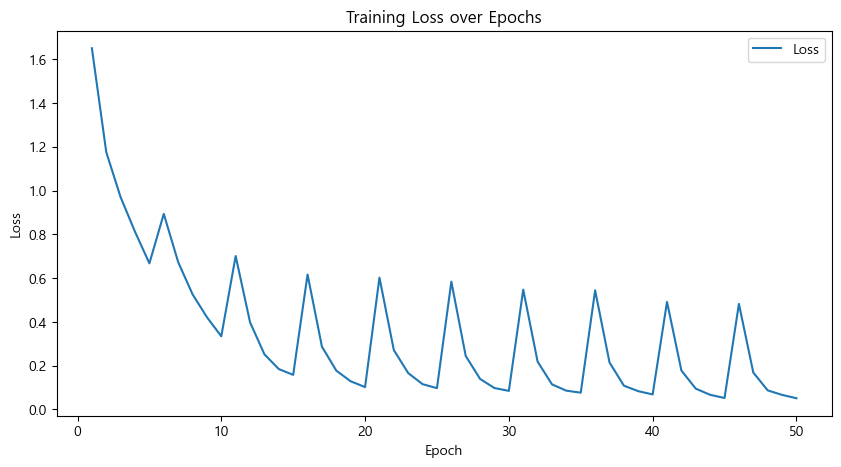

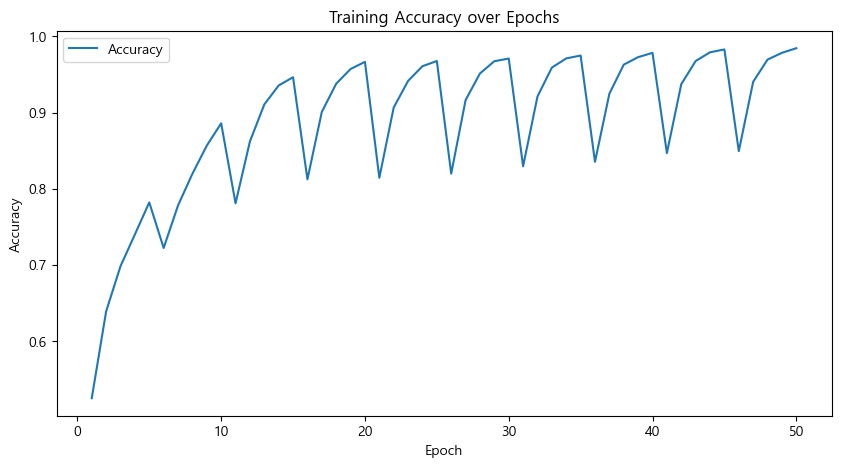

In [ ]:
import torch
import os
import matplotlib.pyplot as plt

checkpoint_dir = './final_no_weight_checkpoint'
num_splits = 10
num_epochs = 5

# Loss와 Accuracy를 저장할 리스트
loss_list = []
accuracy_list = []

# 각 체크포인트에서 데이터 추출
for split_index in range(num_splits):
    for epoch in range(num_epochs):
        checkpoint_path = os.path.join(checkpoint_dir, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            loss_list.append(checkpoint['loss'])
            accuracy_list.append(checkpoint['accuracy'])

# 손실(Loss) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_list) + 1), loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 정확도(Accuracy) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()


### 모델 구조만 갖고온것과 사전학습된 가중치를 갖고온 두가지를 비교

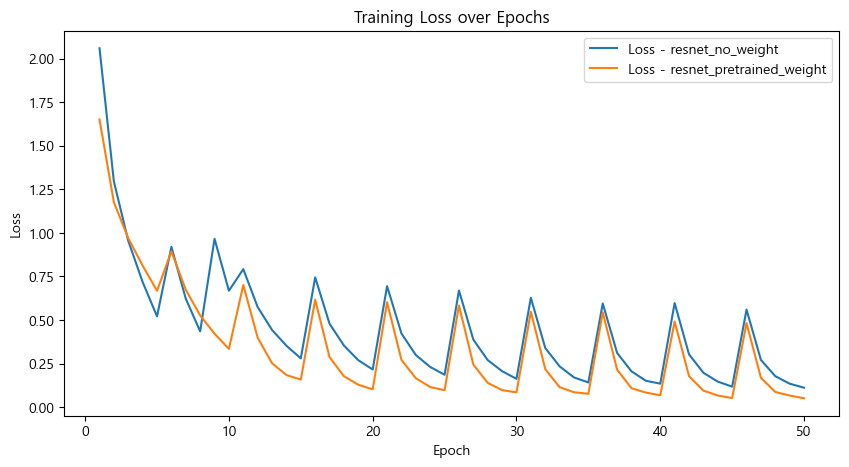

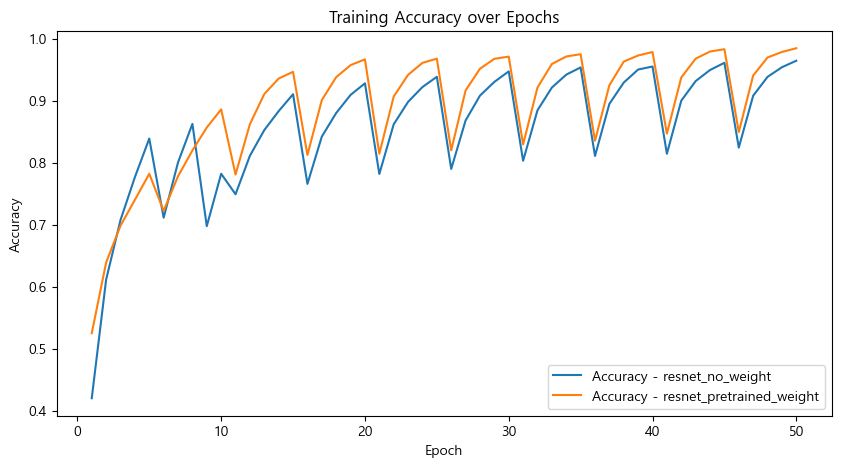

In [10]:
import torch
import os
import matplotlib.pyplot as plt

checkpoint_dir1 = './final_no_weight_checkpoint'
checkpoint_dir2 = './final_checkpoint'
num_splits = 10
num_epochs = 5

# Loss와 Accuracy를 저장할 리스트
loss_list1 = []
accuracy_list1 = []
loss_list2 = []
accuracy_list2 = []

# 각 체크포인트에서 데이터 추출 - 첫 번째 디렉토리
for split_index in range(num_splits):
    for epoch in range(num_epochs):
        checkpoint_path = os.path.join(checkpoint_dir1, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            loss_list1.append(checkpoint['loss'])
            accuracy_list1.append(checkpoint['accuracy'])

# 각 체크포인트에서 데이터 추출 - 두 번째 디렉토리
for split_index in range(num_splits):
    for epoch in range(num_epochs):
        checkpoint_path = os.path.join(checkpoint_dir2, f'subset_{split_index + 1}_epoch_{epoch + 1}_checkpoint.pth')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            loss_list2.append(checkpoint['loss'])
            accuracy_list2.append(checkpoint['accuracy'])

# 손실(Loss) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_list1) + 1), loss_list1, label='Loss - resnet_no_weight')
plt.plot(range(1, len(loss_list2) + 1), loss_list2, label='Loss - resnet_pretrained_weight')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 정확도(Accuracy) 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_list1) + 1), accuracy_list1, label='Accuracy - resnet_no_weight')
plt.plot(range(1, len(accuracy_list2) + 1), accuracy_list2, label='Accuracy - resnet_pretrained_weight')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()


In [9]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
from matplotlib import rc

# 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 랜덤 시드 고정
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# GPU 사용 여부 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 검증 데이터셋 경로 설정
img_root_dir = r"F:\089.차량 내 탑승자 상황 인식 영상 데이터\2.Validation\원천데이터\VS1"
label_root_dir = r"F:\089.차량 내 탑승자 상황 인식 영상 데이터\2.Validation\라벨링데이터\VL1"
validation_dataset = DriverMonitoringDataset(img_root_dir=img_root_dir, label_root_dir=label_root_dir, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, pin_memory=True, collate_fn=custom_collate_fn)

# 모델 로드 및 클래스 수에 맞게 최종 fc 레이어 수정
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 29)  # 체크포인트에 맞게 29개 클래스로 설정
model = model.to(device)

# 체크포인트 로드
checkpoint_dir = './final_no_weight_checkpoint'
latest_checkpoint = sorted(os.listdir(checkpoint_dir))[-1]  # 가장 마지막에 저장된 체크포인트 불러오기
checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded checkpoint from {checkpoint_path}")

# (선택 사항) 필요한 경우 여기서 다시 19개 클래스로 fc 레이어를 맞춤화할 수 있습니다.
# model.fc = torch.nn.Linear(model.fc.in_features, len(validation_dataset.class_to_idx))

# 모델을 평가 모드로 전환
model.eval()

# 검증
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 성능 평가
accuracy = accuracy_score(all_labels, all_preds)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(classification_report(all_labels, all_preds, target_names=list(validation_dataset.class_to_idx.keys())))

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_dataset.class_to_idx.keys(), yticklabels=validation_dataset.class_to_idx.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Using device: cpu
Missing label or image folder for scenario: SGA2100920
Total data loaded: 252477 samples
Loaded checkpoint from ./final_no_weight_checkpoint\subset_9_epoch_5_checkpoint.pth
Validation Accuracy: 2.84%


ValueError: Number of classes, 29, does not match size of target_names, 19. Try specifying the labels parameter

In [5]:
!pip3 install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 294.9/294.9 kB 9.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
